<a href="https://colab.research.google.com/github/fabriziobasso/Closet_Index_Tracking/blob/master/File_02_Calories_NN_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDICTING CALOORIES BURNED

## RMSLE Metric and Competition Context

This notebook is developed for a data science competition focused on predicting **Calories burned** during exercise. The evaluation metric for this competition is the **Root Mean Squared Logarithmic Error (RMSLE)**, which measures the square root of the mean squared difference between the logarithms of predicted and actual values. RMSLE is ideal for datasets with a wide range of target values, as it emphasizes **relative errors**, ensuring balanced performance across small and large calorie values.

The RMSLE formula is:

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*AUzyQ1rc6mpQVYfn)

### Why RMSLE?
- **Handles Wide Ranges**: RMSLE penalizes relative errors proportionally, making it robust for calorie values ranging from small (e.g., 10 calories) to large (e.g., 1000 calories).
- **Balanced Evaluation**: Ensures models perform well across the entire spectrum of calorie burn.
- **Competition Goal**: A lower RMSLE score indicates a precise and generalizable model, critical for ranking high on the leaderboard.

---

## Potential Effects of Features on Calorie Burn

The dataset includes the following features to predict calorie burn: **Sex**, **Age**, **Height**, **Weight**, **Duration**, **Heart_Rate**, and **Body_Temp**. Below, we explore how each feature might influence calorie burn:

### 1. Sex
- **Impact**: Differences in metabolic rates and muscle mass between males and females affect calorie burn. Males often have higher muscle mass, leading to greater calorie expenditure for the same exercise.
- **Example**: A male running at the same pace and duration as a female may burn more calories due to higher energy demands.

### 2. Age
- **Impact**: Basal metabolic rate (BMR) decreases with age, reducing calorie burn in older individuals due to lower metabolic rates and muscle mass (sarcopenia).
- **Example**: A 20-year-old may burn more calories than a 50-year-old during identical workouts.

### 3. Height
- **Impact**: Taller individuals have more body mass or muscle, requiring more energy for movement, thus burning more calories. Height’s effect is often linked to weight and exercise intensity.
- **Example**: A taller person may expend more energy covering the same distance.

### 4. Weight
- **Impact**: Heavier individuals burn more calories due to the energy required to move greater body mass. Body composition (fat vs. muscle) also influences calorie burn.
- **Example**: A 90 kg individual burns more calories walking the same distance as a 60 kg individual.

### 5. Duration
- **Impact**: Longer exercise sessions directly increase total calorie expenditure, though intensity and exercise type also matter.
- **Example**: Running for 30 minutes burns more calories than running for 15 minutes.

### 6. Heart_Rate
- **Impact**: Higher heart rates indicate greater exercise intensity and metabolic effort, leading to increased calorie burn. Fitness levels can modulate heart rate responses.
- **Example**: High heart rate during a HIIT workout correlates with higher calorie burn.

### 7. Body_Temp
- **Impact**: Rising body temperature during exercise reflects increased metabolic activity and thermoregulation, potentially increasing calorie burn. Environmental factors (e.g., heat) also play a role.
- **Example**: Exercising in a hot environment may increase calorie expenditure due to thermoregulation.

---

## Transition to Analysis

Understanding the relationships between these features and calorie burn is key to building a predictive model. In this notebook, we will:

1. **Explore Data**: Analyze the distribution of the target variable (**Calories**) and features using visualizations (e.g., histograms, boxplots).
2. **Correlation Analysis**: Identify relationships between features and the target using correlation matrices and polar plots.
3. **Outlier Detection**: Address anomalies that could skew model performance.
4. **Feature Engineering**: Apply techniques like quantile and equal-width binning to enhance model input.
5. **Model Development**: Build and evaluate models to minimize RMSLE, aligning with competition objectives.

### Visualization Strategy
We will use:
- **Histograms** and **boxplots** to examine feature distributions.
- **Correlation matrices** to uncover feature relationships.
- **Polar plots** for creative visualization of feature impacts.
- **Pair plots** to explore pairwise relationships.

By systematically analyzing the data, we aim to develop a robust model that accurately predicts calorie burn and excels in the competition.

---

# 0.0 Setting

## 0.1 Import Libraries:

In [1]:
# !pip uninstall scikit-learn
# !pip install scikit-learn==1.4

In [2]:
%%capture
#!pip install -qq pytorch_tabnet
!pip install optuna
!pip install --upgrade catboost
#!pip install optuna-integration-pytorch-tabnet

#from pytorch_tabnet.tab_model import TabNetRegressor

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
#!pip install keras-tuner --upgrade
#!pip install keras-nlp
#!pip install BorutaShap
#!pip install scikit-learn==1.2.2
#!pip install scikit-lego
!pip install skops

In [3]:
import sklearn
import lightgbm, xgboost, catboost
sklearn.__version__, lightgbm.__version__, xgboost.__version__, catboost.__version__

('1.6.1', '4.5.0', '2.1.4', '1.2.8')

In [4]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import numpy as np
from pickle import load, dump
import json
import joblib
#from joblib import dump, load
#import calplot as cal

# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from termcolor import colored
# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5});
sns.despine(left=True, bottom=True, top=False, right=False);
mpl.rcParams['figure.dpi'] = 120;
mpl.rc('axes', labelsize=12);
plt.rc('xtick',labelsize=10);
plt.rc('ytick',labelsize=10);

mpl.rcParams['axes.spines.top'] = False;
mpl.rcParams['axes.spines.right'] = False;
mpl.rcParams['axes.spines.left'] = True;

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

# tool for Excel:
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.worksheet.cell_range import CellRange

from openpyxl.formatting import Rule
from openpyxl.styles import Font, PatternFill, Border
from openpyxl.styles.differential import DifferentialStyle

# Bloomberg
#from xbbg import blp
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from xgboost.callback import EarlyStopping

import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

# Time Management
from tqdm import tqdm
from datetime import date
from datetime import datetime
from pandas.tseries.offsets import BMonthEnd, QuarterEnd
import datetime
from pandas.tseries.offsets import BDay # BDay is business day, not birthday...
import datetime as dt
import click
import glob
import os
import gc
import re
import string

from ipywidgets import AppLayout
from ipywidgets import Dropdown, Layout, HTML, AppLayout, VBox, Label, HBox, BoundedFloatText, interact, Output

#from my_func import *

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import backend as K

from keras import ops
from keras import layers
from keras import activations

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

from keras.utils import FeatureSpace, plot_model

# Import libraries for Hypertuning
#import keras_tuner as kt
#from keras_tuner.tuners import RandomSearch, GridSearch, BayesianOptimization

#from my_func import *

# preprocessing modules
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, cross_val_score, cross_validate, GroupKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   QuantileTransformer,
                                   PolynomialFeatures,
                                   FunctionTransformer)

# metrics
import sklearn
#import skops.io as sio
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error,
                             root_mean_squared_log_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss,
                             make_scorer)
# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  HuberRegressor,
                                  TweedieRegressor,
                                  QuantileRegressor,
                                  ARDRegression,
                                  TheilSenRegressor,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.ensemble import (AdaBoostRegressor,
                              AdaBoostClassifier,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              GradientBoostingClassifier,
                              StackingRegressor,
                              StackingClassifier,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              ExtraTreesClassifier)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.base import clone
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from category_encoders import TargetEncoder, CatBoostEncoder, LeaveOneOutEncoder, OrdinalEncoder, CountEncoder

from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain

import itertools
import warnings
from openpyxl import load_workbook

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

#from category_encoders.cat_boost import CatBoostEncoder
#from category_encoders.wrapper import PolynomialWrapper
#from category_encoders.count import CountEncoder
#from category_encoders import TargetEncoder

import skops.io as sio

warnings.filterwarnings('ignore')
#import pyfiglet
#plt.style.use('fivethirtyeight')

<Figure size 640x480 with 0 Axes>

**Formatting and Settings:**

In [5]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 960x660 with 0 Axes>

In [6]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


## 0.2 Functions:

* **Plotting Functiss**

In [7]:
def plot_scatter(df, x="feat1", y="feat2", color_feature=None, cmap='viridis'):
    """
    Generates a scatter plot with points colored based on a third feature.

    Args:
        df: Pandas DataFrame containing the data.
        x: Name of the column to use for the x-axis.
        y: Name of the column to use for the y-axis.
        color_feature: Name of the column to use for coloring the points.
                       If None, points will be a single color.
        cmap: Colormap to use for coloring the points (e.g., 'viridis', 'plasma', 'magma', 'inferno', 'cividis').
              See matplotlib documentation for available colormaps.
    """

    plt.figure(figsize=(8, 5))

    if color_feature is not None:
        # Ensure the color feature exists
        if color_feature not in df.columns:
            raise ValueError(f"Color feature '{color_feature}' not found in DataFrame.")

        # Scatter plot with colors
        scatter = plt.scatter(df[x], df[y], c=df[color_feature], cmap=cmap)

        # Add a colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label(color_feature)  # Label the colorbar

    else:
        # Simple scatter plot (single color)
        plt.scatter(df[x], df[y],color="royalblue",alpha=0.6)

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("Scatter Plot")  # Add a title for better visualization
    plt.show()

* **Dataset Management Functions**:

In [8]:
class Config:

    state = 42
    n_splits = 10
    early_stop = 200

    target = 'Calories'
    train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/test.csv')
    submission = pd.read_csv( "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv")
    #train_org = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/original.csv")

    original_data = 'N'
    outliers = 'N'
    log_trf = 'Y'
    scaler_trf = 'Y'
    feature_eng = 'N'
    missing = 'Y'
    sqrt_normalization="Y"
    impose_normalization="N"
    trg_enc = "N"
    problem = "Regression"
    metric_goal="LRMSE"
    direction_="minimize"
    log_trans_cols = ["Body_Temp"]
    sqrt_norm_cols = ["Age"]
    impose_norm_cols = []
    trg_enc_feat = []

class Preprocessing():

    def __init__(self):
        self.train = Config.train
        self.test = Config.test
        self.targets = Config.target

        self.prp_data()

    def prp_data(self):

        if Config.original_data == 'Y':
            self.train = pd.concat([self.train, Config.train_org], ignore_index=True).drop_duplicates(ignore_index=True)

        self.train = self.train.drop(['id'], axis=1)
        self.test = self.test.drop(['id'], axis=1)

        self.cat_features = self.train.drop(self.targets, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
        self.num_features = self.train.drop(self.targets, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()

        self.train = self.reduce_mem(self.train)
        self.test = self.reduce_mem(self.test)
        return self

    def reduce_mem(self, df):

        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"]

        for col in df.columns:
            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float32)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

        return df

class EDA(Config, Preprocessing):

    def __init__(self):
        super().__init__()

        self.data_info()
        self.heatmap()
        self.dist_plots()
        self.cat_feature_plots()
        if Config.problem == 'Classification':
          self.target_pie()
        else:
          self.target_dist()

    def data_info(self):

        for data, label in zip([self.train, self.test], ['Train', 'Test']):
            table_style = [{'selector': 'th:not(.index_name)',
                            'props': [('background-color', 'slategrey'),
                                      ('color', '#FFFFFF'),
                                      ('font-weight', 'bold'),
                                      ('border', '1px solid #DCDCDC'),
                                      ('text-align', 'center')]
                            },
                            {'selector': 'tbody td',
                             'props': [('border', '1px solid #DCDCDC'),
                                       ('font-weight', 'normal')]
                            }]
            print(Style.BRIGHT+Fore.RED+f'\n{label} head\n')
            display(data.head().style.set_table_styles(table_style))

            print(Style.BRIGHT+Fore.RED+f'\n{label} info\n'+Style.RESET_ALL)
            display(data.info())

            print(Style.BRIGHT+Fore.RED+f'\n{label} describe\n')
            display(data.describe().drop(index='count', columns=self.targets, errors = 'ignore').T
                    .style.set_table_styles(table_style).format('{:.3f}'))

            print(Style.BRIGHT+Fore.RED+f'\n{label} missing values\n'+Style.RESET_ALL)
            display(data.isnull().sum())
        return self

    def heatmap(self):
        print(Style.BRIGHT+Fore.RED+f'\nCorrelation Heatmap\n')
        plt.figure(figsize=(7,7))
        corr = self.train.select_dtypes(exclude='object').corr(method='pearson')
        sns.heatmap(corr, fmt = '0.2f', cmap = 'Blues', annot=True, cbar=False)
        plt.show()

    def dist_plots(self):

        print(Style.BRIGHT+Fore.RED+f"\nDistribution analysis - Numerical\n")
        df = pd.concat([self.train[self.num_features].assign(Source = 'Train'),
                        self.test[self.num_features].assign(Source = 'Test'),],
                        axis=0, ignore_index = True)

        fig, axes = plt.subplots(len(self.num_features), 2 ,figsize = (13, len(self.num_features) * 4),
                                 gridspec_kw = {'hspace': 0.3,
                                                'wspace': 0.2,
                                                'width_ratios': [0.70, 0.30]
                                               }
                                )
        for i,col in enumerate(self.num_features):
            try:
                ax = axes[i,0]
            except:
                ax = axes[i]
            sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source',
                        palette = ['royalblue', 'tomato'], ax = ax, alpha=0.7, linewidth = 2
                       )
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col}")
            ax.grid('--',alpha=0.7)

            try:
                ax = axes[i,1]
            except:
                ax = axes[1]
            sns.boxplot(data = df, y = col, x=df.Source, width = 0.5,
                        linewidth = 1, fliersize= 1,
                        ax = ax, palette=['royalblue', 'tomato']
                       )
            ax.set_title(f"\n{col}")
            ax.set(xlabel = '', ylabel = '')
            ax.tick_params(axis='both', which='major')
            ax.set_xticklabels(['Train', 'Test'])

        plt.tight_layout()
        plt.show()

    def cat_feature_plots(self):
        print(Style.BRIGHT+Fore.RED+f"\nDistribution analysis - Categorical\n")
        fig, axes = plt.subplots(len(self.cat_features), 2 ,figsize = (18, len(self.cat_features) * 6),
                                 gridspec_kw = {'hspace': 0.5,
                                                'wspace': 0.2,
                                               }
                                )

        for i, col in enumerate(self.cat_features):
            try:
                ax = axes[i,0]
            except:
                ax = axes[i]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='royalblue', alpha=0.7)
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Train")

            try:
                ax = axes[i,1]
            except:
                ax = axes[i+1]
            sns.barplot(data=self.test[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='tomato', alpha=0.7)
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Test")

        plt.tight_layout()
        plt.show()

    def target_pie(self):
        print(Style.BRIGHT+Fore.RED+f"\nTarget feature distribution\n")
        targets = self.train[self.targets]
        plt.figure(figsize=(6, 6))
        plt.pie(targets.value_counts(), labels=targets.value_counts().index, autopct='%1.2f%%', colors=palette_9)
        plt.show()

    def target_dist(self):
        print(Style.BRIGHT+Fore.RED+f"\nTarget feature distribution\n")
        fig, axes = plt.subplots(1, 1, figsize=(7, 5))
        sns.histplot(self.train[self.targets], kde=True, ax=axes)
        axes.set_title('Distribution of Price')
        axes.set_xlabel(self.targets)
        axes.set_ylabel('Frequency')

# 1.0 EDA

## 1.1 Experiment Area:

In [9]:
class CFG:
    SEED    = 333
    CV      = KFold(n_splits=15, shuffle=True, random_state=SEED)
    VERSION = '1'

class Data:
    path       = False
    or_path    = ''
    to_drop    = False
    target     = 'Calories'
    drop_duplicates = False

    def __init__(self):
        self.train      = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/df_train_03.csv",index_col=0).drop(columns=self.to_drop) if self.to_drop else pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/df_train_03.csv",index_col=0)
        self.test       = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/df_test_03.csv",index_col=0).drop(columns=self.to_drop) if self.to_drop else pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/df_test_03.csv",index_col=0)
        self.submission = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)
        self.original   = pd.read_csv(self.or_path) if self.or_path else pd.DataFrame()

        self.train.loc[:,"BMI"] = np.clip(self.train.BMI, a_min=-5.0, a_max=5.0)
        self.test.loc[:,"BMI"] = np.clip(self.test.BMI, a_min=-5.0, a_max=5.0)

    @property
    def X(self):
        return self.train.drop(columns=self.target)
    @property
    def y(self):
        return self.train[[self.target]]
    @property
    def X_test(self):
        return self.test
    @property
    def X_original(self):
        if len(self.original) != 0:
            return self.original.drop(columns=self.target)
        return pd.DataFrame()
    @property
    def y_original(self):
        if len(self.original) != 0:
            return self.original[[self.target]]
        return pd.DataFrame()
    @property
    def cat_features(self):
        return self.X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
    @property
    def num_features(self):
        return self.X.select_dtypes(exclude=['category', 'bool', 'category','int']).columns.to_list()

    def submit(self, sub: np.ndarray, desc: str):
        '''Submit the predictions in the adequate format'''
        self.submission[self.target] = sub
        self.submission.to_csv(f'SUB_{CFG.VERSION}_{desc}.csv', index=False)
        print(colored('Submission has been made.', color='green', attrs=['bold', 'dark']))

    @staticmethod
    def sep_line():
        print(colored(f'{"_____"*14}', color='black'))
        print('')

    @staticmethod
    def head(head_text):
        print(colored(f'{"    "} ➩ {head_text} ', color='green', attrs=['dark']))

    def display_data(self):
        self.head(f'𝐃𝐚𝐭𝐚𝐬𝐞𝐭 𝐬𝐡𝐚𝐩𝐞𝐬 — 𝐓𝐫𝐚𝐢𝐧 | 𝐓𝐞𝐬𝐭: {self.train.shape} | {self.test.shape}')
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐡𝐞𝐚𝐝')
        display(self.train.head(5))
        self.head('𝐓𝐞𝐬𝐭 𝐡𝐞𝐚𝐝')
        display(self.test.head(5))
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐢𝐧𝐟𝐨')
        display(self.train.info())
        self.head('𝐓𝐞𝐬𝐭 𝐢𝐧𝐟𝐨')
        display(self.test.info())
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬')
        display(self.train.describe().T)
        self.head('𝐓𝐞𝐬𝐭 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬')
        display(self.test.describe().T)
        self.sep_line()

        def nunique_null(train, test):
            nunique_train, nunique_test = {}, {}
            nulls_train, nulls_test = {}, {}

            for col in test.columns:
                nunique_train[col], nunique_test[col] = train[col].nunique(), test[col].nunique()
                nulls_train[col], nulls_test[col] = train[col].isna().sum(), test[col].isna().sum()

            df = pd.DataFrame([nunique_train, nunique_test,
                               nulls_train, nulls_test],
                              index=['Train nunique', 'Test nunique',
                                     'Train null', 'Test null'])
            return df

        self.head('𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐚𝐧𝐝 𝐧𝐮𝐥𝐥𝐬')
        display(nunique_null(self.train, self.test))
        self.sep_line()

        self.head('𝐃𝐮𝐩𝐥𝐢𝐜𝐚𝐭𝐞𝐬')
        display(f'Train duplicated: {self.train.duplicated().sum()}')
        display(f'Test duplicated: {self.test.duplicated().sum()}')

        if self.drop_duplicates==True:
          if self.train.duplicated().sum() > 0:
              self.train = self.train.drop_duplicates()
              print('Train duplicates dropped.')
          if self.test.duplicated().sum() > 0:
              #self.test = self.test.drop_duplicates()
              print('Test duplicates dropped.')
        self.sep_line()

        self.head('𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐞𝐬𝐭/𝐢𝐧 𝐭𝐞𝐬𝐭 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧')
        cat_cols = [c for c in self.test.columns if self.train[c].nunique() <= 40 or
                    c in self.test.select_dtypes(include=['object', 'category']).columns]

        def compare_unique_categories(train, test, cat_cols):
            unique_train_dic, unique_test_dic = {}, {}

            for c in cat_cols:
                unique_train_c = train[c].unique()
                unique_test_c = test[c].unique()

                count_tr = sum(1 for cat in unique_train_c if cat not in unique_test_c and not pd.isna(cat))
                count_te = sum(1 for cat in unique_test_c if (cat not in unique_train_c and not pd.isna(cat)))

                unique_train_dic[c] = count_tr
                unique_test_dic[c] = count_te

            result_df = pd.DataFrame([unique_train_dic, unique_test_dic],
                                     index=['in train not in test', 'in test not in train'])

            return result_df

        display(compare_unique_categories(self.train, self.test, cat_cols))

data = Data()
data.display_data()

     ➩ 𝐃𝐚𝐭𝐚𝐬𝐞𝐭 𝐬𝐡𝐚𝐩𝐞𝐬 — 𝐓𝐫𝐚𝐢𝐧 | 𝐓𝐞𝐬𝐭: (765000, 16) | (250000, 15) 
______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐡𝐞𝐚𝐝 


,Sex,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity,Intensity_v1,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,BMR,Age_Group,Calories
0,1,1.113015,0.489702,1.266169,0.583480,1.236062,-0.938031,1.183180,-1.090611,-0.952799,1.338352,0,0.848517,0.432900,3,150.0
1,0,-0.909676,-1.081265,-0.888638,-1.109199,-0.430898,-1.184666,-0.923712,-0.418361,0.431582,-1.004625,0,-0.455390,-1.608968,6,34.0
2,0,-1.065268,-0.795635,-1.008350,-1.214992,-0.302671,0.209075,-1.017567,-0.286300,0.610071,-1.047153,0,-0.675342,-0.849602,5,29.0
3,1,1.346402,1.060962,1.146458,1.006650,0.851379,0.026339,1.161541,-0.349679,-0.852901,1.619162,0,0.707173,1.219153,1,140.0
4,0,-0.676289,-1.009858,1.146458,0.689273,0.723151,-1.479569,1.075158,-0.813342,-0.890178,0.535818,0,0.799371,-0.340978,3,146.0


     ➩ 𝐓𝐞𝐬𝐭 𝐡𝐞𝐚𝐝 


,Sex,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity,Intensity_v1,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,BMR,Age_Group
750000,1,0.179465,0.418294,-1.008350,-0.897614,-0.302671,0.978939,-0.995739,0.295543,0.661858,-0.890129,0,-0.658590,-0.307455,4
750001,1,1.968769,1.560816,0.547900,0.583480,0.594924,-0.082149,0.507888,-0.260413,-0.611173,1.078027,0,0.470673,1.781711,2
750002,0,1.035219,0.703924,0.069054,0.689273,0.466696,-0.214836,0.093216,0.624933,-0.294981,0.309886,0,0.254207,2.386314,2
750003,0,-0.209514,-0.152967,0.547900,1.218235,0.723151,0.199218,0.640408,0.708943,-0.533902,0.544812,0,0.691017,0.711718,3
750004,0,-0.131718,-0.581412,0.069054,-0.157067,0.594924,-1.314534,-0.037914,-0.724309,-0.407071,-0.199594,0,0.119383,0.666806,2


______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐢𝐧𝐟𝐨 
<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Sex                           765000 non-null  int64  
 1   Height                        765000 non-null  float64
 2   Weight                        765000 non-null  float64
 3   Duration                      765000 non-null  float64
 4   Heart_Rate                    765000 non-null  float64
 5   Body_Temp                     765000 non-null  float64
 6   BMI                           765000 non-null  float64
 7   Intensity                     765000 non-null  float64
 8   Intensity_v1                  765000 non-null  float64
 9   Heart_Duration                765000 non-null  float64
 10  Weight_Duration_Heart         765000 non-null  float64
 11  Outliers_Duration

None

     ➩ 𝐓𝐞𝐬𝐭 𝐢𝐧𝐟𝐨 
<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Sex                           250000 non-null  int64  
 1   Height                        250000 non-null  float64
 2   Weight                        250000 non-null  float64
 3   Duration                      250000 non-null  float64
 4   Heart_Rate                    250000 non-null  float64
 5   Body_Temp                     250000 non-null  float64
 6   BMI                           250000 non-null  float64
 7   Intensity                     250000 non-null  float64
 8   Intensity_v1                  250000 non-null  float64
 9   Heart_Duration                250000 non-null  float64
 10  Weight_Duration_Heart         250000 non-null  float64
 11  Outliers_Duration_Heart_Temp  250000 non-null  int64  
 12  BMI_Age                   

None

______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬 


,count,mean,std,min,25%,50%,75%,max
Sex,765000.0,4.989882e-01,0.499999,0.000000,0.000000,0.000000,1.000000,1.000000
Height,765000.0,5.077641e-16,1.000001,-4.021508,-0.831880,-0.053922,0.801832,3.680276
Weight,765000.0,1.343297e-16,1.000001,-2.795048,-0.867043,-0.081559,0.846740,4.060081
Duration,765000.0,-4.197311e-17,1.000001,-1.726619,-0.888638,-0.050658,0.907035,1.745015
Heart_Rate,765000.0,6.856041e-16,1.000001,-3.013464,-0.791822,-0.051275,0.795065,3.439877
Body_Temp,765000.0,1.793228e-14,1.000001,-3.764820,-0.559126,0.338468,0.851379,1.877201
BMI,765000.0,-1.325152e-04,0.998632,-5.000000,-0.740093,0.011128,0.736294,5.000000
Intensity,765000.0,3.098059e-17,1.000001,-1.563858,-0.875844,-0.105610,0.840522,2.483148
Intensity_v1,765000.0,-1.483010e-15,1.000001,-5.230777,-0.670825,-0.096130,0.539496,8.631268
Heart_Duration,765000.0,1.511371e-15,1.000001,-1.390121,-0.757049,-0.333324,0.443798,4.005130


     ➩ 𝐓𝐞𝐬𝐭 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬 


,count,mean,std,min,25%,50%,75%,max
Sex,250000.0,0.498876,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
Height,250000.0,0.002528,0.997501,-3.710325,-0.831880,-0.053922,0.801832,3.446889
Weight,250000.0,0.000396,0.998243,-2.580825,-0.867043,-0.081559,0.846740,3.631636
Duration,250000.0,-0.000926,0.999487,-1.726619,-0.888638,-0.050658,0.907035,1.745015
Heart_Rate,250000.0,-0.000591,0.999756,-3.013464,-0.791822,-0.051275,0.795065,3.439877
Body_Temp,250000.0,0.000066,0.998186,-3.764820,-0.559126,0.338468,0.723151,1.877201
BMI,250000.0,-0.004466,0.998080,-5.000000,-0.740093,0.008131,0.728037,5.000000
Intensity,250000.0,-0.000928,0.999746,-1.563333,-0.876596,-0.107700,0.834455,2.493177
Intensity_v1,250000.0,-0.000195,0.998002,-4.522650,-0.670825,-0.096189,0.539496,7.783418
Heart_Duration,250000.0,-0.000380,0.997461,-1.312222,-0.757049,-0.326515,0.437294,3.835281


______________________________________________________________________

     ➩ 𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐚𝐧𝐝 𝐧𝐮𝐥𝐥𝐬 


,Sex,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity,Intensity_v1,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,BMR,Age_Group
Train nunique,2,92,92,30,63,75,2201,11378,1268,1102,21630,2,755723,56336,7
Test nunique,2,85,84,30,61,51,1812,9097,1104,973,19010,2,248941,43551,7
Train null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Test null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


______________________________________________________________________

     ➩ 𝐃𝐮𝐩𝐥𝐢𝐜𝐚𝐭𝐞𝐬 


'Train duplicated: 2893'

'Test duplicated: 918'

______________________________________________________________________

     ➩ 𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐞𝐬𝐭/𝐢𝐧 𝐭𝐞𝐬𝐭 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 


,Sex,Duration,Outliers_Duration_Heart_Temp,Age_Group
in train not in test,0,0,0,0
in test not in train,0,0,0,0


In [10]:
data.X.shape, data.y.shape, data.X_test.shape

((765000, 15), (765000, 1), (250000, 15))

In [11]:
print(data.cat_features)

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group']


In [12]:
#plot_scatter(pd.concat([data.X,data.y],axis=1), x="BMI", y="Intensity", color_feature="Calories")

In [13]:
data.X.info(),data.X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Sex                           765000 non-null  int64  
 1   Height                        765000 non-null  float64
 2   Weight                        765000 non-null  float64
 3   Duration                      765000 non-null  float64
 4   Heart_Rate                    765000 non-null  float64
 5   Body_Temp                     765000 non-null  float64
 6   BMI                           765000 non-null  float64
 7   Intensity                     765000 non-null  float64
 8   Intensity_v1                  765000 non-null  float64
 9   Heart_Duration                765000 non-null  float64
 10  Weight_Duration_Heart         765000 non-null  float64
 11  Outliers_Duration_Heart_Temp  765000 non-null  int64  
 12  BMI_Age                       765000 non-null  f

(None, None)

In [14]:
data.X_test.shape, data.y.shape

y_test_fic = data.y[:len(data.X_test)].copy()
y_test_fic["Calories"]=np.nan

# 2.0 Neural Networks:


In [15]:
def dataframe_to_dataset(dataframe, target, categorical_features, numerical_features, shuffle=False, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices(((dataframe[categorical_features].values,  # First input
                                              dataframe[numerical_features].values),
                                              target))

    if shuffle:
      ds = ds.shuffle(buffer_size=len(dataframe))

    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)

    return ds

def dataframe_to_dataset_test(dataframe, target_finc, categorical_features, numerical_features, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices(((dataframe[categorical_features].values,  # First input
                                              dataframe[numerical_features].values),
                                              target_finc))

    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)

    return ds

In [16]:
def plot_training_session(history):
  # Plot training and validation loss scores
  # against the number of epochs.
  plt.figure(figsize=(8, 6))
  plt.plot(history.history['loss'], label='Train')
  plt.plot(history.history['val_loss'], label='Validation')
  plt.grid(linestyle='--')
  plt.ylabel('val_loss')
  plt.xlabel('Epoch')
  plt.title('Train-Validation Scores', pad=13)
  plt.legend(loc='upper right');
  plt.show()

def rmsle(y_true, y_pred):
    """
    Root Mean Squared Logarithmic Error (RMSLE)
    """
    # Ensure y_pred is non-negative and add a small constant to avoid log(0) errors
    y_pred = K.maximum(K.cast(y_pred, tf.float32), K.epsilon()) # Corrected: K.maximum

    first_log = K.log(K.maximum(K.cast(y_pred, tf.float32), K.epsilon()) + 1.) # Corrected: K.maximum
    second_log = K.log(K.maximum(K.cast(y_true, tf.float32), K.epsilon()) + 1.) # Corrected: K.maximum

    return K.sqrt(K.mean(K.square(first_log - second_log)))

# def rmsle(y_true, y_pred):
#     """
#     Root Mean Squared Logarithm Error
#     Args:
#         y_true ([np.array]): test samples
#         y_pred ([np.array]): predicted samples
#     Returns:
#         [float]: root mean squared logarithm error
#     """
#     first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
#     second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
#     return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

In [17]:
class CFG:
    SEED    = 333
    CV      = KFold(n_splits=11, shuffle=True, random_state=SEED)
    VERSION = '1'

class TrainModels:
    def __init__(self, X, y, X_test, test_finc_target, X_original, y_original, model_, parameters):
        self.model     = model_
        self.parameters = parameters
        self.X          = X
        self.y          = y
        self.test_finc_target = test_finc_target
        self.X_test     = X_test
        self._OOF_train = pd.DataFrame()
        self._OOF_test  = pd.DataFrame()
        self.categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
        self.numerical_features = X.select_dtypes(exclude=['category', 'bool', 'category','int']).columns.to_list()

    def fit_model(self, name="Base_model"):
        oof_train = np.zeros(self.X.shape[0])
        oof_test  = np.zeros(self.X_test.shape[0])
        scores_train = []
        scores_val   = []

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/layers_3_staked_models')

        train_start = 0

        for fold, (train_idx, val_idx) in enumerate(CFG.CV.split(self.X, self.y)):
            x_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            x_val,   y_val   = self.X.iloc[val_idx],   self.y.iloc[val_idx]


            train_ds = dataframe_to_dataset(x_train, y_train, self.categorical_features, self.numerical_features, shuffle=True, batch_size=1024)
            val_ds = dataframe_to_dataset(x_val, y_val, self.categorical_features, self.numerical_features, shuffle=False, batch_size=1024)
            test_ds = dataframe_to_dataset_test(self.X_test, self.test_finc_target, self.categorical_features, self.numerical_features, batch_size=1024)

            model = self.model(**self.parameters)

            optimizer = keras.optimizers.Adam(learning_rate=5e-4)
            model.compile(optimizer=optimizer,
                          loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                          metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

            checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
            model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                        filepath=checkpoint_filepath,
                                                                        save_weights_only=True,
                                                                        monitor='val_rmsle',
                                                                        mode='min',
                                                                        save_best_only=True
                                                                        )
            if fold >= train_start:
              # Fit the model
              history = model.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=151,
                                  batch_size=1024,
                                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6, monitor="val_rmsle", mode="min"),
                                            keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_rmsle",
                                                                            start_from_epoch=3, mode="min"),
                                              model_checkpoint_callback])

              model.load_weights(checkpoint_filepath)
              model.save(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/keras_models/{name}_{fold}.keras")
              plot_training_session(history)

            else:
              model = tf.keras.models.load_model(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/keras_models/{name}_{fold}.keras",
                                                custom_objects={'rmsle': rmsle})

            model.evaluate(val_ds, verbose=0)

            # Make predictions
            y_pred_train = model.predict(train_ds)
            y_pred_val   = model.predict(val_ds)
            y_pred_test  = model.predict(test_ds)

            # Correct Ranges:

            y_pred_train = np.maximum(y_pred_train, 1.0)
            y_pred_train = np.minimum(y_pred_train, 315.0)

            y_pred_val = np.maximum(y_pred_val, 1.0)
            y_pred_val = np.minimum(y_pred_val, 315.0)

            y_pred_test = np.maximum(y_pred_test, 1.0)
            y_pred_test = np.minimum(y_pred_test, 315.0)

            # Store Results
            oof_train[val_idx] = y_pred_val.reshape(-1)
            oof_test   += (y_pred_test/CFG.CV.get_n_splits()).reshape(-1)

            train_score = root_mean_squared_log_error(y_train, y_pred_train)
            val_score   = root_mean_squared_log_error(y_val, y_pred_val)

            print(f'Fold {fold+1} → Training set Score: {train_score:.5f} | Validation set Score: {val_score:.5f}')

            scores_train.append(train_score)
            scores_val.append(val_score)

            gc.collect()
            K.clear_session()

        self._OOF_train[name] = oof_train
        self._OOF_test[name]  = oof_test

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5')

        print(colored(f'Overall → Training set Score: {np.mean(scores_train):.5f}±{np.std(scores_train):.7f} | Validation set Score: {np.mean(scores_val):.5f}±{np.std(scores_val):.7f}',
              color='green', attrs=['bold', 'dark']))

    @property
    def OOF_train(self):
        return self._OOF_train
    @property
    def OOF_test(self):
        return self._OOF_test

    def save_predictions(self):
        self._OOF_train.to_csv('OOF_train_many_models.csv', index=False)
        self._OOF_test.to_csv('OOF_test_many_models.csv', index=False)

### **2.1.0 NeuralNetwork: Dense**

In [ ]:
data.X.sample(3)

In [ ]:
data.X.max(axis=0)

In [ ]:
data.X.min(axis=0)

In [ ]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]

print(cat_features,cat_features_card)
print(num_features)

In [ ]:
np.ceil(np.sqrt(cat_features_card[1]))

In [ ]:
def build_model(units=512,last_layer = 1, activation="relu", do_rate=0.25, reg=0.001):

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], cat_features_out[j]) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])
    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(do_rate)(x)
    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(do_rate)(x)
    x = layers.Dense(int(units/last_layer), activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(do_rate)(x)
    x_final = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [ ]:
mod_test = build_model(units=512)
mod_test.summary()

#### 2.1.1 Optuna Optimization:

In [ ]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

In [ ]:
y_fin.isna().sum()

**OPTIMIZATION SECTION**

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=build_model, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {'units': trial.suggest_categorical('units', [128,256,512,1024]),
              'last_layer': trial.suggest_int('last_layer', 1,2),
              'activation': trial.suggest_categorical('activation', ["relu","silu","mish"]), #, reg=0.001, dropout_rate=0.33) #"relu","selu","gelu","silu"
              'reg': trial.suggest_float('reg', 1e-4, 0.1, log=True),
              'do_rate': trial.suggest_float('do_rate', 0.30, 0.50, step=0.01)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=5e-4)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=31,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6, monitor="val_rmsle"),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=build_model, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

  1. {'units': 256,
 'last_layer': 1,
 'activation': 'relu',
 'reg': 0.00039536431216575824,
 'do_rate': 0.32} Score: 0.0631159157056562

In [ ]:
nn0_study = tune_hyperparameters(X_fin, y_fin, model_class=build_model, n_trials=31, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn0_study.best_params

In [ ]:
cat_params

#### 2.1.2 Train Model:

In [ ]:
param = {'units': 256, 'last_layer': 1, 'activation': 'relu', 'reg': 0.00039536431216575824, 'do_rate': 0.32}
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=build_model, parameters=param)

In [ ]:
TM.fit_model(name="NN_exp_01_v1")

#### 2.1.3 Store Results:

In [ ]:
train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred, columns = ["NN_exp_01_v1"])


sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

sub.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_NN_exp_01_v1.csv")
train_pred.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_NN_exp_01_v1.csv")

In [ ]:
test_pred.min(), test_pred.max()

In [ ]:
train_pred

### **2.2.0 NeuralNetwork: Wide and Deep Model v0**

In [ ]:
data.X.sample(3)

In [ ]:
data.X.max(axis=0)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(data.X.BMI, bins=31)
ax[1].hist(data.X_test.BMI, bins=31, color="salmon")

plt.show()

In [ ]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]


print(cat_features,cat_features_card)
print(num_features)

In [ ]:
def wide_deep(units=512, activation="relu", do_rate=0.25, reg=0.001, hidden_layers=3):
    '''
    In this model embedding is performed for the data feeding into both the Deep and and wide layers:
    '''

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], cat_features_out[j]) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])

    wide = layers.BatchNormalization()(x)
    deep = x

    for lay in range(hidden_layers):
        deep = layers.Dense(units,kernel_regularizer=keras.regularizers.l2(reg), name=f"dense_deep_{lay}")(deep)
        deep = layers.BatchNormalization(name=f"bn_deep_{lay}")(deep)
        if activation == "relu":
            deep = layers.ReLU(name=f"relu_deep_{lay}")(deep)
        elif activation == "prelu":
            deep = layers.PReLU(name=f"prelu_deep_{lay}")(deep)
        elif activation == "gelu ":
            deep = activations.gelu(deep)
        elif activation == "silu":
            deep = activations.silu(deep)
        elif activation == "mish":
            deep = layers.Lambda(lambda x: keras.activations.mish(x), name=f"mish_deep_{lay}")(deep)
        elif activation == "celu":
            deep = activations.celu(deep)

        deep = layers.Dropout(do_rate, name=f"do_deep_{lay}")(deep)

    merged = layers.concatenate([wide, deep])

    x_final = layers.Dense(1, activation='linear')(merged)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [ ]:
mod_test = wide_deep(units=512, activation="celu")
mod_test.summary()

In [ ]:
#keras.utils.plot_model(mod_test, show_shapes=True, rankdir="LR")

#### 2.2.1 Optuna Optimization:

In [ ]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

In [ ]:
y_fin.isna().sum()

**OPTIMIZATION SECTION**

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=wide_deep, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'units': trial.suggest_categorical('units', [128,256,512,1024]),
              'activation': "silu", #trial.suggest_categorical('activation', ["relu","prelu","silu","mish"]), #, reg=0.001, dropout_rate=0.33)
              'reg': trial.suggest_float('reg', 1e-4, 0.01, log=True),
              'do_rate': trial.suggest_float('do_rate', 0.30, 0.40, step=0.01),
              'hidden_layers': trial.suggest_int('hidden_layers', 1,4)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=5e-4)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint_dw.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=37,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6, monitor="val_rmsle", mode="min"),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

        gc.collect()

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

  1. Trial 32 finished with value: 0.06224817614285113 and parameters: {'units': 512, 'last_layer': 2, 'activation': 'silu', 'reg': 0.000103427172893175, 'do_rate': 0.40056000512858025, 'hidden_layers': 2}

  2. Trial 18 finished with value: 0.06211038027842043 and parameters: {'units': 512, 'last_layer': 2, 'activation': 'silu', 'reg': 0.0001004170129215336, 'do_rate': 0.41356627172269655, 'hidden_layers': 3} Best

  3.  Trial 23 finished with value: 0.06239891244956206 and parameters: {'units': 512, 'last_layer': 2, 'activation': 'silu', 'reg': 0.00010001356287977584, 'do_rate': 0.4642367345915417, 'hidden_layers': 2}.

In [ ]:
nn0_study = tune_hyperparameters(X_fin, y_fin, model_class=wide_deep, n_trials=32, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn0_study.best_params

In [ ]:
cat_params

  1. Trial 21 finished with value: 0.06031049367720441 and parameters: {'units': 256, 'reg': 0.00011385972470561927, 'do_rate': 0.33, 'hidden_layers': 3}

In [ ]:
optuna.visualization.plot_optimization_history(nn0_study)

In [ ]:
optuna.visualization.plot_param_importances(nn0_study)

In [ ]:
optuna.visualization.plot_contour(nn0_study, params=["units", "hidden_layers"])

#### 2.2.2 Train Model:

In [ ]:
param =  {'units': 256, 'reg': 0.00011385972470561927, 'do_rate': 0.33, 'hidden_layers': 3}

In [ ]:
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=wide_deep, parameters=param)

In [ ]:
TM.fit_model(name="NN_widedeep_01_v1")

#### 2.2.3 Store Results:

In [ ]:
# train_pred = TM.OOF_train
# train_pred

In [ ]:
name_experiment = "NN_widedeep_01_v3"

train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred.values, columns = [f"{name_experiment}"])

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

In [ ]:
test_pred.min(), test_pred.max()

In [ ]:
test_pred.head()

In [ ]:
sub.head()

In [ ]:
train_pred.head()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [ ]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

### **2.3.0 NeuralNetwork: Wide and Deep Model v1**

This version of the model includes a Cross Layers within the Wide Branch of the NN.

In [18]:
data.X.sample(3)

,Sex,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity,Intensity_v1,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,BMR,Age_Group
384548,1,-1.065268,-0.510005,1.745015,0.583480,1.364290,1.229502,1.623702,-1.532953,-1.131766,1.213613,0,1.113971,-1.684207,3
684540,0,-0.442901,-0.438597,-1.128061,-1.214992,-0.943809,-0.142444,-1.111465,0.069928,0.838549,-1.085493,0,-1.034751,0.462660,3
412521,1,0.957423,0.561109,1.146458,0.371895,0.851379,-0.422495,1.002094,-1.277006,-0.928346,1.205357,0,0.955297,0.132546,5


In [19]:
data.X.max(axis=0)

,0
Sex,1.000000
Height,3.680276
Weight,4.060081
Duration,1.745015
Heart_Rate,3.439877
Body_Temp,1.877201
BMI,5.000000
Intensity,2.483148
Intensity_v1,8.631268
Heart_Duration,4.005130


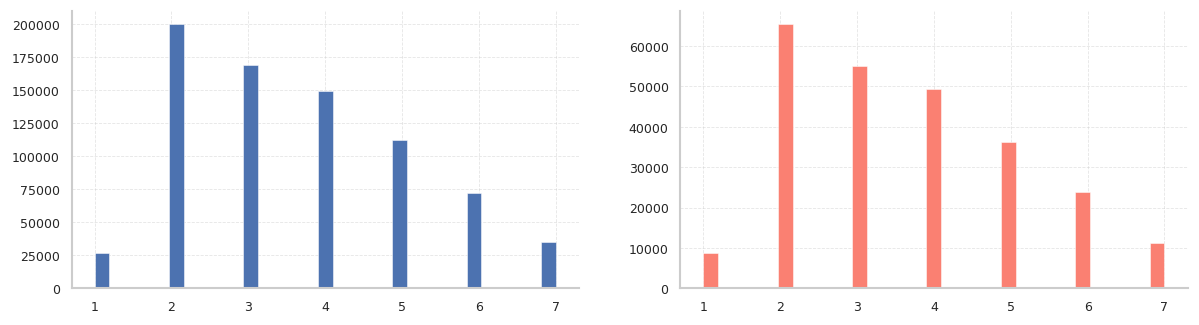

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(data.X.Age_Group, bins=31)
ax[1].hist(data.X_test.Age_Group, bins=31, color="salmon")

plt.show()

In [21]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]


print(cat_features,cat_features_card)
print(num_features)

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group'] [2, 2, 8]
['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Intensity', 'Intensity_v1', 'Heart_Duration', 'Weight_Duration_Heart', 'BMI_Age', 'BMR']


In [22]:
def wide_deep_cross(units=512, activation="relu", do_rate=0.25, reg=0.001, hidden_layers=3, num_cross_layers=2):
    '''
    In this model embedding is performed for the data feeding into both the Deep and and wide layers:
    '''

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], cat_features_out[j]) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])

    deep = x
    wide = x  # Both Branches start with the concatenated features

    # Wide Branch with Cross Layers:
    for _ in range(num_cross_layers):
        xl = layers.Dense(units=x.shape[-1],  # Output dimension same as input
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros',
                         activation=None)(wide)  # Linear activation
        # Cross Layer Calculation:
        cross = layers.Multiply()([x, xl])  # Element-wise multiplication
        # Concatenate instead of Add:
        wide = layers.Concatenate(axis=-1)([wide, cross])

    # Deep Branch:
    for lay in range(hidden_layers):
        deep = layers.Dense(units,kernel_regularizer=keras.regularizers.l2(reg), name=f"dense_deep_{lay}")(deep)
        deep = layers.BatchNormalization(name=f"bn_deep_{lay}")(deep)
        if activation == "relu":
            deep = layers.ReLU(name=f"relu_deep_{lay}")(deep)
        elif activation == "prelu":
            deep = layers.PReLU(name=f"prelu_deep_{lay}")(deep)
        elif activation == "gelu ":
            deep = activations.gelu(deep)
        elif activation == "silu":
            deep = activations.silu(deep)
        elif activation == "mish":
            deep = layers.Lambda(lambda x: keras.activations.mish(x), name=f"mish_deep_{lay}")(deep)
        elif activation == "celu":
            deep = activations.celu(deep)

        deep = layers.Dropout(do_rate, name=f"do_deep_{lay}")(deep)

    merged = layers.concatenate([wide, deep])

    x_final = layers.Dense(1, activation='linear')(merged)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [23]:
mod_test = wide_deep_cross(units=512, activation="celu")
mod_test.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None)            │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None)            │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None)            │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 2)         │          4 │ get_item[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 2)         │          4 │ get_item_1[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 4)         │         32 │ get_item_2[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_deep_0        │ (None, 512)       │     10,752 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_deep_0           │ (None, 512)       │      2,048 │ dense_deep_0[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ celu (Celu)         │ (None, 512)       │          0 │ bn_deep_0[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ do_deep_0 (Dropout) │ (None, 512)       │          0 │ celu[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_deep_1        │ (None, 512)       │    262,656 │ do_deep_0[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_deep_1           │ (None, 512)       │      2,048 │ dense_deep_1[0][… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 544,061 (2.08 MB)

 Trainable params: 540,989 (2.06 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [24]:
#keras.utils.plot_model(mod_test, show_shapes=True, rankdir="LR")

#### 2.3.1 Optuna Optimization:

In [ ]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

In [ ]:
y_fin.isna().sum()

**OPTIMIZATION SECTION**

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=wide_deep_cross, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'units': trial.suggest_categorical('units', [256,512,1024]),
              'num_cross_layers': trial.suggest_int('num_cross_layers', 2, 3),
              'activation': trial.suggest_categorical('activation', ["prelu","silu"]),
              'reg': trial.suggest_float('reg', 1e-4, 0.01, log=True),
              'do_rate': trial.suggest_float('do_rate', 0.25, 0.45, step=0.01),
              'hidden_layers': trial.suggest_int('hidden_layers', 1,3)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=5e-4)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint_dwc.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=37,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6, monitor="val_rmsle", mode="min"),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

  1. Trial 13 finished with value: 0.05983872255726027 and parameters: {'units': 512, 'num_cross_layers': 3, 'activation': 'prelu', 'reg': 0.0040037589446643715, 'do_rate': 0.2831962881166014, 'hidden_layers': 2}

  2. Trial 5 finished with value: 0.05979384223863736 and parameters: {'units': 512, 'num_cross_layers': 3, 'activation': 'silu', 'reg': 0.00042745681670868413, 'do_rate': 0.31089967587135187, 'hidden_layers': 1}. Best is trial 5 with value: 0.05979384223863736.

  3.  Trial 14 finished with value: 0.05959701397529347 and parameters: {'units': 512, 'num_cross_layers': 2, 'activation': 'prelu', 'reg': 0.00011001434564077088, 'do_rate': 0.29, 'hidden_layers': 3}. BEST

In [ ]:
nn3_study = tune_hyperparameters(X_fin, y_fin, model_class=wide_deep_cross, n_trials=21, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn3_study.best_params

In [ ]:
cat_params

In [ ]:
optuna.visualization.plot_param_importances(nn3_study)

#### 2.1.2 Train Model:

In [28]:
param = {'units': 512, 'num_cross_layers': 2, 'activation': 'prelu', 'reg': 0.00011001434564077088, 'do_rate': 0.29, 'hidden_layers': 3}

In [29]:
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=wide_deep_cross, parameters=param)

Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - dense_8_loss: 0.0000e+00 - loss: 1.5618 - msle: 80.8569 - rmsle: 1.4637 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.1457 - val_msle: 9.6488 - val_rmsle: 0.1003 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_8_loss: 0.0000e+00 - loss: 0.1137 - msle: 5.1109 - rmsle: 0.0773 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0946 - val_msle: 5.6284 - val_rmsle: 0.0756 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_8_loss: 0.0000e+00 - loss: 0.0882 - msle: 4.6889 - rmsle: 0.0719 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0755 - val_msle: 4.4363 - val_rmsle: 0.0651 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - dense_8_loss: 0.0000e+00 - loss: 0.0777 - msle: 4.4596 - rmsle: 0.0683 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0788 - val_msle: 5.4939 - val_rmsle: 0.0717 - learning_rate: 5.0000e-04
Epoch 5/151
680/680 ━━━━━

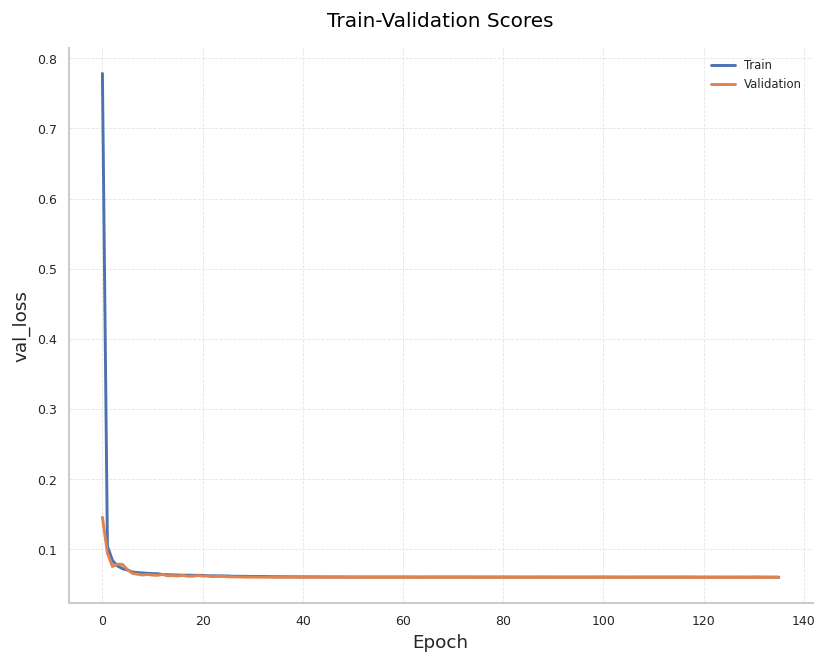

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 1 → Training set Score: 1.36183 | Validation set Score: 0.05964
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - dense_2_loss: 0.0000e+00 - loss: 1.6534 - msle: 81.5459 - rmsle: 1.5531 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.1277 - val_msle: 7.0395 - val_rmsle: 0.0789 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.1151 - msle: 5.0556 - rmsle: 0.0758 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0953 - val_msle: 4.4882 - val_rmsle: 0.0754 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.0864 - msle: 4.5566 - rmsle: 0.0695 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0780 - val_msle: 4.6438 - val_rmsle: 0.0677 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - dense_2_loss: 0.0000e+0

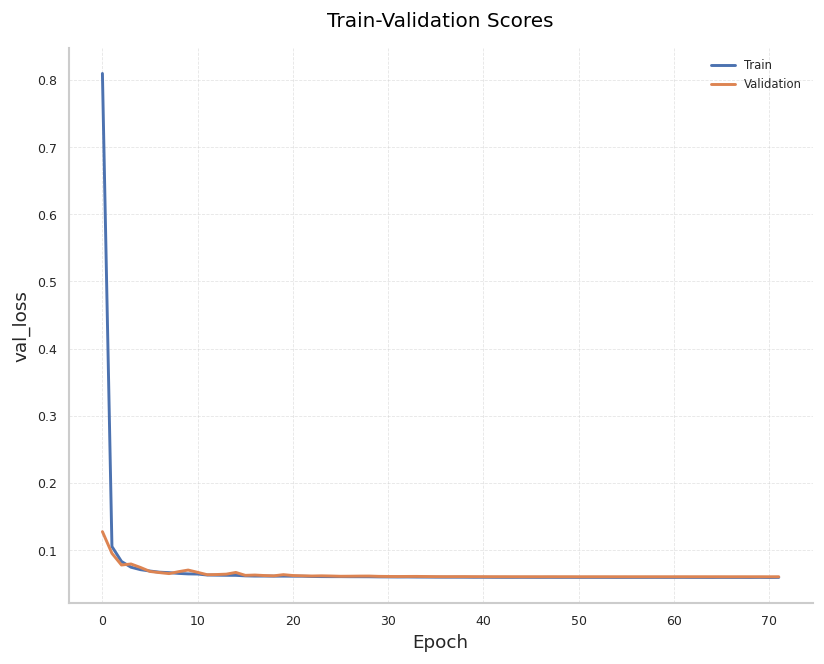

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 2 → Training set Score: 1.36080 | Validation set Score: 0.06061
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - dense_2_loss: 0.0000e+00 - loss: 1.6559 - msle: 81.5438 - rmsle: 1.5553 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.1296 - val_msle: 6.3104 - val_rmsle: 0.0796 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_2_loss: 0.0000e+00 - loss: 0.1161 - msle: 4.9519 - rmsle: 0.0760 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0848 - val_msle: 4.8243 - val_rmsle: 0.0647 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.0863 - msle: 4.5053 - rmsle: 0.0695 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0740 - val_msle: 3.9306 - val_rmsle: 0.0637 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+0

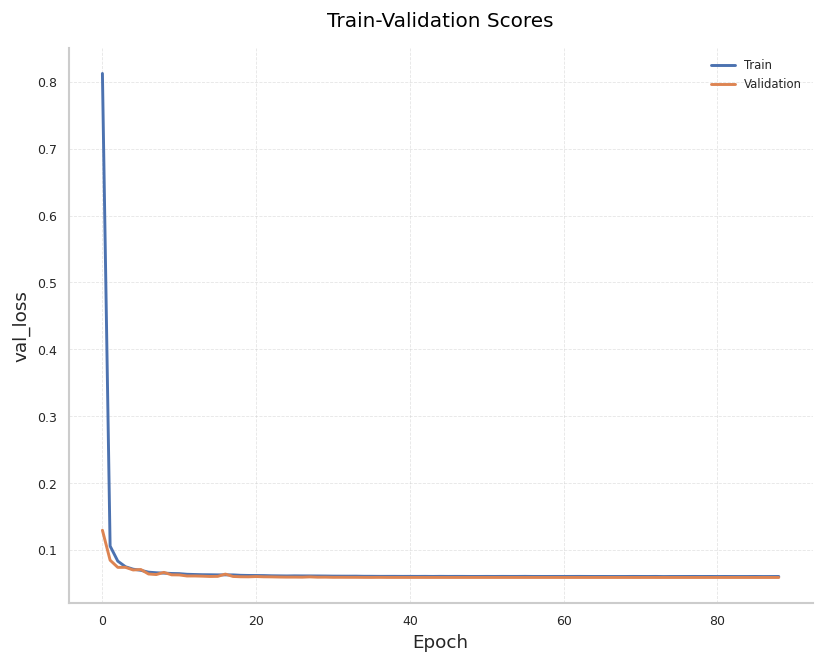

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 3 → Training set Score: 1.36281 | Validation set Score: 0.05852
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - dense_2_loss: 0.0000e+00 - loss: 1.5849 - msle: 81.1062 - rmsle: 1.4868 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.1353 - val_msle: 8.6332 - val_rmsle: 0.0903 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.1125 - msle: 5.0591 - rmsle: 0.0764 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0886 - val_msle: 5.4629 - val_rmsle: 0.0700 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.0857 - msle: 4.6855 - rmsle: 0.0700 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0794 - val_msle: 4.5342 - val_rmsle: 0.0697 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+0

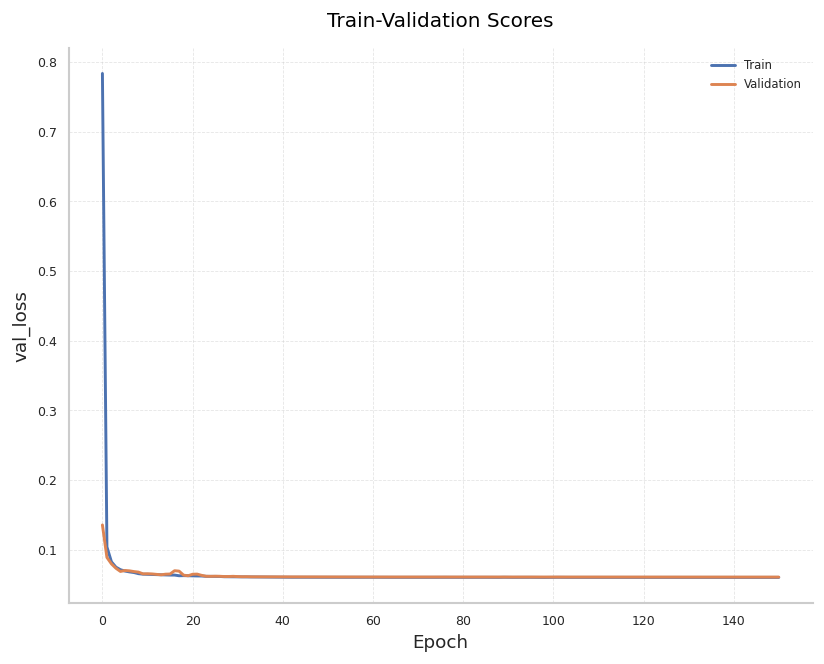

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 4 → Training set Score: 1.35990 | Validation set Score: 0.06039
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - dense_2_loss: 0.0000e+00 - loss: 1.6087 - msle: 81.6346 - rmsle: 1.5095 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.1265 - val_msle: 7.2767 - val_rmsle: 0.0789 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.1130 - msle: 5.0609 - rmsle: 0.0748 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0842 - val_msle: 4.1394 - val_rmsle: 0.0648 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.0860 - msle: 4.6473 - rmsle: 0.0698 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0769 - val_msle: 4.8724 - val_rmsle: 0.0669 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+0

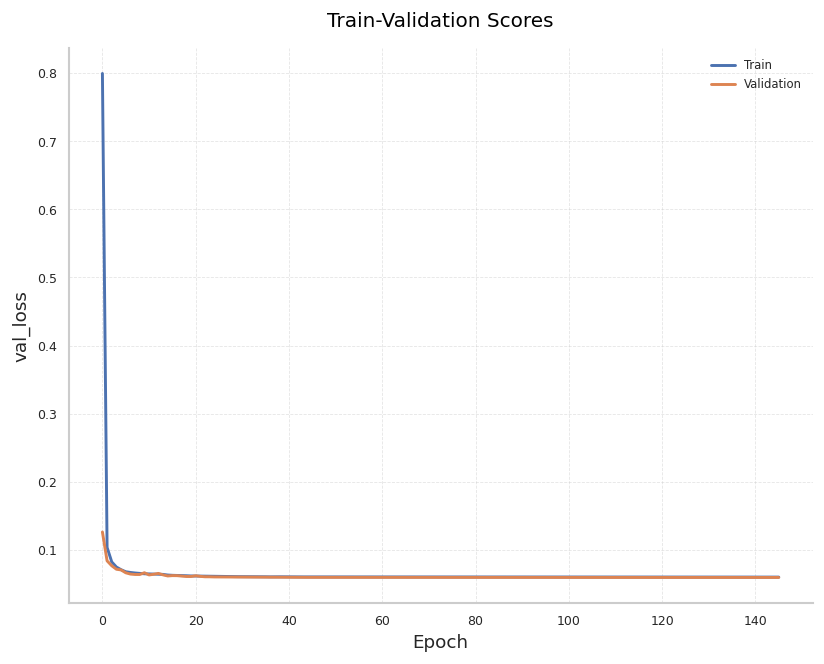

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 5 → Training set Score: 1.36014 | Validation set Score: 0.05946
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - dense_2_loss: 0.0000e+00 - loss: 1.5933 - msle: 81.4661 - rmsle: 1.4952 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.1461 - val_msle: 9.1454 - val_rmsle: 0.0995 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.1153 - msle: 5.0076 - rmsle: 0.0775 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0899 - val_msle: 4.4796 - val_rmsle: 0.0699 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.0876 - msle: 4.6078 - rmsle: 0.0706 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0837 - val_msle: 6.2937 - val_rmsle: 0.0730 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+0

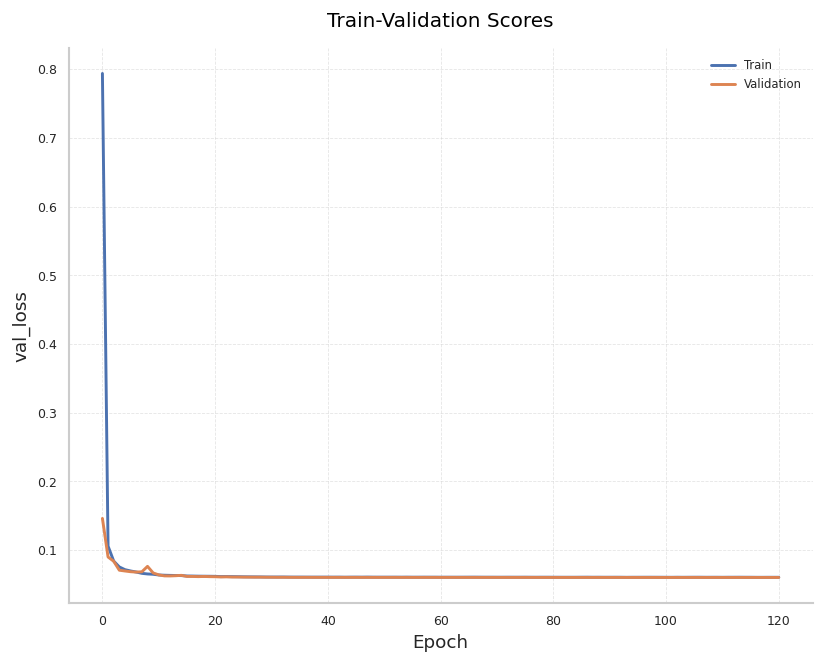

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 6 → Training set Score: 1.36120 | Validation set Score: 0.05952
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - dense_2_loss: 0.0000e+00 - loss: 1.6312 - msle: 81.6397 - rmsle: 1.5317 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.1290 - val_msle: 7.0878 - val_rmsle: 0.0793 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.1239 - msle: 5.1782 - rmsle: 0.0830 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.1062 - val_msle: 8.1073 - val_rmsle: 0.0838 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_2_loss: 0.0000e+00 - loss: 0.0906 - msle: 4.6892 - rmsle: 0.0715 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0768 - val_msle: 4.6084 - val_rmsle: 0.0649 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+0

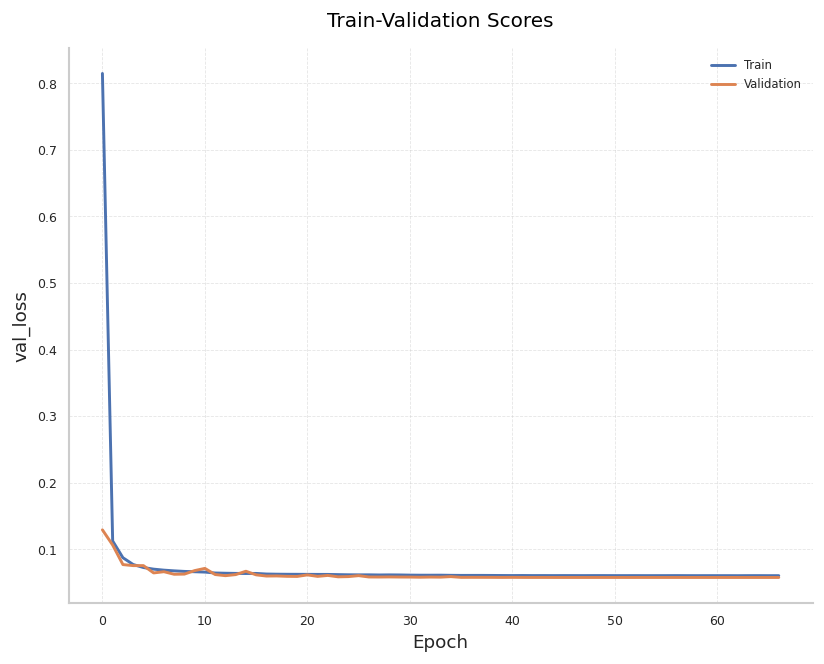

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 7 → Training set Score: 1.36113 | Validation set Score: 0.05706
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - dense_2_loss: 0.0000e+00 - loss: 1.6707 - msle: 81.3526 - rmsle: 1.5709 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.1351 - val_msle: 7.9936 - val_rmsle: 0.0876 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_2_loss: 0.0000e+00 - loss: 0.1117 - msle: 4.8472 - rmsle: 0.0740 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0908 - val_msle: 6.1542 - val_rmsle: 0.0726 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.0833 - msle: 4.5221 - rmsle: 0.0682 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0838 - val_msle: 4.4370 - val_rmsle: 0.0747 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_2_loss: 0.0000e+0

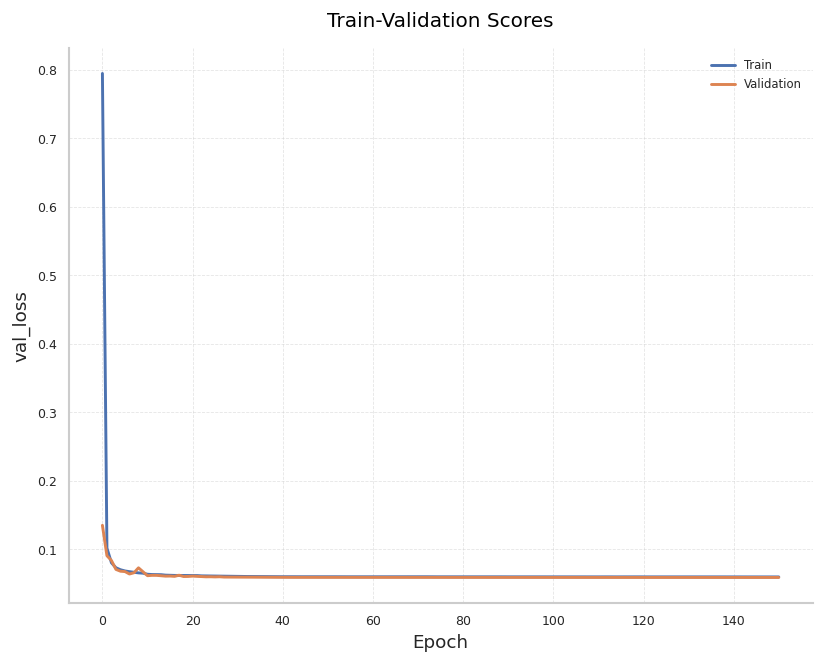

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 8 → Training set Score: 1.35992 | Validation set Score: 0.05881
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - dense_2_loss: 0.0000e+00 - loss: 1.7005 - msle: 82.8699 - rmsle: 1.6008 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.1443 - val_msle: 8.9900 - val_rmsle: 0.0962 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.1201 - msle: 5.2824 - rmsle: 0.0811 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0950 - val_msle: 4.6307 - val_rmsle: 0.0741 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_2_loss: 0.0000e+00 - loss: 0.0896 - msle: 4.7348 - rmsle: 0.0718 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0817 - val_msle: 4.5821 - val_rmsle: 0.0703 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_2_loss: 0.0000e+0

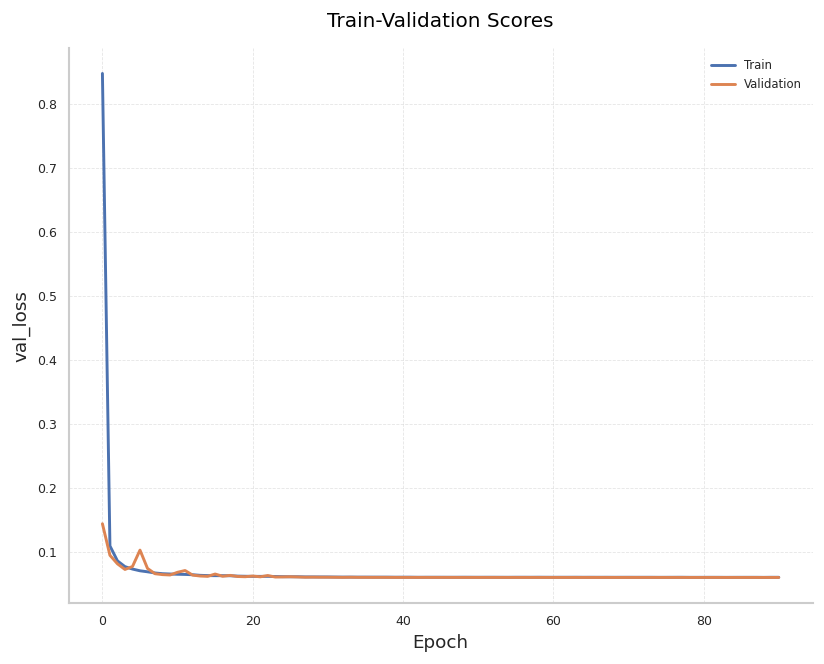

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 9 → Training set Score: 1.36178 | Validation set Score: 0.05984
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - dense_2_loss: 0.0000e+00 - loss: 1.6914 - msle: 81.3618 - rmsle: 1.5915 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.1352 - val_msle: 8.2391 - val_rmsle: 0.0869 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_2_loss: 0.0000e+00 - loss: 0.1146 - msle: 5.0849 - rmsle: 0.0760 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.1117 - val_msle: 8.6993 - val_rmsle: 0.0925 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.0864 - msle: 4.6686 - rmsle: 0.0701 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0838 - val_msle: 6.3903 - val_rmsle: 0.0740 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_2_loss: 0.0000e+0

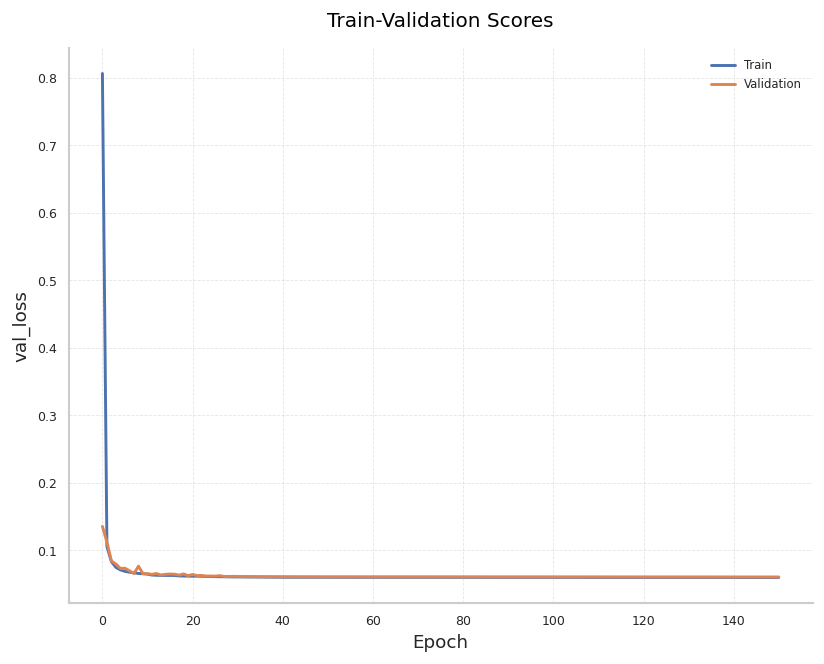

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 10 → Training set Score: 1.36185 | Validation set Score: 0.06018
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - dense_2_loss: 0.0000e+00 - loss: 1.6456 - msle: 82.1987 - rmsle: 1.5457 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.1310 - val_msle: 5.8879 - val_rmsle: 0.0814 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_2_loss: 0.0000e+00 - loss: 0.1182 - msle: 5.0844 - rmsle: 0.0778 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0908 - val_msle: 5.4652 - val_rmsle: 0.0696 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_2_loss: 0.0000e+00 - loss: 0.0882 - msle: 4.6468 - rmsle: 0.0702 - val_dense_2_loss: 0.0000e+00 - val_loss: 0.0840 - val_msle: 5.0898 - val_rmsle: 0.0728 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_2_loss: 0.0000e+

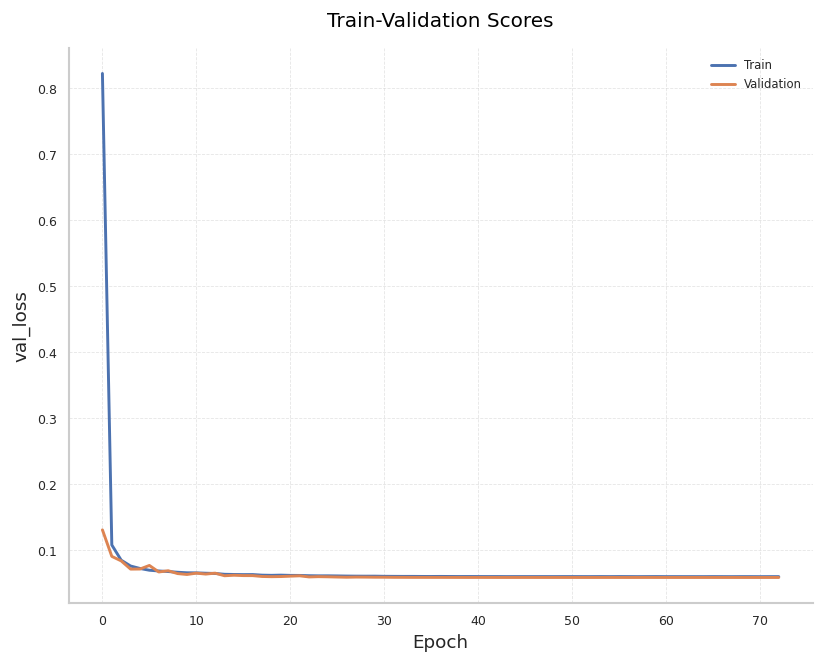

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 11 → Training set Score: 1.36027 | Validation set Score: 0.05840
Overall → Training set Score: 1.36106±0.0009041 | Validation set Score: 0.05931±0.0009912


In [30]:
TM.fit_model(name="NN_widedeepcross_01_v1")

#### 2.1.3 Store Results:

In [31]:
name_experiment = "NN_widedeepcross_01_v1"

train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred, columns = [f"{name_experiment}"])

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

In [32]:
test_pred.min(), test_pred.max()

(NN_widedeepcross_01_v1    1.082016
 dtype: float64,
 NN_widedeepcross_01_v1    315.000004
 dtype: float64)

In [33]:
test_pred.head()

,NN_widedeepcross_01_v1
0,27.436091
1,107.856932
2,86.680235
3,125.435101
4,76.097349


In [34]:
sub.head()

,Calories
id,
750000,27.436091
750001,107.856932
750002,86.680235
750003,125.435101
750004,76.097349


In [35]:
train_pred.head()

,NN_widedeepcross_01_v1
0,146.103577
1,35.882000
2,29.275066
3,138.257675
4,146.329620


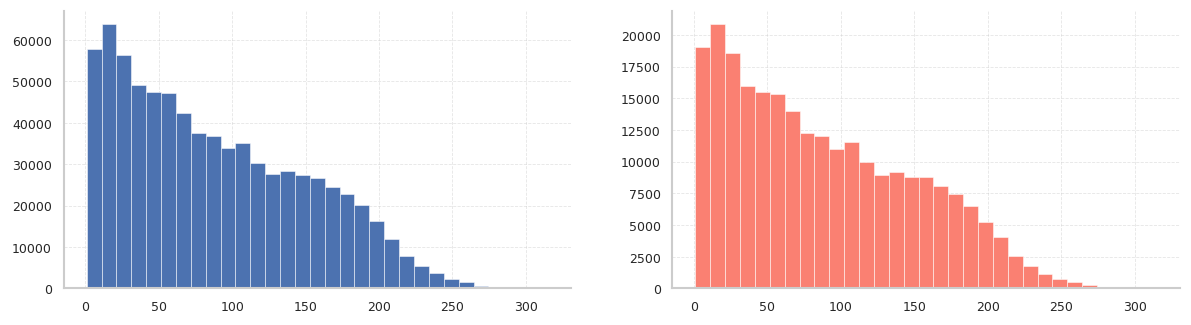

In [36]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [37]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

### **2.3.0 NeuralNetwork: TabTransformer Model v0**

This version of the model includes a Cross Layers within the Wide Branch of the NN.

In [40]:
from functools import partial

class CFG:
    SEED    = 333
    CV      = KFold(n_splits=11, shuffle=True, random_state=SEED)
    VERSION = '1'

class TrainModels:
    def __init__(self, X, y, X_test, test_finc_target, X_original, y_original, model_, parameters):
        self.model     = model_
        self.parameters = parameters
        self.X          = X
        self.y          = y
        self.test_finc_target = test_finc_target
        self.X_test     = X_test
        self._OOF_train = pd.DataFrame()
        self._OOF_test  = pd.DataFrame()
        self.categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
        self.numerical_features = X.select_dtypes(exclude=['category', 'bool', 'category','int']).columns.to_list()

    def fit_model(self, name="Base_model"):
        oof_train = np.zeros(self.X.shape[0])
        oof_test  = np.zeros(self.X_test.shape[0])
        scores_train = []
        scores_val   = []

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/layers_3_staked_models')

        train_start = 0

        for fold, (train_idx, val_idx) in enumerate(CFG.CV.split(self.X, self.y)):
            x_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            x_val,   y_val   = self.X.iloc[val_idx],   self.y.iloc[val_idx]


            train_ds = dataframe_to_dataset(x_train, y_train, self.categorical_features, self.numerical_features, shuffle=True, batch_size=1024)
            val_ds = dataframe_to_dataset(x_val, y_val, self.categorical_features, self.numerical_features, shuffle=False, batch_size=1024)
            test_ds = dataframe_to_dataset_test(self.X_test, self.test_finc_target, self.categorical_features, self.numerical_features, batch_size=1024)

            model = self.model(**self.parameters)

            optimizer = keras.optimizers.Adam(learning_rate=1e-3)
            model.compile(optimizer=optimizer,
                          loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                          metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

            checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
            model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                        filepath=checkpoint_filepath,
                                                                        save_weights_only=True,
                                                                        monitor='val_rmsle',
                                                                        mode='min',
                                                                        save_best_only=True
                                                                        )
            if fold >= train_start:
              # Fit the model
              history = model.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=151,
                                  batch_size=1024,
                                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6, monitor="val_rmsle", mode="min"),
                                            keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_rmsle",
                                                                            start_from_epoch=3, mode="min"),
                                              model_checkpoint_callback])

              model.load_weights(checkpoint_filepath)
              model.save(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/keras_models/{name}_{fold}.keras")
              plot_training_session(history)

            else:
              model = tf.keras.models.load_model(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/keras_models/{name}_{fold}.keras",
                                                custom_objects={'rmsle': rmsle})

            model.evaluate(val_ds, verbose=0)

            # Make predictions
            y_pred_train = model.predict(train_ds)
            y_pred_val   = model.predict(val_ds)
            y_pred_test  = model.predict(test_ds)

            # Correct Ranges:

            y_pred_train = np.maximum(y_pred_train, 1.0)
            y_pred_train = np.minimum(y_pred_train, 315.0)

            y_pred_val = np.maximum(y_pred_val, 1.0)
            y_pred_val = np.minimum(y_pred_val, 315.0)

            y_pred_test = np.maximum(y_pred_test, 1.0)
            y_pred_test = np.minimum(y_pred_test, 315.0)

            # Store Results
            oof_train[val_idx] = y_pred_val.reshape(-1)
            oof_test   += (y_pred_test/CFG.CV.get_n_splits()).reshape(-1)

            train_score = root_mean_squared_log_error(y_train, y_pred_train)
            val_score   = root_mean_squared_log_error(y_val, y_pred_val)

            print(f'Fold {fold+1} → Training set Score: {train_score:.5f} | Validation set Score: {val_score:.5f}')

            scores_train.append(train_score)
            scores_val.append(val_score)

        self._OOF_train[name] = oof_train
        self._OOF_test[name]  = oof_test

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5')

        print(colored(f'Overall → Training set Score: {np.mean(scores_train):.5f}±{np.std(scores_train):.7f} | Validation set Score: {np.mean(scores_val):.5f}±{np.std(scores_val):.7f}',
              color='green', attrs=['bold', 'dark']))

    @property
    def OOF_train(self):
        return self._OOF_train
    @property
    def OOF_test(self):
        return self._OOF_test

    def save_predictions(self):
        self._OOF_train.to_csv('OOF_train_many_models.csv', index=False)
        self._OOF_test.to_csv('OOF_test_many_models.csv', index=False)

In [19]:
data.X.sample(3)

,Sex,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity,Intensity_v1,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,BMR,Age_Group
661355,1,1.579790,1.775038,0.428189,0.689273,0.979607,1.272439,0.436337,0.067056,-0.529277,1.049299,0,0.456487,1.788266,2
106955,1,0.490648,0.989555,-0.768927,-0.686029,-0.687354,1.846389,-0.802436,0.031395,0.327138,-0.595330,0,-0.252903,0.172932,5
1009,1,1.501994,1.989261,1.505592,0.900858,1.236062,1.979280,1.489432,-0.867625,-1.009468,2.474104,0,1.050542,1.758197,3


In [20]:
data.X.max(axis=0)

,0
Sex,1.000000
Height,3.680276
Weight,4.060081
Duration,1.745015
Heart_Rate,3.439877
Body_Temp,1.877201
BMI,5.000000
Intensity,2.483148
Intensity_v1,8.631268
Heart_Duration,4.005130


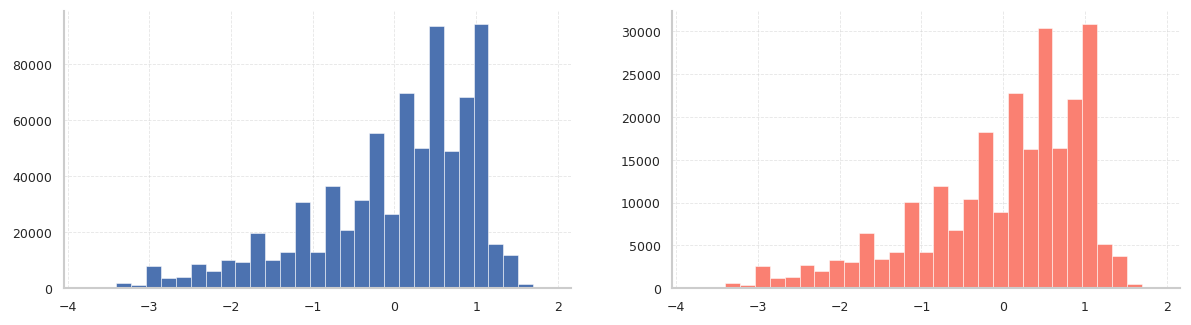

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(data.X.Body_Temp, bins=31)
ax[1].hist(data.X_test.Body_Temp, bins=31, color="salmon")

plt.show()

In [22]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]


print(cat_features,cat_features_card)
print(num_features)

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group'] [2, 2, 8]
['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Intensity', 'Intensity_v1', 'Heart_Duration', 'Weight_Duration_Heart', 'BMI_Age', 'BMR']


In [23]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer())
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

In [24]:
[4]*2+[2]

[4, 4, 2]

In [25]:
def tabtransformer(do_rate=0.25, num_cross_layers=2, embedding_dims=4, num_transformer_blocks=3, num_heads=8, mlp_hidden_units_factors=[4]*2+[2]):
    '''
    In this model embedding is performed for the data feeding into both the Deep and and wide layers:
    '''

    x_input_cats = layers.Input(shape=(len(cat_features),))
    x_input_nums = layers.Input(shape=(len(num_features),))



    # Embedding Cat Features
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], embedding_dims) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        embs.append(x)

    encoded_categorical_features = ops.stack(embs, axis=1)


    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=do_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=do_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(layers.LayerNormalization, epsilon=1e-6),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(x_input_nums)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features], name="concatenate_att_output")

    # Compute MLP hidden_units.
    mlp_hidden_units = [factor * features.shape[-1] for factor in mlp_hidden_units_factors]
    # Create final MLP.
    features = create_mlp(
                          hidden_units=mlp_hidden_units,
                          dropout_rate=do_rate,
                          activation=keras.activations.silu,
                          normalization_layer=layers.BatchNormalization,
                          name="MLP_post_attention",
                         )(features)

    # WIDE Branch of the NN
    embs_cross = []

    for j in embs:
        embs_cross.append(layers.Flatten()(j))

#    embs_cross = layers.Flatten()(embs)
    x1 = layers.Concatenate(axis=-1)(embs_cross+[x_input_nums])

    wide = x1  # Both Branches start with the concatenated features

    # Wide Branch with Cross Layers:
    for _ in range(num_cross_layers):
        xl = layers.Dense(units=x1.shape[-1],  # Output dimension same as input
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros',
                         activation=None)(wide)  # Linear activation
        # Cross Layer Calculation:
        cross = layers.Multiply()([x1, xl])  # Element-wise multiplication
        # Concatenate instead of Add:
        wide = layers.Concatenate(axis=-1)([wide, cross])


    merged = layers.concatenate([wide, features])

    x_final = layers.Dense(1, activation='linear')(merged)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [26]:
mod_test = tabtransformer()
mod_test.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None)            │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None)            │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None)            │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4)         │          8 │ get_item[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 4)         │          8 │ get_item_1[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 4)         │         32 │ get_item_2[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 3, 4)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding_1[0][0… │
│                     │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attentio… │ (None, 3, 4)      │        612 │ stack[0][0],      │
│ (MultiHeadAttentio… │                   │            │ stack[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection1_0  │ (None, 3, 4)      │          0 │ multihead_attent… │
│ (Add)               │                   │            │ stack[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm1_0       │ (None, 3, 4)      │          8 │ skip_connection1… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feedforward_0       │ (None, 3, 4)      │         28 │ layer_norm1_0[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection2_0  │ (None, 3, 4)      │          0 │ feedforward_0[0]… │
│ (Add)               │                   │            │ layer_norm1_0[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm2_0       │ (None, 3, 4)      │          8 │ skip_connection2… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attentio… │ (None, 3, 4)      │        612 │ layer_norm2_0[0]… │
│ (MultiHeadAttentio… │                   │            │ layer_norm2_0[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection1_1  │ (None, 3, 4)      │          0 │ multihead_attent… │
│ (Add)               │                   │            │ layer_norm2_0[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm1_1       │ (None, 3, 4)      │          8 │ skip_connection1

 Total params: 21,169 (82.69 KB)

 Trainable params: 20,737 (81.00 KB)

 Non-trainable params: 432 (1.69 KB)

In [27]:
#keras.utils.plot_model(mod_test, show_shapes=True, rankdir="LR")

#### 2.3.1 Optuna Optimization:

In [28]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 3 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   Sex                           765000 non-null  int64
 1   Outliers_Duration_Heart_Temp  765000 non-null  int64
 2   Age_Group                     765000 non-null  int64
dtypes: int64(3)
memory usage: 23.3 MB
<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Height                 765000 non-null  float64
 1   Weight                 765000 non-null  float64
 2   Duration               765000 non-null  float64
 3   Heart_Rate             765000 non-null  float64
 4   Body_Temp              765000 non-null  float64
 5   BMI                    765000 non-null  float64
 6   Intensity              765000

In [29]:
y_fin.isna().sum()

,0
Calories,0


**OPTIMIZATION SECTION**

  1. Trial 3 finished with value: 0.06128411016249404 and parameters: {'num_cross_layers': 3, 'do_rate': 0.34650500123999023, 'embedding_dims': 4, 'num_transformer_blocks': 3, 'num_heads': 4, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}

  2. rial 22 finished with value: 0.06113841138214773 and parameters: {'num_cross_layers': 3, 'do_rate': 0.3631276829855239, 'embedding_dims': 4, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 1}.

  3. Trial 7 finished with value: 0.060843740984653075 and parameters: {'do_rate': 0.32, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 1}

In [30]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=tabtransformer, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

#(num_transformer_blocks=3, num_heads=8, mlp_hidden_units_factors=[4]*2+[2])

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'num_cross_layers': trial.suggest_int('num_cross_layers', 1, 3), #trial.suggest_int('num_cross_layers', 1, 3),
              'do_rate': trial.suggest_float('do_rate', 0.30, 0.40, step=0.01),
              'embedding_dims': trial.suggest_categorical('embedding_dims', [4, 8]),
              'num_transformer_blocks': trial.suggest_categorical('num_transformer_blocks', [2, 3, 4]),
              'num_heads': trial.suggest_categorical('num_heads', [4, 8, 12]),
              'mlp_hidden_units_factors_0' : trial.suggest_categorical('mlp_hidden_units_factors_0', [2, 3]),
              'mlp_hidden_units_factors_1' : trial.suggest_categorical('mlp_hidden_units_factors_1', [2, 3]),
              'mlp_hidden_units_factors_2' : trial.suggest_categorical('mlp_hidden_units_factors_2', [1, 2]),
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(do_rate=params["do_rate"], num_cross_layers=params["num_cross_layers"], embedding_dims=params["embedding_dims"], num_transformer_blocks=params["num_transformer_blocks"],
                            num_heads=params["num_heads"], mlp_hidden_units_factors=[params["mlp_hidden_units_factors_0"]]*params["mlp_hidden_units_factors_1"]+[params["mlp_hidden_units_factors_2"]])

        optimizer = keras.optimizers.Adam(learning_rate=1e-3)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint_dwc.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=31,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [31]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [32]:
X_fin.isna().sum(), y_fin.min()

(Sex                             0
 Height                          0
 Weight                          0
 Duration                        0
 Heart_Rate                      0
 Body_Temp                       0
 BMI                             0
 Intensity                       0
 Intensity_v1                    0
 Heart_Duration                  0
 Weight_Duration_Heart           0
 Outliers_Duration_Heart_Temp    0
 BMI_Age                         0
 BMR                             0
 Age_Group                       0
 dtype: int64,
 Calories    1.0
 dtype: float64)

In [ ]:
nn3_study = tune_hyperparameters(X_fin, y_fin, model_class=tabtransformer, n_trials=27, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn3_study.best_params

[I 2025-05-21 15:10:50,994] A new study created in memory with name: no-name-64dbf3f2-31b9-405e-93f0-9ffd9caa444f


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - dense_10_loss: 0.0000e+00 - loss: 1.4823 - msle: 73.3320 - rmsle: 1.4823 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0823 - val_msle: 7.4633 - val_rmsle: 0.0822 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0983 - msle: 8.5258 - rmsle: 0.0983 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0657 - val_msle: 4.5446 - val_rmsle: 0.0656 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0697 - msle: 5.1564 - rmsle: 0.0697 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0631 - val_msle: 4.0980 - val_rmsle: 0.0630 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0650 - msle: 4.3995 - rmsle: 0.0650 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0620 - val_msle: 3.9333 - val_rmsle: 0.0619 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━

[I 2025-05-21 15:26:05,051] Trial 0 finished with value: 0.059878779115217606 and parameters: {'num_cross_layers': 3, 'do_rate': 0.31, 'embedding_dims': 8, 'num_transformer_blocks': 3, 'num_heads': 4, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}. Best is trial 0 with value: 0.059878779115217606.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - dense_9_loss: 0.0000e+00 - loss: 1.7502 - msle: 81.8644 - rmsle: 1.7502 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.1095 - val_msle: 9.7978 - val_rmsle: 0.1095 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.2320 - msle: 23.1642 - rmsle: 0.2320 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0905 - val_msle: 6.1333 - val_rmsle: 0.0905 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.1538 - msle: 17.1199 - rmsle: 0.1538 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0738 - val_msle: 5.1561 - val_rmsle: 0.0737 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.1077 - msle: 11.7846 - rmsle: 0.1077 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0688 - val_msle: 4.7519 - val_rmsle: 0.0687 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━

[I 2025-05-21 15:42:48,665] Trial 1 finished with value: 0.061611493020728936 and parameters: {'num_cross_layers': 1, 'do_rate': 0.32999999999999996, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 8, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}. Best is trial 0 with value: 0.059878779115217606.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 49s 36ms/step - dense_10_loss: 0.0000e+00 - loss: 1.5609 - msle: 73.6939 - rmsle: 1.5609 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0774 - val_msle: 6.2920 - val_rmsle: 0.0774 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0827 - msle: 6.6062 - rmsle: 0.0827 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0651 - val_msle: 4.5399 - val_rmsle: 0.0650 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0681 - msle: 4.7746 - rmsle: 0.0681 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0638 - val_msle: 4.2562 - val_rmsle: 0.0637 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0649 - msle: 4.3275 - rmsle: 0.0649 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0624 - val_msle: 4.0937 - val_rmsle: 0.0623 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━

[I 2025-05-21 16:00:56,738] Trial 2 finished with value: 0.05982521059155027 and parameters: {'num_cross_layers': 3, 'do_rate': 0.37, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 2}. Best is trial 2 with value: 0.05982521059155027.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - dense_9_loss: 0.0000e+00 - loss: 1.8808 - msle: 80.0249 - rmsle: 1.8808 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0805 - val_msle: 6.8714 - val_rmsle: 0.0805 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0890 - msle: 7.5276 - rmsle: 0.0890 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0662 - val_msle: 4.4843 - val_rmsle: 0.0661 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0708 - msle: 5.1417 - rmsle: 0.0708 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0635 - val_msle: 4.1536 - val_rmsle: 0.0634 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0662 - msle: 4.4749 - rmsle: 0.0662 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0629 - val_msle: 4.0264 - val_rmsle: 0.0628 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━━━

[I 2025-05-21 16:13:44,274] Trial 3 finished with value: 0.05983979952382459 and parameters: {'num_cross_layers': 3, 'do_rate': 0.33999999999999997, 'embedding_dims': 4, 'num_transformer_blocks': 2, 'num_heads': 4, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 1}. Best is trial 2 with value: 0.05982521059155027.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - dense_9_loss: 0.0000e+00 - loss: 2.1150 - msle: 87.0181 - rmsle: 2.1150 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.1203 - val_msle: 7.9948 - val_rmsle: 0.1203 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.1747 - msle: 14.7519 - rmsle: 0.1747 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0743 - val_msle: 5.7268 - val_rmsle: 0.0742 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.1004 - msle: 8.2396 - rmsle: 0.1004 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0713 - val_msle: 4.7816 - val_rmsle: 0.0713 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0780 - msle: 5.8531 - rmsle: 0.0780 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0689 - val_msle: 4.5031 - val_rmsle: 0.0688 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━━

[I 2025-05-21 16:29:01,814] Trial 4 finished with value: 0.060807860063784316 and parameters: {'num_cross_layers': 2, 'do_rate': 0.33999999999999997, 'embedding_dims': 4, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}. Best is trial 2 with value: 0.05982521059155027.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - dense_9_loss: 0.0000e+00 - loss: 1.7409 - msle: 81.9858 - rmsle: 1.7409 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.1175 - val_msle: 10.3682 - val_rmsle: 0.1175 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.1941 - msle: 18.5892 - rmsle: 0.1941 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0801 - val_msle: 5.5400 - val_rmsle: 0.0800 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.1070 - msle: 9.8804 - rmsle: 0.1070 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0674 - val_msle: 4.6007 - val_rmsle: 0.0673 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0759 - msle: 5.7963 - rmsle: 0.0759 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0666 - val_msle: 4.4073 - val_rmsle: 0.0665 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━

[I 2025-05-21 16:45:33,064] Trial 5 finished with value: 0.06066720183882823 and parameters: {'num_cross_layers': 2, 'do_rate': 0.33999999999999997, 'embedding_dims': 4, 'num_transformer_blocks': 4, 'num_heads': 4, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 2}. Best is trial 2 with value: 0.05982521059155027.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - dense_9_loss: 0.0000e+00 - loss: 1.9471 - msle: 83.5676 - rmsle: 1.9471 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.1226 - val_msle: 8.1917 - val_rmsle: 0.1225 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.2171 - msle: 20.6755 - rmsle: 0.2171 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0912 - val_msle: 7.2905 - val_rmsle: 0.0911 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.1514 - msle: 14.5135 - rmsle: 0.1514 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0696 - val_msle: 5.1860 - val_rmsle: 0.0695 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0854 - msle: 7.1268 - rmsle: 0.0854 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0669 - val_msle: 4.5685 - val_rmsle: 0.0668 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━

[I 2025-05-21 17:00:29,145] Trial 6 finished with value: 0.06055744747446392 and parameters: {'num_cross_layers': 2, 'do_rate': 0.37, 'embedding_dims': 4, 'num_transformer_blocks': 3, 'num_heads': 4, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}. Best is trial 2 with value: 0.05982521059155027.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - dense_9_loss: 0.0000e+00 - loss: 1.8222 - msle: 80.0782 - rmsle: 1.8222 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.1033 - val_msle: 6.3768 - val_rmsle: 0.1032 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.1735 - msle: 16.8286 - rmsle: 0.1735 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0715 - val_msle: 5.7830 - val_rmsle: 0.0714 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0904 - msle: 8.0787 - rmsle: 0.0904 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0667 - val_msle: 4.6303 - val_rmsle: 0.0666 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0729 - msle: 5.5768 - rmsle: 0.0729 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0648 - val_msle: 4.3462 - val_rmsle: 0.0647 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━━

[I 2025-05-21 17:16:00,178] Trial 7 finished with value: 0.0606598089844186 and parameters: {'num_cross_layers': 2, 'do_rate': 0.4, 'embedding_dims': 8, 'num_transformer_blocks': 3, 'num_heads': 8, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}. Best is trial 2 with value: 0.05982521059155027.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - dense_9_loss: 0.0000e+00 - loss: 1.7301 - msle: 81.5075 - rmsle: 1.7301 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.1603 - val_msle: 15.5969 - val_rmsle: 0.1603 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.2447 - msle: 23.7973 - rmsle: 0.2447 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.1105 - val_msle: 12.2368 - val_rmsle: 0.1105 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.1903 - msle: 20.2331 - rmsle: 0.1903 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0875 - val_msle: 7.3159 - val_rmsle: 0.0875 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.1591 - msle: 17.5521 - rmsle: 0.1591 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0759 - val_msle: 5.1840 - val_rmsle: 0.0759 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━

[I 2025-05-21 17:33:10,284] Trial 8 finished with value: 0.06160112752115395 and parameters: {'num_cross_layers': 1, 'do_rate': 0.32, 'embedding_dims': 4, 'num_transformer_blocks': 4, 'num_heads': 8, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}. Best is trial 2 with value: 0.05982521059155027.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - dense_11_loss: 0.0000e+00 - loss: 1.5926 - msle: 75.2441 - rmsle: 1.5926 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0901 - val_msle: 7.5589 - val_rmsle: 0.0901 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0998 - msle: 8.6768 - rmsle: 0.0998 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0654 - val_msle: 4.5796 - val_rmsle: 0.0654 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0708 - msle: 5.1210 - rmsle: 0.0708 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0627 - val_msle: 4.1149 - val_rmsle: 0.0626 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0656 - msle: 4.4203 - rmsle: 0.0656 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0617 - val_msle: 3.9829 - val_rmsle: 0.0616 - learning_rate: 0.0010
Epoch 5/31
598/598 

[I 2025-05-21 17:52:07,137] Trial 9 finished with value: 0.05979389171752442 and parameters: {'num_cross_layers': 3, 'do_rate': 0.31, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}. Best is trial 9 with value: 0.05979389171752442.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - dense_8_loss: 0.0000e+00 - loss: 1.6490 - msle: 75.3801 - rmsle: 1.6490 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0755 - val_msle: 6.0327 - val_rmsle: 0.0754 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_8_loss: 0.0000e+00 - loss: 0.0799 - msle: 6.3015 - rmsle: 0.0799 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0642 - val_msle: 4.1804 - val_rmsle: 0.0640 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_8_loss: 0.0000e+00 - loss: 0.0668 - msle: 4.6165 - rmsle: 0.0668 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0622 - val_msle: 3.9463 - val_rmsle: 0.0620 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_8_loss: 0.0000e+00 - loss: 0.0640 - msle: 4.2210 - rmsle: 0.0640 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0612 - val_msle: 3.8606 - val_rmsle: 0.0611 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━━━

[I 2025-05-21 18:05:13,000] Trial 10 finished with value: 0.06016227338816267 and parameters: {'num_cross_layers': 3, 'do_rate': 0.3, 'embedding_dims': 8, 'num_transformer_blocks': 2, 'num_heads': 12, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 1}. Best is trial 9 with value: 0.05979389171752442.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 49s 36ms/step - dense_10_loss: 0.0000e+00 - loss: 1.6575 - msle: 74.9893 - rmsle: 1.6575 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0757 - val_msle: 6.1491 - val_rmsle: 0.0757 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0783 - msle: 6.1858 - rmsle: 0.0783 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0644 - val_msle: 4.3512 - val_rmsle: 0.0643 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0668 - msle: 4.5395 - rmsle: 0.0668 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0626 - val_msle: 4.1221 - val_rmsle: 0.0625 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0644 - msle: 4.2260 - rmsle: 0.0644 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0619 - val_msle: 4.0239 - val_rmsle: 0.0618 - learning_rate: 0.0010
Epoch 5/31
598/598 ━

[I 2025-05-21 18:23:39,596] Trial 11 finished with value: 0.059851689072265554 and parameters: {'num_cross_layers': 3, 'do_rate': 0.37, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 1}. Best is trial 9 with value: 0.05979389171752442.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - dense_10_loss: 0.0000e+00 - loss: 1.5624 - msle: 73.7517 - rmsle: 1.5624 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0787 - val_msle: 6.5354 - val_rmsle: 0.0787 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0841 - msle: 6.8386 - rmsle: 0.0841 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0653 - val_msle: 4.6383 - val_rmsle: 0.0652 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0682 - msle: 4.7922 - rmsle: 0.0682 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0639 - val_msle: 4.2849 - val_rmsle: 0.0638 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0649 - msle: 4.3239 - rmsle: 0.0649 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0624 - val_msle: 4.1201 - val_rmsle: 0.0623 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━

[I 2025-05-21 18:42:12,148] Trial 12 finished with value: 0.05982762348027174 and parameters: {'num_cross_layers': 3, 'do_rate': 0.37, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 2}. Best is trial 9 with value: 0.05979389171752442.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - dense_10_loss: 0.0000e+00 - loss: 1.5861 - msle: 74.5161 - rmsle: 1.5861 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0800 - val_msle: 6.5871 - val_rmsle: 0.0799 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0848 - msle: 6.9274 - rmsle: 0.0848 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0661 - val_msle: 4.5631 - val_rmsle: 0.0660 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0683 - msle: 4.8048 - rmsle: 0.0683 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0632 - val_msle: 4.2492 - val_rmsle: 0.0631 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0650 - msle: 4.3357 - rmsle: 0.0650 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0620 - val_msle: 4.0610 - val_rmsle: 0.0618 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━

[I 2025-05-21 19:00:44,381] Trial 13 finished with value: 0.05982537830548512 and parameters: {'num_cross_layers': 3, 'do_rate': 0.39, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 2}. Best is trial 9 with value: 0.05979389171752442.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - dense_10_loss: 0.0000e+00 - loss: 1.6355 - msle: 74.1006 - rmsle: 1.6355 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0740 - val_msle: 5.7854 - val_rmsle: 0.0739 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0761 - msle: 5.7906 - rmsle: 0.0761 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0640 - val_msle: 4.3335 - val_rmsle: 0.0639 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0664 - msle: 4.4986 - rmsle: 0.0664 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0627 - val_msle: 4.1068 - val_rmsle: 0.0626 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0642 - msle: 4.1897 - rmsle: 0.0642 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0620 - val_msle: 4.0228 - val_rmsle: 0.0619 - learning_rate: 0.0010
Epoch 5/31
598/598 ━

[I 2025-05-21 19:19:16,982] Trial 14 finished with value: 0.060000203236126315 and parameters: {'num_cross_layers': 3, 'do_rate': 0.36, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 1}. Best is trial 9 with value: 0.05979389171752442.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - dense_9_loss: 0.0000e+00 - loss: 1.6463 - msle: 79.4017 - rmsle: 1.6463 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0930 - val_msle: 7.3712 - val_rmsle: 0.0929 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - dense_9_loss: 0.0000e+00 - loss: 0.1013 - msle: 8.8616 - rmsle: 0.1013 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0695 - val_msle: 5.1284 - val_rmsle: 0.0694 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0727 - msle: 5.4405 - rmsle: 0.0727 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0672 - val_msle: 4.7585 - val_rmsle: 0.0671 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0687 - msle: 4.9219 - rmsle: 0.0687 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0655 - val_msle: 4.6261 - val_rmsle: 0.0654 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━

[I 2025-05-21 19:37:51,576] Trial 15 finished with value: 0.06090218171441476 and parameters: {'num_cross_layers': 2, 'do_rate': 0.38, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 2}. Best is trial 9 with value: 0.05979389171752442.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - dense_8_loss: 0.0000e+00 - loss: 1.5654 - msle: 73.7854 - rmsle: 1.5654 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0806 - val_msle: 6.5198 - val_rmsle: 0.0805 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_8_loss: 0.0000e+00 - loss: 0.0866 - msle: 7.0804 - rmsle: 0.0866 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0643 - val_msle: 4.3481 - val_rmsle: 0.0642 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_8_loss: 0.0000e+00 - loss: 0.0682 - msle: 4.7596 - rmsle: 0.0682 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0626 - val_msle: 4.0988 - val_rmsle: 0.0625 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_8_loss: 0.0000e+00 - loss: 0.0648 - msle: 4.2836 - rmsle: 0.0648 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0619 - val_msle: 3.9936 - val_rmsle: 0.0618 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━━━

[I 2025-05-21 19:51:37,356] Trial 16 finished with value: 0.059830557461790036 and parameters: {'num_cross_layers': 3, 'do_rate': 0.3, 'embedding_dims': 8, 'num_transformer_blocks': 2, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 2}. Best is trial 9 with value: 0.05979389171752442.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 50s 36ms/step - dense_9_loss: 0.0000e+00 - loss: 1.7100 - msle: 81.4258 - rmsle: 1.7100 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.1358 - val_msle: 13.4415 - val_rmsle: 0.1358 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_9_loss: 0.0000e+00 - loss: 0.2437 - msle: 26.4206 - rmsle: 0.2437 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0916 - val_msle: 7.4902 - val_rmsle: 0.0915 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_9_loss: 0.0000e+00 - loss: 0.1494 - msle: 17.7432 - rmsle: 0.1494 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0765 - val_msle: 5.3127 - val_rmsle: 0.0765 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0961 - msle: 10.8056 - rmsle: 0.0961 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0728 - val_msle: 4.8168 - val_rmsle: 0.0727 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━

[I 2025-05-21 20:10:21,524] Trial 17 finished with value: 0.06206510963587232 and parameters: {'num_cross_layers': 1, 'do_rate': 0.36, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}. Best is trial 9 with value: 0.05979389171752442.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - dense_11_loss: 0.0000e+00 - loss: 1.5495 - msle: 74.3499 - rmsle: 1.5495 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0747 - val_msle: 5.8513 - val_rmsle: 0.0747 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0817 - msle: 6.6010 - rmsle: 0.0817 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0659 - val_msle: 4.4169 - val_rmsle: 0.0658 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0682 - msle: 4.7456 - rmsle: 0.0682 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0637 - val_msle: 4.1640 - val_rmsle: 0.0635 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0652 - msle: 4.3085 - rmsle: 0.0652 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0626 - val_msle: 4.0513 - val_rmsle: 0.0625 - learning_rate: 0.0010
Epoch 5/31
598/598

[I 2025-05-21 20:30:35,686] Trial 18 finished with value: 0.05973127449219382 and parameters: {'num_cross_layers': 3, 'do_rate': 0.32, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 1}. Best is trial 18 with value: 0.05973127449219382.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - dense_8_loss: 0.0000e+00 - loss: 1.5786 - msle: 79.3529 - rmsle: 1.5786 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0919 - val_msle: 5.7253 - val_rmsle: 0.0918 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_8_loss: 0.0000e+00 - loss: 0.1032 - msle: 9.2527 - rmsle: 0.1032 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0655 - val_msle: 4.3116 - val_rmsle: 0.0655 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_8_loss: 0.0000e+00 - loss: 0.0703 - msle: 5.1951 - rmsle: 0.0703 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0643 - val_msle: 4.2006 - val_rmsle: 0.0642 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_8_loss: 0.0000e+00 - loss: 0.0674 - msle: 4.8591 - rmsle: 0.0674 - val_dense_8_loss: 0.0000e+00 - val_loss: 0.0630 - val_msle: 4.1125 - val_rmsle: 0.0628 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━━━

[I 2025-05-21 20:44:35,408] Trial 19 finished with value: 0.06032666954762873 and parameters: {'num_cross_layers': 2, 'do_rate': 0.32, 'embedding_dims': 8, 'num_transformer_blocks': 2, 'num_heads': 8, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 1}. Best is trial 18 with value: 0.05973127449219382.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 50s 37ms/step - dense_11_loss: 0.0000e+00 - loss: 1.5448 - msle: 74.2561 - rmsle: 1.5448 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0751 - val_msle: 5.9768 - val_rmsle: 0.0751 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0838 - msle: 6.8440 - rmsle: 0.0838 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0656 - val_msle: 4.4059 - val_rmsle: 0.0655 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0684 - msle: 4.7611 - rmsle: 0.0684 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0637 - val_msle: 4.1520 - val_rmsle: 0.0636 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0653 - msle: 4.3007 - rmsle: 0.0653 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0627 - val_msle: 4.0375 - val_rmsle: 0.0625 - learning_rate: 0.0010
Epoch 5/31
598/598

In [ ]:
cat_params

  1. Trial 18 finished with value: 0.05973127449219382 and parameters: {'num_cross_layers': 3, 'do_rate': 0.32, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 1}. Best is trial 18 with value: 0.05973127449219382.

  2. Trial 9 finished with value: 0.05979389171752442 and parameters: {'num_cross_layers': 3, 'do_rate': 0.31, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}

In [ ]:
a=3, b=3, c=1
 [a]*b+[c]

In [30]:
[3]*3+[1]

[3, 3, 3, 1]

#### 2.1.2 Train Model:

In [41]:
param =   {'num_cross_layers': 3, 'do_rate': 0.32, 'embedding_dims': 8, 'num_transformer_blocks': 4, 'num_heads': 12,  'mlp_hidden_units_factors': [3, 3, 3, 1]}

In [42]:
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=tabtransformer, parameters=param)

Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - dense_68_loss: 0.0000e+00 - loss: 1.3132 - msle: 69.4144 - rmsle: 1.3132 - val_dense_68_loss: 0.0000e+00 - val_loss: 0.0716 - val_msle: 5.1747 - val_rmsle: 0.0716 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_68_loss: 0.0000e+00 - loss: 0.0771 - msle: 6.0422 - rmsle: 0.0771 - val_dense_68_loss: 0.0000e+00 - val_loss: 0.0664 - val_msle: 4.5123 - val_rmsle: 0.0664 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_68_loss: 0.0000e+00 - loss: 0.0655 - msle: 4.4750 - rmsle: 0.0655 - val_dense_68_loss: 0.0000e+00 - val_loss: 0.0628 - val_msle: 4.1213 - val_rmsle: 0.0628 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_68_loss: 0.0000e+00 - loss: 0.0638 - msle: 4.2057 - rmsle: 0.0638 - val_dense_68_loss: 0.0000e+00 - val_loss: 0.0620 - val_msle: 3.9173 - val_rmsle: 0.0619 - learning_rate: 0.0010
Epoch 5/151
680/680 ━━━━━━━━━━━━━

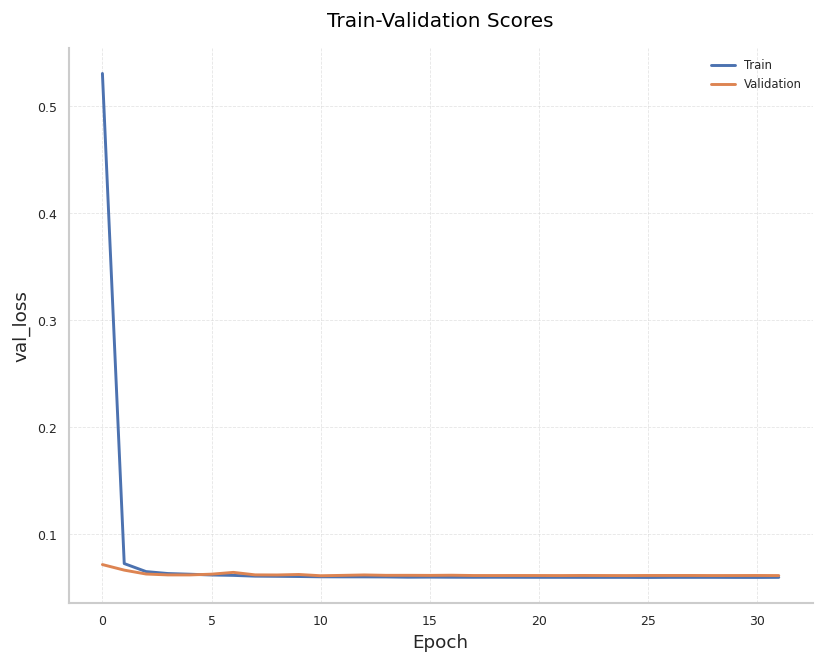

680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Fold 1 → Training set Score: 1.36183 | Validation set Score: 0.06273
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 51s 31ms/step - dense_80_loss: 0.0000e+00 - loss: 1.4752 - msle: 71.0830 - rmsle: 1.4752 - val_dense_80_loss: 0.0000e+00 - val_loss: 0.0767 - val_msle: 6.2856 - val_rmsle: 0.0767 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_80_loss: 0.0000e+00 - loss: 0.0859 - msle: 7.0768 - rmsle: 0.0859 - val_dense_80_loss: 0.0000e+00 - val_loss: 0.0659 - val_msle: 4.4026 - val_rmsle: 0.0659 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_80_loss: 0.0000e+00 - loss: 0.0673 - msle: 4.8008 - rmsle: 0.0673 - val_dense_80_loss: 0.0000e+00 - val_loss: 0.0645 - val_msle: 4.1053 - val_rmsle: 0.0644 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_80_loss: 0.0000e+00 - 

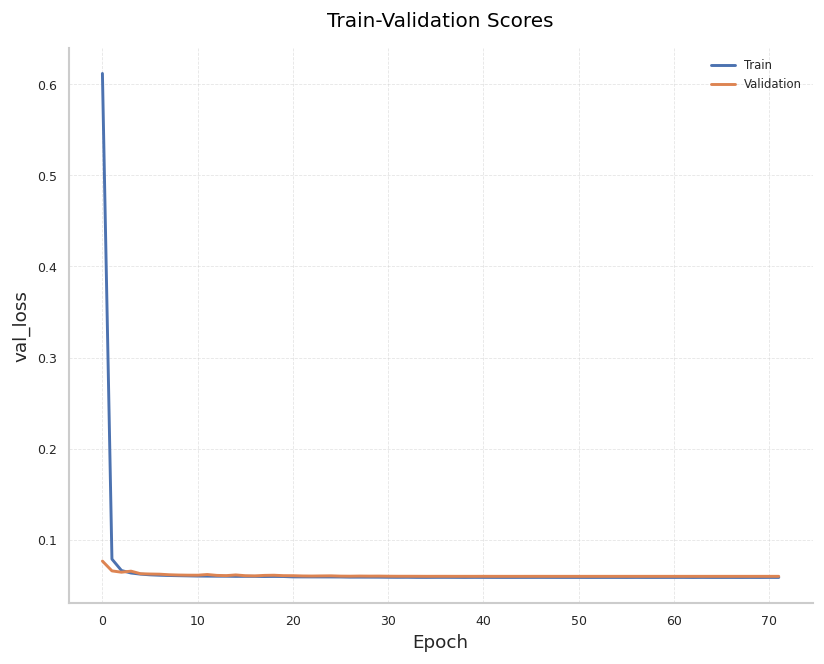

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Fold 2 → Training set Score: 1.35898 | Validation set Score: 0.06073
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 52s 32ms/step - dense_92_loss: 0.0000e+00 - loss: 1.3537 - msle: 70.4406 - rmsle: 1.3537 - val_dense_92_loss: 0.0000e+00 - val_loss: 0.0717 - val_msle: 5.1838 - val_rmsle: 0.0716 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - dense_92_loss: 0.0000e+00 - loss: 0.0780 - msle: 5.9155 - rmsle: 0.0780 - val_dense_92_loss: 0.0000e+00 - val_loss: 0.0641 - val_msle: 4.1770 - val_rmsle: 0.0640 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_92_loss: 0.0000e+00 - loss: 0.0672 - msle: 4.5892 - rmsle: 0.0672 - val_dense_92_loss: 0.0000e+00 - val_loss: 0.0620 - val_msle: 3.9343 - val_rmsle: 0.0619 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_92_loss: 0.0000e+00 - 

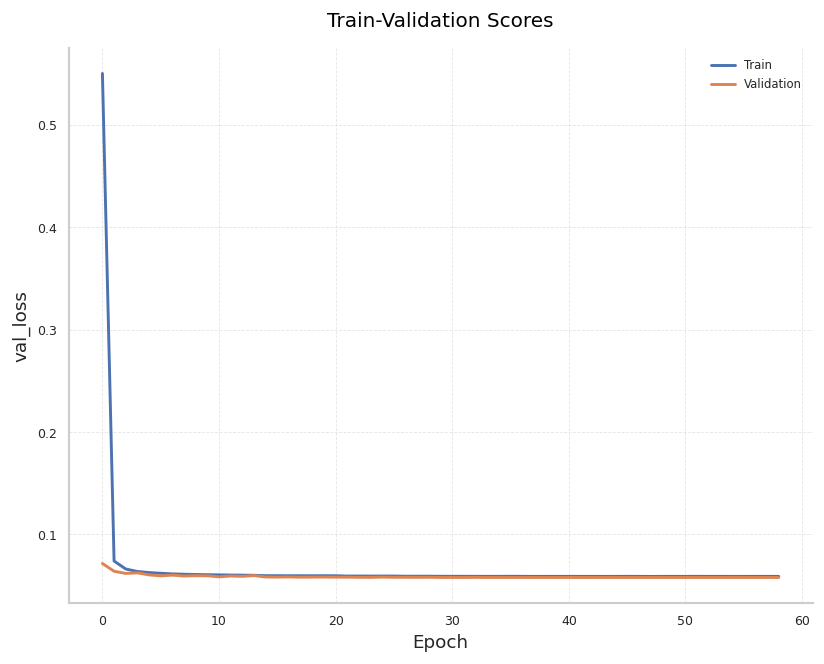

680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 3 → Training set Score: 1.36141 | Validation set Score: 0.05858
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 52s 31ms/step - dense_104_loss: 0.0000e+00 - loss: 1.4092 - msle: 71.1971 - rmsle: 1.4092 - val_dense_104_loss: 0.0000e+00 - val_loss: 0.0788 - val_msle: 5.3029 - val_rmsle: 0.0788 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - dense_104_loss: 0.0000e+00 - loss: 0.0775 - msle: 5.9560 - rmsle: 0.0775 - val_dense_104_loss: 0.0000e+00 - val_loss: 0.0680 - val_msle: 4.3631 - val_rmsle: 0.0680 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_104_loss: 0.0000e+00 - loss: 0.0669 - msle: 4.6669 - rmsle: 0.0669 - val_dense_104_loss: 0.0000e+00 - val_loss: 0.0682 - val_msle: 4.1262 - val_rmsle: 0.0681 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - dense_104_loss: 0.0000

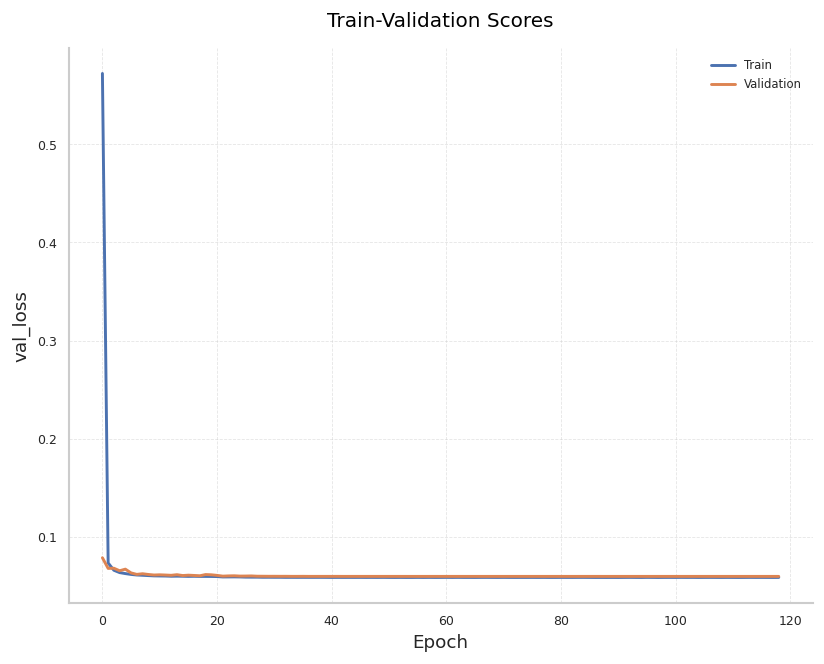

680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 4 → Training set Score: 1.36190 | Validation set Score: 0.06072
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - dense_116_loss: 0.0000e+00 - loss: 1.3359 - msle: 70.5812 - rmsle: 1.3359 - val_dense_116_loss: 0.0000e+00 - val_loss: 0.0718 - val_msle: 5.3476 - val_rmsle: 0.0718 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_116_loss: 0.0000e+00 - loss: 0.0795 - msle: 6.4838 - rmsle: 0.0795 - val_dense_116_loss: 0.0000e+00 - val_loss: 0.0692 - val_msle: 4.2169 - val_rmsle: 0.0691 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_116_loss: 0.0000e+00 - loss: 0.0659 - msle: 4.5272 - rmsle: 0.0659 - val_dense_116_loss: 0.0000e+00 - val_loss: 0.0626 - val_msle: 3.7926 - val_rmsle: 0.0626 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_116_loss: 0.0000

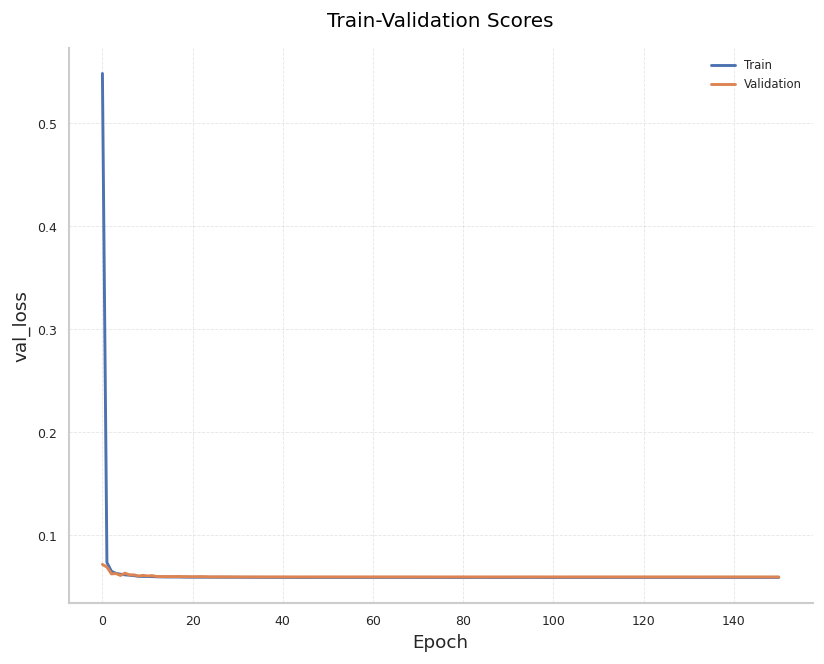

680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 5 → Training set Score: 1.36064 | Validation set Score: 0.06048
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - dense_128_loss: 0.0000e+00 - loss: 1.4568 - msle: 71.2852 - rmsle: 1.4568 - val_dense_128_loss: 0.0000e+00 - val_loss: 0.0742 - val_msle: 5.4912 - val_rmsle: 0.0742 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_128_loss: 0.0000e+00 - loss: 0.0778 - msle: 6.1840 - rmsle: 0.0778 - val_dense_128_loss: 0.0000e+00 - val_loss: 0.0641 - val_msle: 4.1814 - val_rmsle: 0.0641 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_128_loss: 0.0000e+00 - loss: 0.0660 - msle: 4.4573 - rmsle: 0.0660 - val_dense_128_loss: 0.0000e+00 - val_loss: 0.0641 - val_msle: 4.0319 - val_rmsle: 0.0640 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - dense_128_loss: 0.0000

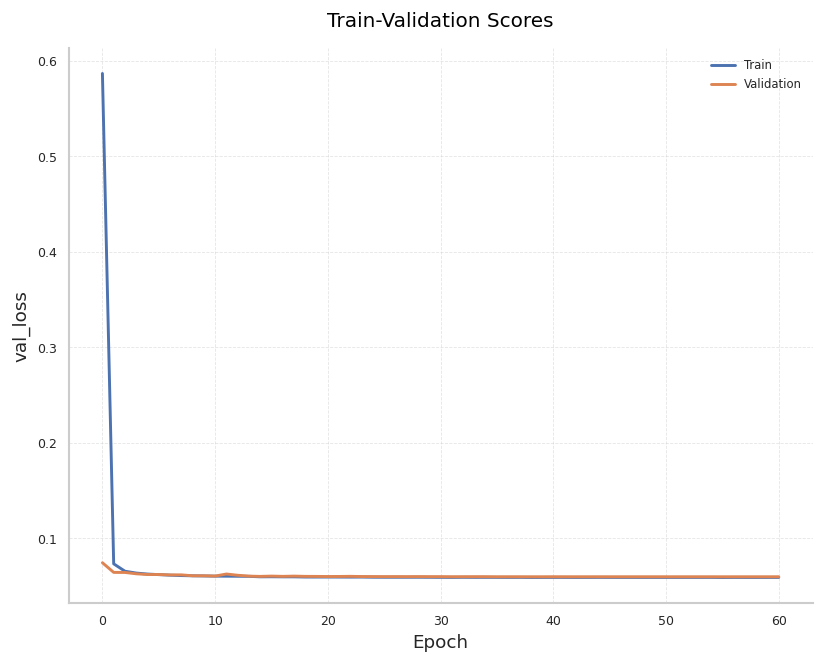

680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 6 → Training set Score: 1.36061 | Validation set Score: 0.06007
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - dense_140_loss: 0.0000e+00 - loss: 1.3445 - msle: 69.4220 - rmsle: 1.3445 - val_dense_140_loss: 0.0000e+00 - val_loss: 0.0660 - val_msle: 4.6774 - val_rmsle: 0.0660 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_140_loss: 0.0000e+00 - loss: 0.0738 - msle: 5.6828 - rmsle: 0.0738 - val_dense_140_loss: 0.0000e+00 - val_loss: 0.0613 - val_msle: 4.0365 - val_rmsle: 0.0612 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_140_loss: 0.0000e+00 - loss: 0.0655 - msle: 4.4770 - rmsle: 0.0655 - val_dense_140_loss: 0.0000e+00 - val_loss: 0.0596 - val_msle: 3.7695 - val_rmsle: 0.0596 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_140_loss: 0.0000

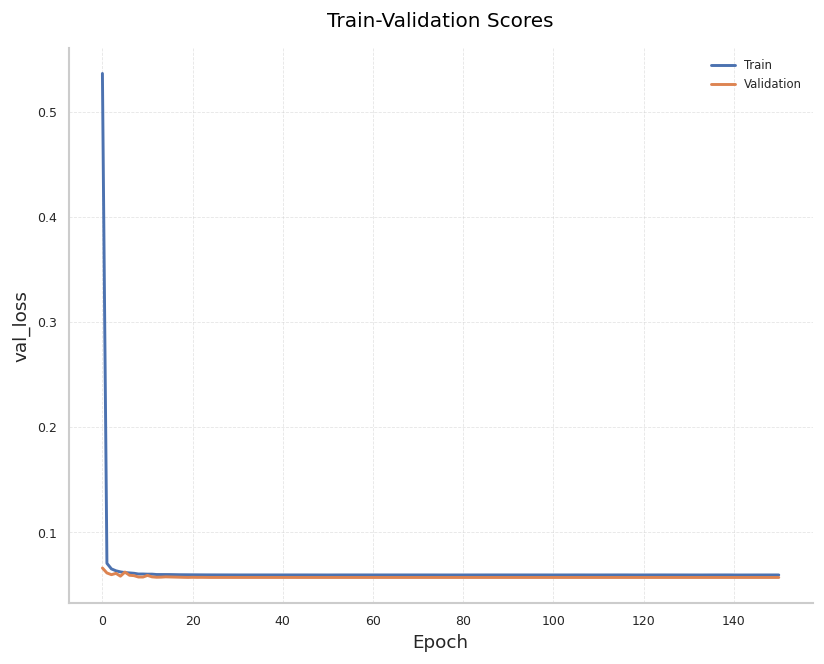

680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 7 → Training set Score: 1.36145 | Validation set Score: 0.05744
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 54s 32ms/step - dense_152_loss: 0.0000e+00 - loss: 1.4094 - msle: 68.7938 - rmsle: 1.4094 - val_dense_152_loss: 0.0000e+00 - val_loss: 0.0699 - val_msle: 4.9895 - val_rmsle: 0.0699 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_152_loss: 0.0000e+00 - loss: 0.0738 - msle: 5.6294 - rmsle: 0.0738 - val_dense_152_loss: 0.0000e+00 - val_loss: 0.0630 - val_msle: 4.1716 - val_rmsle: 0.0630 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_152_loss: 0.0000e+00 - loss: 0.0668 - msle: 4.5621 - rmsle: 0.0668 - val_dense_152_loss: 0.0000e+00 - val_loss: 0.0634 - val_msle: 3.9583 - val_rmsle: 0.0633 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - dense_152_loss: 0.0000

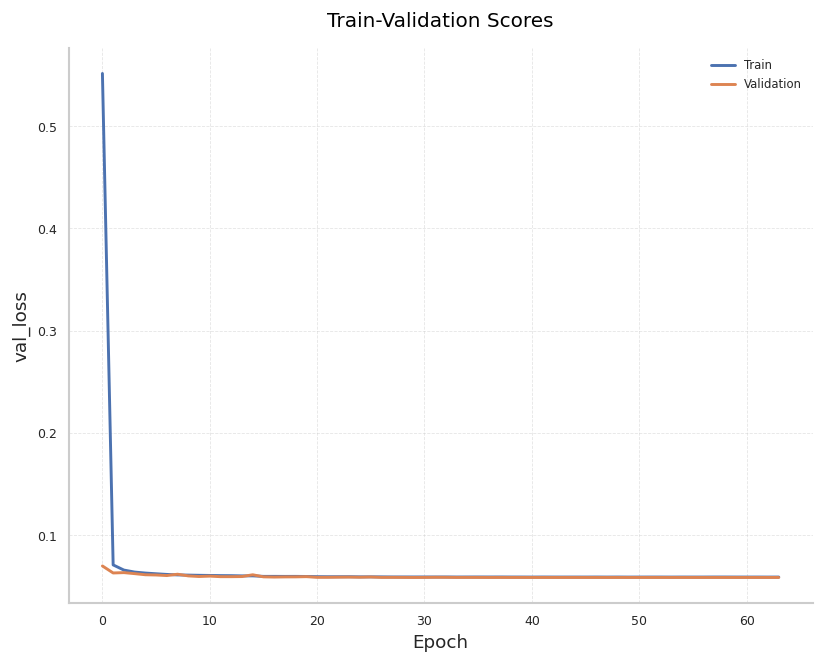

680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 8 → Training set Score: 1.35899 | Validation set Score: 0.05917
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 52s 32ms/step - dense_164_loss: 0.0000e+00 - loss: 1.3990 - msle: 69.8570 - rmsle: 1.3990 - val_dense_164_loss: 0.0000e+00 - val_loss: 0.0696 - val_msle: 4.8394 - val_rmsle: 0.0696 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_164_loss: 0.0000e+00 - loss: 0.0716 - msle: 5.3654 - rmsle: 0.0716 - val_dense_164_loss: 0.0000e+00 - val_loss: 0.0651 - val_msle: 4.2058 - val_rmsle: 0.0650 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - dense_164_loss: 0.0000e+00 - loss: 0.0642 - msle: 4.2726 - rmsle: 0.0642 - val_dense_164_loss: 0.0000e+00 - val_loss: 0.0625 - val_msle: 4.0499 - val_rmsle: 0.0625 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_164_loss: 0.0000

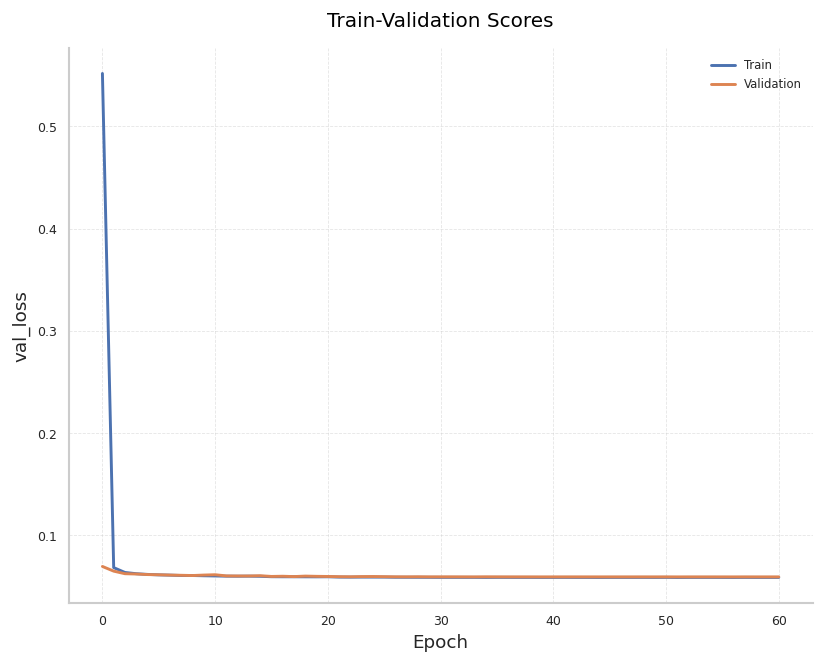

680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 9 → Training set Score: 1.35974 | Validation set Score: 0.06010
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 52s 32ms/step - dense_176_loss: 0.0000e+00 - loss: 1.3914 - msle: 69.4312 - rmsle: 1.3914 - val_dense_176_loss: 0.0000e+00 - val_loss: 0.0773 - val_msle: 5.4556 - val_rmsle: 0.0773 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_176_loss: 0.0000e+00 - loss: 0.0814 - msle: 6.4058 - rmsle: 0.0814 - val_dense_176_loss: 0.0000e+00 - val_loss: 0.0662 - val_msle: 4.2251 - val_rmsle: 0.0662 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_176_loss: 0.0000e+00 - loss: 0.0679 - msle: 4.7227 - rmsle: 0.0679 - val_dense_176_loss: 0.0000e+00 - val_loss: 0.0631 - val_msle: 3.9394 - val_rmsle: 0.0631 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - dense_176_loss: 0.0000

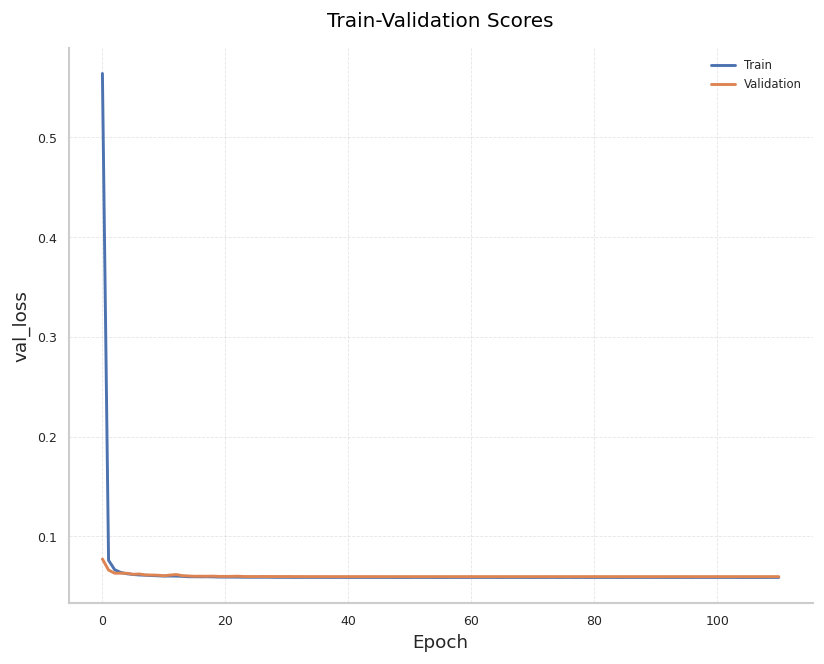

680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 10 → Training set Score: 1.36178 | Validation set Score: 0.06040
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 54s 32ms/step - dense_188_loss: 0.0000e+00 - loss: 1.3644 - msle: 70.3169 - rmsle: 1.3644 - val_dense_188_loss: 0.0000e+00 - val_loss: 0.0725 - val_msle: 5.1445 - val_rmsle: 0.0725 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_188_loss: 0.0000e+00 - loss: 0.0785 - msle: 6.1502 - rmsle: 0.0785 - val_dense_188_loss: 0.0000e+00 - val_loss: 0.0682 - val_msle: 4.1947 - val_rmsle: 0.0682 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_188_loss: 0.0000e+00 - loss: 0.0666 - msle: 4.6265 - rmsle: 0.0666 - val_dense_188_loss: 0.0000e+00 - val_loss: 0.0625 - val_msle: 4.0319 - val_rmsle: 0.0625 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - dense_188_loss: 0.000

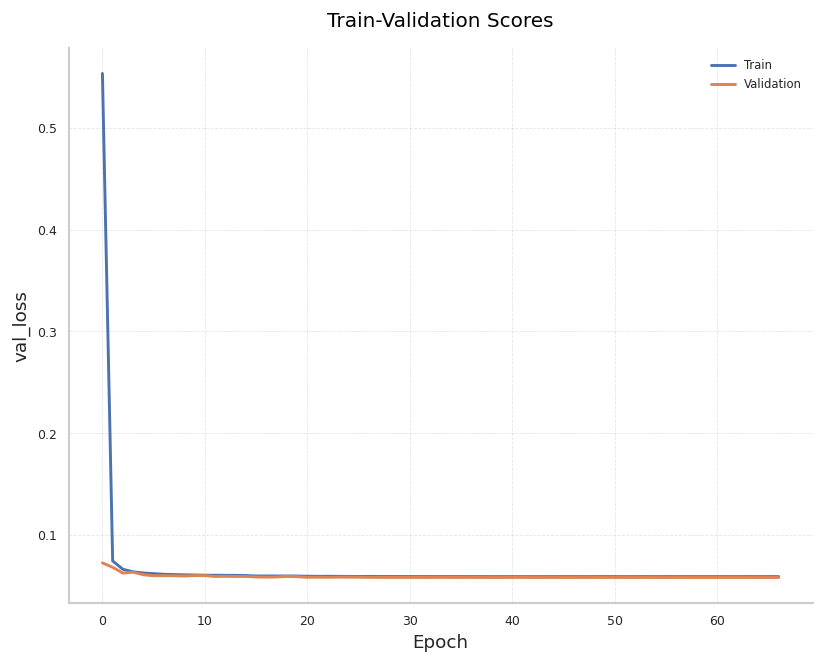

680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 11 → Training set Score: 1.36145 | Validation set Score: 0.05868
Overall → Training set Score: 1.36080±0.0010533 | Validation set Score: 0.05992±0.0013437


In [43]:
TM.fit_model(name="NN_TabTransformer_00_v1")

#### 2.1.3 Store Results:

In [44]:
name_experiment = "NN_TabTransformer_00_v1"

train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred, columns = [f"{name_experiment}"])

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

In [45]:
test_pred.min(), test_pred.max()

(NN_TabTransformer_00_v1    1.0
 dtype: float64,
 NN_TabTransformer_00_v1    315.000004
 dtype: float64)

In [46]:
test_pred.head()

,NN_TabTransformer_00_v1
0,27.351921
1,107.759375
2,86.849363
3,126.034573
4,76.324179


In [47]:
sub.head()

,Calories
id,
750000,27.351921
750001,107.759375
750002,86.849363
750003,126.034573
750004,76.324179


In [48]:
train_pred.head()

,NN_TabTransformer_00_v1
0,146.083984
1,35.901283
2,28.883390
3,137.813095
4,146.386642


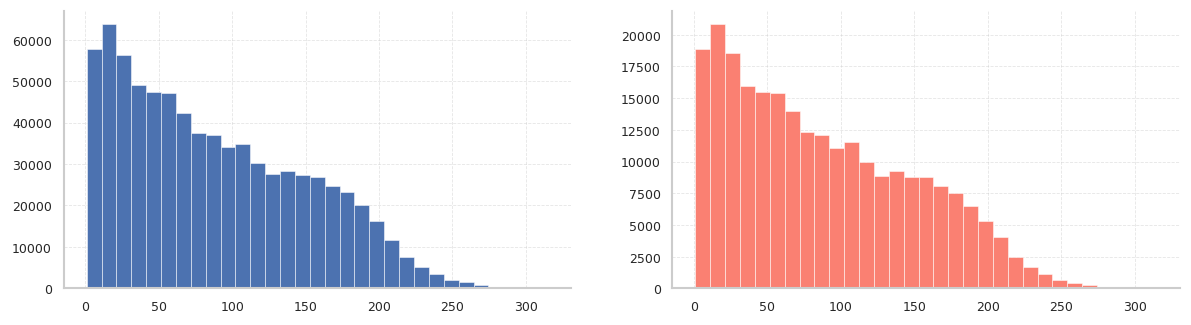

In [49]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [50]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

### **2.3.0 NeuralNetwork: Wide and Deep Model v2**

This version of the model includes a Cross Layers within the Wide Branch of the NN.

In [ ]:
data.X.sample(3)

In [ ]:
data.X.max(axis=0)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(data.X.Age_Group, bins=31)
ax[1].hist(data.X_test.Age_Group, bins=31, color="salmon")

plt.show()

In [ ]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]


print(cat_features,cat_features_card)
print(num_features)

In [ ]:
def wide_deep_cross(units=512, activation="relu", do_rate=0.25, reg=0.001, hidden_layers=3, num_cross_layers=2):
    '''
    In this model embedding is performed for the data feeding into both the Deep and and wide layers:
    '''

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], cat_features_out[j]) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])

    deep = x
    wide = x  # Both Branches start with the concatenated features

    # Wide Branch with Cross Layers:
    for _ in range(num_cross_layers):
        xl = layers.Dense(units=x.shape[-1],  # Output dimension same as input
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros',
                         activation=None)(wide)  # Linear activation
        # Cross Layer Calculation:
        cross = layers.Multiply()([x, xl])  # Element-wise multiplication
        # Concatenate instead of Add:
        wide = layers.Concatenate(axis=-1)([wide, cross])

    # Deep Branch:
    for lay in range(hidden_layers):
        deep = layers.Dense(units,kernel_regularizer=keras.regularizers.l2(reg), name=f"dense_deep_{lay}")(deep)
        deep = layers.BatchNormalization(name=f"bn_deep_{lay}")(deep)
        if activation == "relu":
            deep = layers.ReLU(name=f"relu_deep_{lay}")(deep)
        elif activation == "prelu":
            deep = layers.PReLU(name=f"prelu_deep_{lay}")(deep)
        elif activation == "gelu ":
            deep = activations.gelu(deep)
        elif activation == "silu":
            deep = activations.silu(deep)
        elif activation == "mish":
            deep = layers.Lambda(lambda x: keras.activations.mish(x), name=f"mish_deep_{lay}")(deep)
        elif activation == "celu":
            deep = activations.celu(deep)

        deep = layers.Dropout(do_rate, name=f"do_deep_{lay}")(deep)

    merged = layers.concatenate([wide, deep])

    x_final = layers.Dense(1, activation='linear')(merged)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [ ]:
mod_test = wide_deep_cross(units=512, activation="celu")
mod_test.summary()

In [ ]:
#keras.utils.plot_model(mod_test, show_shapes=True, rankdir="LR")

#### 2.3.1 Optuna Optimization:

In [ ]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

In [ ]:
y_fin.isna().sum()

**OPTIMIZATION SECTION**

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=wide_deep_cross, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'units': trial.suggest_categorical('units', [128,256,512,1024]),
              'num_cross_layers': trial.suggest_int('num_cross_layers', 1, 3),
              'activation': trial.suggest_categorical('activation', ["relu","prelu","silu"]),
              'reg': trial.suggest_float('reg', 1e-4, 0.01, log=True),
              'do_rate': trial.suggest_float('do_rate', 0.25, 0.45),
              'hidden_layers': trial.suggest_int('hidden_layers', 1,3)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=5e-4)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint_dwc.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=31,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

  1. Trial 1 finished with value: 0.061372210432322494 and parameters: {'units': 512, 'num_cross_layers': 1, 'activation': 'relu', 'reg': 0.0007600657726479304, 'do_rate': 0.4197061058874465, 'hidden_layers': 2}.

  2. Trial 6 finished with value: 0.061261933879490194 and parameters: {'units': 256, 'num_cross_layers': 1, 'activation': 'silu', 'reg': 0.0001002990796038959, 'do_rate': 0.39009941717483704, 'hidden_layers': 2}. Best

  3.  Trial

In [ ]:
nn3_study = tune_hyperparameters(X_fin, y_fin, model_class=wide_deep_cross, n_trials=37, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn3_study.best_params

In [ ]:
cat_params

#### 2.1.2 Train Model:

In [ ]:
param = {'units': 512, 'num_cross_layers': 3, 'activation': 'prelu', 'reg': 0.0001360583533261253, 'do_rate': 0.3763917280440354,  'hidden_layers': 2}

In [ ]:
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=wide_deep_cross, parameters=param)

In [ ]:
TM.fit_model(name="NN_widedeepcross_00")

#### 2.1.3 Store Results:

In [ ]:
name_experiment = "NN_widedeepcross_00"

train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred, columns = [f"{name_experiment}"])

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

In [ ]:
test_pred.min(), test_pred.max()

In [ ]:
test_pred.head()

In [ ]:
sub.head()

In [ ]:
train_pred.head()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [ ]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

# **3.0 TREE BASED MODELS**

In [18]:
# from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
# class_weights = dict(enumerate(class_weights))

# sample_pos_weight = class_weights[1]/class_weights[0]
# sample_pos_weight

In [19]:
class TrainModels:
    def __init__(self, X, y, X_test, X_original, y_original, models):
        self.models     = models
        self.X          = X
        self.y          = y
        self.X_original = X_original
        self.y_original = y_original
        self.X_test     = X_test
        self._OOF_train = pd.DataFrame()
        self._OOF_test  = pd.DataFrame()
        self.categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()

    @staticmethod
    def convert_cat(df_):
        '''
        A function to convert dtypes to categorical if the catboost with all categorical
        features is called
        '''
        df = df_.copy()
        for c in df.columns.to_list():
            df[c] = df[c].astype(str).astype('category')
        return df


    def fit_model(self, name, model_, train_flag):
        oof_train = np.zeros(self.X.shape[0])
        oof_test  = np.zeros(self.X_test.shape[0])
        scores_train = []
        scores_val   = []

        CB_CAT_FLAG = True if 'CB_CAT' in name.upper() else False

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/Catboost')

        for fold, (train_idx, val_idx) in enumerate(CFG.CV.split(self.X, self.y)):
            x_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            x_val,   y_val   = self.X.iloc[val_idx],   self.y.iloc[val_idx]

            # Adds the original data to training set only
            if self.X_original is not None:
                x_train = pd.concat([x_train, self.X_original], axis=0)
                y_train = pd.concat([y_train, self.y_original], axis=0)

            # -- Create a special block to convert all features to categorical
            if CB_CAT_FLAG:
                x_train = self.convert_cat(x_train)
                x_val   = self.convert_cat(x_val)

            model = clone(model_)

            if 'CB' in name.upper():
              if train_flag==True:
                model.fit(x_train,y_train,eval_set=[(x_val,y_val)], early_stopping_rounds=101)
                model.save_model(f"{name}_{fold}.bin")
              else:
                print("Load Model")
                model = CatBoostRegressor()
                model.load_model(f"{name}_{fold}.bin")

            elif 'LGBMR' in name.upper():
              early_stop = early_stopping(stopping_rounds=101)
              if train_flag==True:
                model.fit(x_train, y_train, eval_set=[(x_val, y_val)], callbacks=[early_stop],categorical_feature=self.categorical_features)
                model.booster_.save_model(f'{name}_{fold}.txt')
              else:
                print("Load Model")
                model = lgb.Booster(model_file=f'{name}_{fold}.txt')

            elif 'LGBMP' in name.upper():
              # Fit the model
              if train_flag==True:
                model.fit(x_train, y_train)
                joblib.dump(model, f'{name}_{fold}.pkl')
              else:
                print("Load Model")
                model = joblib.load(f'{name}_{fold}.pkl')

            elif 'XGBR' in name.upper():
              if train_flag==True:
                model.fit(x_train, y_train, eval_set=[(x_val, y_val)],verbose=250)
                model.save_model(f'{name}_{fold}.json')
              else:
                print("Load Model")
                model = XGBRegressor()  # Create an instance of the model
                model.load_model(f'{name}_{fold}.json')

            elif 'LGBM_2' in name.upper():
              model.fit(x_train, y_train, eval_set=[(x_val, y_val)])


            elif 'HGB_' in name.upper():
              if train_flag==True:
                model.fit(x_train, y_train)
                joblib.dump(model, f'{name}_{fold}.pkl')
              else:
                print("Load Model")
                model = joblib.load(f'{name}_{fold}.pkl')

            else:

              model.fit(x_train, y_train)

            y_pred_train = model.predict(x_train).ravel()
            y_pred_val   = model.predict(x_val).ravel()
            y_pred_test  = model.predict(self.X_test if not CB_CAT_FLAG else self.convert_cat(self.X_test)).ravel()

            y_pred_train = np.expm1(y_pred_train)
            y_pred_val   = np.expm1(y_pred_val)
            y_pred_test  = np.expm1(y_pred_test)

            # Correct Ranges:

            print("Pred Min&Max Valid: {} and {}".format(y_pred_val.min(), y_pred_val.max()))
            print("Pred Min&Max Test: {} and {}".format(y_pred_test.min(), y_pred_test.max()))

            y_pred_train = np.maximum(y_pred_train, 1.0)
            y_pred_train = np.minimum(y_pred_train, 315.0)

            y_pred_val = np.maximum(y_pred_val, 1.0)
            y_pred_val = np.minimum(y_pred_val, 315.0)

            y_pred_test = np.maximum(y_pred_test, 1.0)
            y_pred_test = np.minimum(y_pred_test, 315.0)

            print("Pred Min&Max Valid Adj: {} and {}".format(y_pred_val.min(), y_pred_val.max()))
            print("Pred Min&Max Test Adj: {} and {}".format(y_pred_test.min(), y_pred_test.max()))

            oof_train[val_idx] = y_pred_val
            oof_test   += y_pred_test/CFG.CV.get_n_splits()

            train_score = root_mean_squared_log_error(np.expm1(y_train), y_pred_train)
            val_score   = root_mean_squared_log_error(np.expm1(y_val), y_pred_val)

            print(f'Fold {fold+1} → Training set Score: {train_score:.5f} | Validation set Score: {val_score:.5f}')

            scores_train.append(train_score)
            scores_val.append(val_score)

        self._OOF_train[name] = oof_train
        self._OOF_test[name]  = oof_test

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5')

        print(colored(f'Overall → Training set Score: {np.mean(scores_train):.5f}±{np.std(scores_train):.7f} | Validation set Score: {np.mean(scores_val):.5f}±{np.std(scores_val):.7f}',
              color='green', attrs=['bold', 'dark']))

    def fit_models(self):
        for name, model in list(self.models.items()):
            print(colored(f'{" "*4} Fitting {name}', color='red', attrs=['dark', 'bold']))
            self.fit_model(name, model[0], model[1])
            print("")

    @property
    def OOF_train(self):
        return self._OOF_train
    @property
    def OOF_test(self):
        return self._OOF_test

    def save_predictions(self):
        self._OOF_train.to_csv('OOF_train_many_models.csv', index=False)
        self._OOF_test.to_csv('OOF_test_many_models.csv', index=False)

## 3.1.0 CatBoostClassifier:

In [20]:
cat_prob = {"objective":"RMSE","eval_metric":"RMSE"}

In [21]:
X = data.X
y = np.log1p(data.y)
categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
categorical_features

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group']

In [22]:
X.shape

(765000, 15)

### 3.1.1 Optuna Optimization:

In [43]:
def objective_catboost(trial, X, y, n_splits, n_repeats, model=CatBoostRegressor, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=cat_prob,categorical_features=categorical_features):

    model_class = model

    categorical_features = categorical_features

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
        'iterations': 2500,
        'learning_rate': 0.02, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 8, 13),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 0.1, log=True),
        "bootstrap_type": "Bernoulli", #trial.suggest_categorical("bootstrap_type",["Bayesian","Bernoulli"]),
        'random_strength': trial.suggest_float('random_strength', 0.5, 3.5, step=0.25),
        'border_count': trial.suggest_int('border_count', 190, 260, step=5),
        'cat_features': categorical_features,
        'task_type': 'GPU' if use_gpu else 'CPU',
        'random_seed':rs,
        'verbose': 250,
        'objective': metrics["objective"],
        'eval_metric': metrics["eval_metric"],
        "od_type":'EBS', #Early stopping hyperparmeter
        "od_wait":101,
        #"sampling_frequency":"PerTreeLevel",
        "use_best_model":True,
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.5, 1.5, step=0.1)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.70, 1.0, step=0.025)

    if cv_strategy == 'RepKFold':
      kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
      kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
      kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
      kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmse_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1,1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1,1)

        if fit_scaling:
          scaler = StandardScaler()
          X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
          X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the Pool objects for CatBoost
        train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
        valid_pool = Pool(data=X_valid, label=y_valid, cat_features=categorical_features)

        # Create the pipeline
        model = model_class(**params)
        # Fit the model:
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=101,
                  #callbacks=[optuna.integration.CatBoostPruningCallback(trial, "RMSE")]
                  )

        # Make predictions on the validation set
        y_pred = model.predict(X_valid)

#        y_pred = np.expm1(y_pred)
#        y_valid = np.expm1(y_valid)

        # Calculate the RMSE for the current fold

        rmse_score = root_mean_squared_error(y_valid, y_pred)
        rmse_scores.append(rmse_score)

        gc.collect()

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmse_scores)

    return key_metric

In [44]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_catboost(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")

In [45]:
# usage with XGBRegressor
cat_study = tune_hyperparameters(X, y, model_class=CatBoostRegressor, n_trials=31, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)
save_results(cat_study, CatBoostRegressor, "CatBoost_ext")

[I 2025-05-20 23:23:05,438] A new study created in memory with name: no-name-67ccd34c-57e5-4faa-b9b5-e2373b4607b6


0:	learn: 0.9450545	test: 0.9428725	best: 0.9428725 (0)	total: 23.1ms	remaining: 57.8s
250:	learn: 0.0652465	test: 0.0656912	best: 0.0656912 (250)	total: 3.92s	remaining: 35.2s
500:	learn: 0.0602427	test: 0.0615839	best: 0.0615839 (500)	total: 7.84s	remaining: 31.3s
750:	learn: 0.0591203	test: 0.0609894	best: 0.0609894 (750)	total: 11.7s	remaining: 27.3s
1000:	learn: 0.0583972	test: 0.0607004	best: 0.0607004 (1000)	total: 15.7s	remaining: 23.6s
1250:	learn: 0.0578463	test: 0.0605391	best: 0.0605391 (1250)	total: 19.6s	remaining: 19.6s
1500:	learn: 0.0573355	test: 0.0604331	best: 0.0604322 (1499)	total: 23.6s	remaining: 15.7s
1750:	learn: 0.0568976	test: 0.0603576	best: 0.0603576 (1750)	total: 27.5s	remaining: 11.8s
2000:	learn: 0.0564951	test: 0.0603083	best: 0.0603078 (1997)	total: 31.4s	remaining: 7.83s
2250:	learn: 0.0561177	test: 0.0602651	best: 0.0602647 (2249)	total: 35.3s	remaining: 3.9s
2499:	learn: 0.0557831	test: 0.0602383	best: 0.0602376 (2484)	total: 39.2s	remaining: 0us
be

[I 2025-05-20 23:26:38,248] Trial 0 finished with value: 0.06006278967641139 and parameters: {'depth': 8, 'l2_leaf_reg': 0.045751079707198744, 'random_strength': 0.5, 'border_count': 235, 'subsample': 0.7999999999999999}. Best is trial 0 with value: 0.06006278967641139.


0:	learn: 0.9452123	test: 0.9430234	best: 0.9430234 (0)	total: 16ms	remaining: 40s
250:	learn: 0.0653764	test: 0.0658676	best: 0.0658676 (250)	total: 3.85s	remaining: 34.5s
500:	learn: 0.0604023	test: 0.0617476	best: 0.0617476 (500)	total: 7.74s	remaining: 30.9s
750:	learn: 0.0592807	test: 0.0611403	best: 0.0611403 (750)	total: 11.7s	remaining: 27.2s
1000:	learn: 0.0585173	test: 0.0608141	best: 0.0608141 (1000)	total: 15.7s	remaining: 23.5s
1250:	learn: 0.0579361	test: 0.0606286	best: 0.0606286 (1250)	total: 19.8s	remaining: 19.7s
1500:	learn: 0.0574182	test: 0.0605210	best: 0.0605210 (1500)	total: 23.7s	remaining: 15.8s
1750:	learn: 0.0569711	test: 0.0604285	best: 0.0604285 (1750)	total: 27.6s	remaining: 11.8s
2000:	learn: 0.0565742	test: 0.0603634	best: 0.0603634 (2000)	total: 31.6s	remaining: 7.87s
2250:	learn: 0.0562045	test: 0.0603088	best: 0.0603088 (2250)	total: 35.5s	remaining: 3.93s
2499:	learn: 0.0558400	test: 0.0602859	best: 0.0602841 (2476)	total: 39.5s	remaining: 0us
bestT

[I 2025-05-20 23:30:09,634] Trial 1 finished with value: 0.060082674554087834 and parameters: {'depth': 8, 'l2_leaf_reg': 0.01050729260272926, 'random_strength': 2.25, 'border_count': 260, 'subsample': 0.7999999999999999}. Best is trial 0 with value: 0.06006278967641139.


0:	learn: 0.9449789	test: 0.9427956	best: 0.9427956 (0)	total: 20.5ms	remaining: 51.2s
250:	learn: 0.0636413	test: 0.0643807	best: 0.0643807 (250)	total: 4.71s	remaining: 42.3s
500:	learn: 0.0594244	test: 0.0612137	best: 0.0612137 (500)	total: 9.47s	remaining: 37.8s
750:	learn: 0.0583388	test: 0.0607938	best: 0.0607938 (750)	total: 14.2s	remaining: 33.1s
1000:	learn: 0.0575621	test: 0.0605763	best: 0.0605763 (1000)	total: 19s	remaining: 28.4s
1250:	learn: 0.0569175	test: 0.0604597	best: 0.0604597 (1250)	total: 23.8s	remaining: 23.8s
1500:	learn: 0.0563301	test: 0.0603713	best: 0.0603713 (1500)	total: 28.6s	remaining: 19s
1750:	learn: 0.0558020	test: 0.0603098	best: 0.0603094 (1748)	total: 33.4s	remaining: 14.3s
2000:	learn: 0.0553159	test: 0.0602901	best: 0.0602901 (2000)	total: 38.2s	remaining: 9.53s
2250:	learn: 0.0548789	test: 0.0602612	best: 0.0602606 (2248)	total: 43s	remaining: 4.76s
2499:	learn: 0.0544684	test: 0.0602481	best: 0.0602475 (2453)	total: 47.8s	remaining: 0us
bestTes

[I 2025-05-20 23:34:18,938] Trial 2 finished with value: 0.05998823098872898 and parameters: {'depth': 9, 'l2_leaf_reg': 0.03695161194002899, 'random_strength': 0.5, 'border_count': 245, 'subsample': 0.825}. Best is trial 2 with value: 0.05998823098872898.


0:	learn: 0.9452950	test: 0.9430998	best: 0.9430998 (0)	total: 18.6ms	remaining: 46.5s
250:	learn: 0.0613766	test: 0.0631293	best: 0.0631293 (250)	total: 16.6s	remaining: 2m 28s
500:	learn: 0.0581082	test: 0.0614797	best: 0.0614797 (500)	total: 33.6s	remaining: 2m 14s
750:	learn: 0.0564065	test: 0.0611885	best: 0.0611885 (750)	total: 51.3s	remaining: 1m 59s
1000:	learn: 0.0548007	test: 0.0610592	best: 0.0610584 (997)	total: 1m 9s	remaining: 1m 44s
1250:	learn: 0.0534236	test: 0.0609950	best: 0.0609929 (1242)	total: 1m 28s	remaining: 1m 28s
1500:	learn: 0.0522047	test: 0.0609716	best: 0.0609705 (1473)	total: 1m 46s	remaining: 1m 11s
bestTest = 0.06096725277
bestIteration = 1579
Shrink model to first 1580 iterations.
0:	learn: 0.9443172	test: 0.9461421	best: 0.9461421 (0)	total: 18.6ms	remaining: 46.6s
250:	learn: 0.0615523	test: 0.0630311	best: 0.0630311 (250)	total: 16.7s	remaining: 2m 29s
500:	learn: 0.0580532	test: 0.0611114	best: 0.0611114 (500)	total: 33.7s	remaining: 2m 14s
750:	l

[I 2025-05-20 23:45:01,732] Trial 3 finished with value: 0.06041997852262111 and parameters: {'depth': 13, 'l2_leaf_reg': 0.04772260067518755, 'random_strength': 3.0, 'border_count': 195, 'subsample': 0.725}. Best is trial 2 with value: 0.05998823098872898.


0:	learn: 0.9451086	test: 0.9429027	best: 0.9429027 (0)	total: 19.3ms	remaining: 48.3s
250:	learn: 0.0638498	test: 0.0645970	best: 0.0645970 (250)	total: 4.71s	remaining: 42.2s
500:	learn: 0.0597875	test: 0.0614970	best: 0.0614970 (500)	total: 9.39s	remaining: 37.5s
750:	learn: 0.0586314	test: 0.0609801	best: 0.0609801 (750)	total: 14.2s	remaining: 33s
1000:	learn: 0.0578165	test: 0.0607205	best: 0.0607203 (999)	total: 19.1s	remaining: 28.6s
1250:	learn: 0.0571626	test: 0.0605680	best: 0.0605680 (1250)	total: 23.9s	remaining: 23.8s
1500:	learn: 0.0565680	test: 0.0604820	best: 0.0604820 (1500)	total: 28.7s	remaining: 19.1s
1750:	learn: 0.0560325	test: 0.0604120	best: 0.0604120 (1750)	total: 33.5s	remaining: 14.3s
2000:	learn: 0.0555443	test: 0.0603706	best: 0.0603706 (1999)	total: 38.2s	remaining: 9.53s
2250:	learn: 0.0550624	test: 0.0603391	best: 0.0603391 (2250)	total: 43s	remaining: 4.76s
2499:	learn: 0.0546411	test: 0.0603139	best: 0.0603128 (2481)	total: 47.7s	remaining: 0us
bestTe

[I 2025-05-20 23:49:16,203] Trial 4 finished with value: 0.06001271295258368 and parameters: {'depth': 9, 'l2_leaf_reg': 0.015070118795297821, 'random_strength': 2.5, 'border_count': 225, 'subsample': 0.95}. Best is trial 2 with value: 0.05998823098872898.


0:	learn: 0.9450356	test: 0.9428346	best: 0.9428346 (0)	total: 19.5ms	remaining: 48.7s
250:	learn: 0.0640308	test: 0.0647416	best: 0.0647416 (250)	total: 4.65s	remaining: 41.7s
500:	learn: 0.0598992	test: 0.0616020	best: 0.0616020 (500)	total: 9.25s	remaining: 36.9s
750:	learn: 0.0587411	test: 0.0610701	best: 0.0610701 (750)	total: 14s	remaining: 32.5s
1000:	learn: 0.0579192	test: 0.0608308	best: 0.0608308 (1000)	total: 18.8s	remaining: 28.2s
1250:	learn: 0.0572680	test: 0.0606622	best: 0.0606622 (1250)	total: 23.6s	remaining: 23.5s
1500:	learn: 0.0566713	test: 0.0605760	best: 0.0605759 (1498)	total: 28.5s	remaining: 18.9s
1750:	learn: 0.0561578	test: 0.0605130	best: 0.0605115 (1745)	total: 33.2s	remaining: 14.2s
2000:	learn: 0.0556643	test: 0.0604880	best: 0.0604849 (1981)	total: 38s	remaining: 9.47s
2250:	learn: 0.0551927	test: 0.0604638	best: 0.0604632 (2245)	total: 42.8s	remaining: 4.73s
2499:	learn: 0.0547726	test: 0.0604386	best: 0.0604381 (2496)	total: 47.5s	remaining: 0us
bestT

[I 2025-05-20 23:53:29,758] Trial 5 finished with value: 0.06007536753005527 and parameters: {'depth': 9, 'l2_leaf_reg': 0.0540711919502088, 'random_strength': 3.25, 'border_count': 225, 'subsample': 0.9249999999999999}. Best is trial 2 with value: 0.05998823098872898.


0:	learn: 0.9451096	test: 0.9429025	best: 0.9429025 (0)	total: 22.7ms	remaining: 56.9s
250:	learn: 0.0613645	test: 0.0628692	best: 0.0628692 (250)	total: 11.5s	remaining: 1m 42s
500:	learn: 0.0581644	test: 0.0611769	best: 0.0611769 (500)	total: 23.1s	remaining: 1m 32s
750:	learn: 0.0566850	test: 0.0608968	best: 0.0608968 (750)	total: 34.7s	remaining: 1m 20s
1000:	learn: 0.0553862	test: 0.0607561	best: 0.0607561 (1000)	total: 46.4s	remaining: 1m 9s
1250:	learn: 0.0542860	test: 0.0606798	best: 0.0606798 (1250)	total: 58.1s	remaining: 58s
1500:	learn: 0.0532645	test: 0.0606429	best: 0.0606412 (1495)	total: 1m 9s	remaining: 46.5s
1750:	learn: 0.0523705	test: 0.0606299	best: 0.0606273 (1714)	total: 1m 21s	remaining: 34.9s
2000:	learn: 0.0515009	test: 0.0606172	best: 0.0606129 (1941)	total: 1m 33s	remaining: 23.3s
bestTest = 0.06061288207
bestIteration = 1941
Shrink model to first 1942 iterations.
0:	learn: 0.9443130	test: 0.9461339	best: 0.9461339 (0)	total: 21.9ms	remaining: 54.8s
250:	lea

[I 2025-05-21 00:00:55,256] Trial 6 finished with value: 0.060186886782163475 and parameters: {'depth': 12, 'l2_leaf_reg': 0.04028801533611686, 'random_strength': 1.75, 'border_count': 225, 'subsample': 0.75}. Best is trial 2 with value: 0.05998823098872898.


0:	learn: 0.9448199	test: 0.9426308	best: 0.9426308 (0)	total: 47.4ms	remaining: 1m 58s
250:	learn: 0.0612812	test: 0.0626396	best: 0.0626396 (250)	total: 11.4s	remaining: 1m 42s
500:	learn: 0.0580553	test: 0.0609540	best: 0.0609540 (500)	total: 22.9s	remaining: 1m 31s
750:	learn: 0.0565371	test: 0.0607047	best: 0.0607047 (749)	total: 34.5s	remaining: 1m 20s
1000:	learn: 0.0552814	test: 0.0605999	best: 0.0605999 (1000)	total: 46.2s	remaining: 1m 9s
1250:	learn: 0.0541525	test: 0.0605509	best: 0.0605490 (1236)	total: 57.9s	remaining: 57.8s
1500:	learn: 0.0532002	test: 0.0605164	best: 0.0605158 (1492)	total: 1m 9s	remaining: 46.3s
bestTest = 0.06051582952
bestIteration = 1492
Shrink model to first 1493 iterations.
0:	learn: 0.9440410	test: 0.9458528	best: 0.9458528 (0)	total: 47ms	remaining: 1m 57s
250:	learn: 0.0614058	test: 0.0628793	best: 0.0628793 (250)	total: 11.4s	remaining: 1m 42s
500:	learn: 0.0580640	test: 0.0611031	best: 0.0611031 (500)	total: 22.9s	remaining: 1m 31s
750:	learn

[I 2025-05-21 00:08:29,489] Trial 7 finished with value: 0.06016130688046173 and parameters: {'depth': 12, 'l2_leaf_reg': 0.08486594641075722, 'random_strength': 0.75, 'border_count': 220, 'subsample': 0.725}. Best is trial 2 with value: 0.05998823098872898.


0:	learn: 0.9450886	test: 0.9428931	best: 0.9428931 (0)	total: 16.1ms	remaining: 40.1s
250:	learn: 0.0652276	test: 0.0656551	best: 0.0656551 (250)	total: 3.79s	remaining: 33.9s
500:	learn: 0.0603002	test: 0.0616543	best: 0.0616543 (500)	total: 7.57s	remaining: 30.2s
750:	learn: 0.0591691	test: 0.0610376	best: 0.0610376 (750)	total: 11.4s	remaining: 26.6s
1000:	learn: 0.0584457	test: 0.0607493	best: 0.0607493 (1000)	total: 15.3s	remaining: 22.9s
1250:	learn: 0.0578690	test: 0.0605905	best: 0.0605905 (1250)	total: 19.1s	remaining: 19.1s
1500:	learn: 0.0573682	test: 0.0604874	best: 0.0604874 (1500)	total: 23s	remaining: 15.3s
1750:	learn: 0.0569195	test: 0.0604066	best: 0.0604066 (1750)	total: 26.9s	remaining: 11.5s
2000:	learn: 0.0565165	test: 0.0603619	best: 0.0603619 (2000)	total: 30.8s	remaining: 7.68s
2250:	learn: 0.0561471	test: 0.0603121	best: 0.0603120 (2249)	total: 34.8s	remaining: 3.85s
2499:	learn: 0.0557951	test: 0.0602710	best: 0.0602702 (2494)	total: 38.6s	remaining: 0us
bes

[I 2025-05-21 00:11:58,171] Trial 8 finished with value: 0.060089066780586634 and parameters: {'depth': 8, 'l2_leaf_reg': 0.03164735623677122, 'random_strength': 1.5, 'border_count': 220, 'subsample': 0.95}. Best is trial 2 with value: 0.05998823098872898.


0:	learn: 0.9452950	test: 0.9430998	best: 0.9430998 (0)	total: 18.4ms	remaining: 46s
250:	learn: 0.0618265	test: 0.0633470	best: 0.0633470 (250)	total: 10.8s	remaining: 1m 37s
500:	learn: 0.0584896	test: 0.0614309	best: 0.0614309 (500)	total: 22s	remaining: 1m 27s
750:	learn: 0.0570792	test: 0.0610947	best: 0.0610947 (750)	total: 33.1s	remaining: 1m 17s
1000:	learn: 0.0557234	test: 0.0609372	best: 0.0609372 (1000)	total: 44.7s	remaining: 1m 6s
1250:	learn: 0.0545639	test: 0.0608591	best: 0.0608571 (1225)	total: 56.4s	remaining: 56.3s
1500:	learn: 0.0535424	test: 0.0608145	best: 0.0608145 (1500)	total: 1m 8s	remaining: 45.3s
1750:	learn: 0.0526150	test: 0.0607816	best: 0.0607805 (1666)	total: 1m 19s	remaining: 34.1s
bestTest = 0.06078054707
bestIteration = 1666
Shrink model to first 1667 iterations.
0:	learn: 0.9442387	test: 0.9460588	best: 0.9460588 (0)	total: 22.7ms	remaining: 56.8s
250:	learn: 0.0619460	test: 0.0631416	best: 0.0631416 (250)	total: 10.9s	remaining: 1m 37s
500:	learn: 

[I 2025-05-21 00:20:39,630] Trial 9 finished with value: 0.060249707173501955 and parameters: {'depth': 12, 'l2_leaf_reg': 0.031894497643067427, 'random_strength': 3.0, 'border_count': 205, 'subsample': 0.825}. Best is trial 2 with value: 0.05998823098872898.


0:	learn: 0.9450484	test: 0.9428572	best: 0.9428572 (0)	total: 22.1ms	remaining: 55.3s
250:	learn: 0.0626944	test: 0.0637103	best: 0.0637103 (250)	total: 6.3s	remaining: 56.5s
500:	learn: 0.0590384	test: 0.0612470	best: 0.0612470 (500)	total: 12.3s	remaining: 49.1s
750:	learn: 0.0578914	test: 0.0608708	best: 0.0608708 (750)	total: 18.3s	remaining: 42.6s
1000:	learn: 0.0569603	test: 0.0606841	best: 0.0606821 (998)	total: 24.4s	remaining: 36.5s
1250:	learn: 0.0561681	test: 0.0605649	best: 0.0605649 (1250)	total: 30.4s	remaining: 30.3s
1500:	learn: 0.0554450	test: 0.0605010	best: 0.0605010 (1500)	total: 36.4s	remaining: 24.3s
1750:	learn: 0.0548150	test: 0.0604604	best: 0.0604599 (1748)	total: 42.4s	remaining: 18.2s
2000:	learn: 0.0542166	test: 0.0604419	best: 0.0604402 (1954)	total: 48.7s	remaining: 12.1s
2250:	learn: 0.0536653	test: 0.0604234	best: 0.0604233 (2243)	total: 55.2s	remaining: 6.1s
2499:	learn: 0.0531269	test: 0.0604051	best: 0.0604050 (2494)	total: 1m 1s	remaining: 0us
best

[I 2025-05-21 00:25:44,640] Trial 10 finished with value: 0.060005292640162876 and parameters: {'depth': 10, 'l2_leaf_reg': 0.01923845628887807, 'random_strength': 1.25, 'border_count': 255, 'subsample': 0.875}. Best is trial 2 with value: 0.05998823098872898.


0:	learn: 0.9449853	test: 0.9427965	best: 0.9427965 (0)	total: 22.5ms	remaining: 56.2s
250:	learn: 0.0625899	test: 0.0635425	best: 0.0635425 (250)	total: 5.97s	remaining: 53.5s
500:	learn: 0.0589522	test: 0.0611099	best: 0.0611099 (500)	total: 11.9s	remaining: 47.5s
750:	learn: 0.0577941	test: 0.0607289	best: 0.0607289 (750)	total: 17.9s	remaining: 41.8s
1000:	learn: 0.0568776	test: 0.0605442	best: 0.0605442 (1000)	total: 24s	remaining: 35.9s
1250:	learn: 0.0560887	test: 0.0604624	best: 0.0604624 (1250)	total: 30.1s	remaining: 30.1s
1500:	learn: 0.0553724	test: 0.0604058	best: 0.0604058 (1500)	total: 36.2s	remaining: 24.1s
1750:	learn: 0.0547443	test: 0.0603720	best: 0.0603687 (1707)	total: 42.3s	remaining: 18.1s
2000:	learn: 0.0541477	test: 0.0603507	best: 0.0603503 (1985)	total: 48.4s	remaining: 12.1s
2250:	learn: 0.0535948	test: 0.0603338	best: 0.0603319 (2235)	total: 54.5s	remaining: 6.03s
2499:	learn: 0.0530692	test: 0.0603175	best: 0.0603175 (2499)	total: 1m	remaining: 0us
bestTe

[I 2025-05-21 00:30:55,479] Trial 11 finished with value: 0.06000255100108572 and parameters: {'depth': 10, 'l2_leaf_reg': 0.01974353658613302, 'random_strength': 1.0, 'border_count': 255, 'subsample': 0.875}. Best is trial 2 with value: 0.05998823098872898.


0:	learn: 0.9448701	test: 0.9426829	best: 0.9426829 (0)	total: 32.4ms	remaining: 1m 21s
250:	learn: 0.0616932	test: 0.0629058	best: 0.0629058 (250)	total: 8.01s	remaining: 1m 11s
500:	learn: 0.0583971	test: 0.0609795	best: 0.0609795 (500)	total: 16.2s	remaining: 1m 4s
750:	learn: 0.0570979	test: 0.0607014	best: 0.0607013 (749)	total: 24.2s	remaining: 56.4s
1000:	learn: 0.0560246	test: 0.0605644	best: 0.0605635 (993)	total: 32.3s	remaining: 48.4s
1250:	learn: 0.0550778	test: 0.0604766	best: 0.0604755 (1248)	total: 40.6s	remaining: 40.5s
1500:	learn: 0.0542458	test: 0.0604345	best: 0.0604331 (1498)	total: 48.9s	remaining: 32.5s
1750:	learn: 0.0534808	test: 0.0604021	best: 0.0604004 (1744)	total: 57.4s	remaining: 24.6s
bestTest = 0.06040037192
bestIteration = 1744
Shrink model to first 1745 iterations.
0:	learn: 0.9440743	test: 0.9458949	best: 0.9458949 (0)	total: 32.3ms	remaining: 1m 20s
250:	learn: 0.0618725	test: 0.0631335	best: 0.0631335 (250)	total: 7.91s	remaining: 1m 10s
500:	learn

[I 2025-05-21 00:36:36,192] Trial 12 finished with value: 0.06001645127379698 and parameters: {'depth': 11, 'l2_leaf_reg': 0.021625529612976157, 'random_strength': 0.75, 'border_count': 245, 'subsample': 0.875}. Best is trial 2 with value: 0.05998823098872898.


0:	learn: 0.9450484	test: 0.9428572	best: 0.9428572 (0)	total: 23ms	remaining: 57.5s
250:	learn: 0.0626219	test: 0.0636115	best: 0.0636115 (250)	total: 6.05s	remaining: 54.2s
500:	learn: 0.0590445	test: 0.0611774	best: 0.0611774 (500)	total: 12.3s	remaining: 49s
750:	learn: 0.0578935	test: 0.0607790	best: 0.0607790 (750)	total: 18.6s	remaining: 43.4s
1000:	learn: 0.0570067	test: 0.0605942	best: 0.0605942 (1000)	total: 24.9s	remaining: 37.3s
1250:	learn: 0.0562606	test: 0.0604749	best: 0.0604745 (1249)	total: 31.2s	remaining: 31.2s
1500:	learn: 0.0556323	test: 0.0603921	best: 0.0603919 (1498)	total: 37.4s	remaining: 24.9s
1750:	learn: 0.0550065	test: 0.0603342	best: 0.0603335 (1747)	total: 43.5s	remaining: 18.6s
2000:	learn: 0.0544388	test: 0.0602977	best: 0.0602972 (1994)	total: 49.6s	remaining: 12.4s
bestTest = 0.06029228939
bestIteration = 2033
Shrink model to first 2034 iterations.
0:	learn: 0.9442510	test: 0.9460729	best: 0.9460729 (0)	total: 21.8ms	remaining: 54.6s
250:	learn: 0.0

[I 2025-05-21 00:41:30,705] Trial 13 finished with value: 0.05994908609463425 and parameters: {'depth': 10, 'l2_leaf_reg': 0.022201854152573124, 'random_strength': 1.25, 'border_count': 245, 'subsample': 1.0}. Best is trial 13 with value: 0.05994908609463425.


0:	learn: 0.9449789	test: 0.9427956	best: 0.9427956 (0)	total: 19.8ms	remaining: 49.5s
250:	learn: 0.0637029	test: 0.0644153	best: 0.0644153 (250)	total: 4.88s	remaining: 43.8s
500:	learn: 0.0595136	test: 0.0612327	best: 0.0612327 (500)	total: 9.64s	remaining: 38.5s
750:	learn: 0.0583918	test: 0.0607619	best: 0.0607619 (750)	total: 14.4s	remaining: 33.6s
1000:	learn: 0.0576616	test: 0.0605645	best: 0.0605645 (1000)	total: 19.2s	remaining: 28.7s
1250:	learn: 0.0570351	test: 0.0604471	best: 0.0604471 (1250)	total: 24s	remaining: 23.9s
1500:	learn: 0.0565054	test: 0.0603595	best: 0.0603591 (1497)	total: 28.8s	remaining: 19.2s
1750:	learn: 0.0560100	test: 0.0603156	best: 0.0603156 (1750)	total: 33.5s	remaining: 14.3s
2000:	learn: 0.0555546	test: 0.0602876	best: 0.0602874 (1999)	total: 38.3s	remaining: 9.55s
2250:	learn: 0.0551325	test: 0.0602545	best: 0.0602532 (2241)	total: 43.1s	remaining: 4.77s
2499:	learn: 0.0547484	test: 0.0602318	best: 0.0602315 (2494)	total: 47.9s	remaining: 0us
bes

[I 2025-05-21 00:45:21,002] Trial 14 finished with value: 0.05999123344351859 and parameters: {'depth': 9, 'l2_leaf_reg': 0.08461613091658661, 'random_strength': 0.5, 'border_count': 245, 'subsample': 1.0}. Best is trial 13 with value: 0.05994908609463425.


0:	learn: 0.9450484	test: 0.9428572	best: 0.9428572 (0)	total: 22.2ms	remaining: 55.5s
250:	learn: 0.0626199	test: 0.0635688	best: 0.0635688 (250)	total: 5.9s	remaining: 52.8s
500:	learn: 0.0590386	test: 0.0611567	best: 0.0611567 (500)	total: 11.9s	remaining: 47.5s
750:	learn: 0.0579030	test: 0.0607975	best: 0.0607975 (750)	total: 18s	remaining: 41.9s
1000:	learn: 0.0570406	test: 0.0606144	best: 0.0606144 (1000)	total: 24.1s	remaining: 36.1s
1250:	learn: 0.0562850	test: 0.0605119	best: 0.0605118 (1249)	total: 30.1s	remaining: 30.1s
1500:	learn: 0.0556100	test: 0.0604495	best: 0.0604495 (1500)	total: 36.3s	remaining: 24.1s
1750:	learn: 0.0550011	test: 0.0604082	best: 0.0604074 (1716)	total: 42.3s	remaining: 18.1s
2000:	learn: 0.0544449	test: 0.0603752	best: 0.0603747 (1999)	total: 48.5s	remaining: 12.1s
2250:	learn: 0.0539153	test: 0.0603372	best: 0.0603369 (2243)	total: 54.5s	remaining: 6.03s
2499:	learn: 0.0534105	test: 0.0603089	best: 0.0603089 (2499)	total: 1m	remaining: 0us
bestTes

[I 2025-05-21 00:50:10,342] Trial 15 finished with value: 0.059979830970393944 and parameters: {'depth': 10, 'l2_leaf_reg': 0.025016288415872587, 'random_strength': 1.25, 'border_count': 240, 'subsample': 1.0}. Best is trial 13 with value: 0.05994908609463425.


0:	learn: 0.9450484	test: 0.9428572	best: 0.9428572 (0)	total: 22.1ms	remaining: 55.2s
250:	learn: 0.0618634	test: 0.0631208	best: 0.0631208 (250)	total: 8.03s	remaining: 1m 11s
500:	learn: 0.0586304	test: 0.0611867	best: 0.0611867 (500)	total: 16.3s	remaining: 1m 4s
750:	learn: 0.0573402	test: 0.0608813	best: 0.0608813 (750)	total: 24.5s	remaining: 57.2s
1000:	learn: 0.0562784	test: 0.0607170	best: 0.0607170 (1000)	total: 32.6s	remaining: 48.9s
1250:	learn: 0.0554470	test: 0.0606244	best: 0.0606241 (1247)	total: 40.7s	remaining: 40.7s
1500:	learn: 0.0546505	test: 0.0605686	best: 0.0605686 (1500)	total: 48.8s	remaining: 32.5s
1750:	learn: 0.0539116	test: 0.0605366	best: 0.0605366 (1750)	total: 56.9s	remaining: 24.3s
2000:	learn: 0.0532212	test: 0.0605057	best: 0.0605046 (1996)	total: 1m 4s	remaining: 16.2s
2250:	learn: 0.0525479	test: 0.0604819	best: 0.0604798 (2215)	total: 1m 13s	remaining: 8.1s
2499:	learn: 0.0519150	test: 0.0604665	best: 0.0604647 (2492)	total: 1m 21s	remaining: 0us

[I 2025-05-21 00:56:37,052] Trial 16 finished with value: 0.06003693452105933 and parameters: {'depth': 11, 'l2_leaf_reg': 0.024827775304285784, 'random_strength': 1.75, 'border_count': 235, 'subsample': 1.0}. Best is trial 13 with value: 0.05994908609463425.


0:	learn: 0.9450484	test: 0.9428572	best: 0.9428572 (0)	total: 23.2ms	remaining: 58s
250:	learn: 0.0627183	test: 0.0636776	best: 0.0636776 (250)	total: 5.94s	remaining: 53.2s
500:	learn: 0.0590275	test: 0.0612140	best: 0.0612140 (500)	total: 11.9s	remaining: 47.4s
750:	learn: 0.0578674	test: 0.0608270	best: 0.0608270 (750)	total: 18s	remaining: 41.8s
1000:	learn: 0.0569680	test: 0.0606278	best: 0.0606278 (1000)	total: 24s	remaining: 35.9s
1250:	learn: 0.0561964	test: 0.0605163	best: 0.0605157 (1248)	total: 30s	remaining: 30s
1500:	learn: 0.0554816	test: 0.0604568	best: 0.0604545 (1494)	total: 36.1s	remaining: 24s
1750:	learn: 0.0548680	test: 0.0604097	best: 0.0604088 (1747)	total: 42.2s	remaining: 18s
2000:	learn: 0.0542807	test: 0.0603679	best: 0.0603679 (2000)	total: 48.2s	remaining: 12s
2250:	learn: 0.0537197	test: 0.0603445	best: 0.0603445 (2250)	total: 54.4s	remaining: 6.02s
2499:	learn: 0.0532154	test: 0.0603352	best: 0.0603345 (2495)	total: 1m	remaining: 0us
bestTest = 0.0603344

[I 2025-05-21 01:01:32,010] Trial 17 finished with value: 0.060004199522989965 and parameters: {'depth': 10, 'l2_leaf_reg': 0.01375707421545089, 'random_strength': 1.25, 'border_count': 235, 'subsample': 0.95}. Best is trial 13 with value: 0.05994908609463425.


0:	learn: 0.9451090	test: 0.9429039	best: 0.9429039 (0)	total: 22.3ms	remaining: 55.8s
250:	learn: 0.0618944	test: 0.0630565	best: 0.0630565 (250)	total: 7.73s	remaining: 1m 9s
500:	learn: 0.0586285	test: 0.0611636	best: 0.0611636 (500)	total: 15.6s	remaining: 1m 2s
750:	learn: 0.0573769	test: 0.0608354	best: 0.0608354 (750)	total: 23.6s	remaining: 55s
1000:	learn: 0.0563029	test: 0.0606794	best: 0.0606794 (1000)	total: 31.7s	remaining: 47.4s
1250:	learn: 0.0554261	test: 0.0605931	best: 0.0605916 (1239)	total: 39.8s	remaining: 39.8s
1500:	learn: 0.0546261	test: 0.0605314	best: 0.0605314 (1500)	total: 47.9s	remaining: 31.9s
1750:	learn: 0.0539183	test: 0.0604853	best: 0.0604845 (1749)	total: 56s	remaining: 24s
2000:	learn: 0.0532466	test: 0.0604548	best: 0.0604533 (1945)	total: 1m 4s	remaining: 16s
2250:	learn: 0.0525901	test: 0.0604414	best: 0.0604413 (2236)	total: 1m 12s	remaining: 8.03s
2499:	learn: 0.0519537	test: 0.0604257	best: 0.0604257 (2499)	total: 1m 20s	remaining: 0us
bestTes

[I 2025-05-21 01:08:14,807] Trial 18 finished with value: 0.06005674105005095 and parameters: {'depth': 11, 'l2_leaf_reg': 0.025850899701488787, 'random_strength': 2.0, 'border_count': 240, 'subsample': 1.0}. Best is trial 13 with value: 0.05994908609463425.


0:	learn: 0.9450483	test: 0.9428560	best: 0.9428560 (0)	total: 23.2ms	remaining: 58s
250:	learn: 0.0627622	test: 0.0637146	best: 0.0637146 (250)	total: 5.97s	remaining: 53.5s
500:	learn: 0.0591163	test: 0.0612561	best: 0.0612561 (500)	total: 12s	remaining: 47.7s
750:	learn: 0.0579646	test: 0.0608397	best: 0.0608396 (749)	total: 18s	remaining: 41.9s
1000:	learn: 0.0570579	test: 0.0606373	best: 0.0606373 (1000)	total: 24.1s	remaining: 36s
1250:	learn: 0.0562803	test: 0.0605509	best: 0.0605493 (1247)	total: 30.2s	remaining: 30.1s
1500:	learn: 0.0555757	test: 0.0604806	best: 0.0604806 (1500)	total: 36.3s	remaining: 24.1s
1750:	learn: 0.0549126	test: 0.0604435	best: 0.0604429 (1740)	total: 42.4s	remaining: 18.1s
2000:	learn: 0.0543237	test: 0.0604097	best: 0.0604096 (1999)	total: 48.5s	remaining: 12.1s
2250:	learn: 0.0537593	test: 0.0603852	best: 0.0603827 (2232)	total: 54.6s	remaining: 6.03s
2499:	learn: 0.0532482	test: 0.0603734	best: 0.0603728 (2490)	total: 1m	remaining: 0us
bestTest = 0

[I 2025-05-21 01:13:26,945] Trial 19 finished with value: 0.06002753050072383 and parameters: {'depth': 10, 'l2_leaf_reg': 0.014888775411780577, 'random_strength': 1.25, 'border_count': 210, 'subsample': 0.9249999999999999}. Best is trial 13 with value: 0.05994908609463425.


0:	learn: 0.9451090	test: 0.9429039	best: 0.9429039 (0)	total: 22.9ms	remaining: 57.2s
250:	learn: 0.0620153	test: 0.0632571	best: 0.0632571 (250)	total: 7.98s	remaining: 1m 11s
500:	learn: 0.0586994	test: 0.0612687	best: 0.0612687 (500)	total: 16.1s	remaining: 1m 4s
750:	learn: 0.0574231	test: 0.0609291	best: 0.0609291 (750)	total: 24.2s	remaining: 56.3s
1000:	learn: 0.0563414	test: 0.0607764	best: 0.0607759 (999)	total: 32.2s	remaining: 48.3s
1250:	learn: 0.0554277	test: 0.0606707	best: 0.0606707 (1250)	total: 40.4s	remaining: 40.3s
1500:	learn: 0.0546239	test: 0.0606050	best: 0.0606050 (1500)	total: 48.5s	remaining: 32.3s
1750:	learn: 0.0538357	test: 0.0605663	best: 0.0605650 (1743)	total: 56.6s	remaining: 24.2s
2000:	learn: 0.0531137	test: 0.0605382	best: 0.0605361 (1987)	total: 1m 4s	remaining: 16.1s
2250:	learn: 0.0524624	test: 0.0605233	best: 0.0605221 (2229)	total: 1m 12s	remaining: 8.06s
2499:	learn: 0.0518906	test: 0.0605026	best: 0.0605021 (2497)	total: 1m 20s	remaining: 0us

[I 2025-05-21 01:19:59,419] Trial 20 finished with value: 0.06004862956384523 and parameters: {'depth': 11, 'l2_leaf_reg': 0.02663137642314051, 'random_strength': 2.5, 'border_count': 250, 'subsample': 0.975}. Best is trial 13 with value: 0.05994908609463425.


0:	learn: 0.9449854	test: 0.9427965	best: 0.9427965 (0)	total: 19.4ms	remaining: 48.5s
250:	learn: 0.0636760	test: 0.0643949	best: 0.0643949 (250)	total: 4.76s	remaining: 42.7s
500:	learn: 0.0595184	test: 0.0612259	best: 0.0612259 (500)	total: 9.42s	remaining: 37.6s
750:	learn: 0.0584094	test: 0.0607625	best: 0.0607624 (749)	total: 14.1s	remaining: 32.9s
1000:	learn: 0.0576267	test: 0.0605570	best: 0.0605570 (1000)	total: 18.9s	remaining: 28.3s
1250:	learn: 0.0569665	test: 0.0604409	best: 0.0604409 (1250)	total: 23.6s	remaining: 23.6s
1500:	learn: 0.0563910	test: 0.0603593	best: 0.0603593 (1499)	total: 28.4s	remaining: 18.9s
1750:	learn: 0.0558701	test: 0.0603238	best: 0.0603238 (1744)	total: 33.2s	remaining: 14.2s
2000:	learn: 0.0553944	test: 0.0602932	best: 0.0602904 (1992)	total: 38s	remaining: 9.47s
2250:	learn: 0.0549365	test: 0.0602623	best: 0.0602596 (2233)	total: 42.8s	remaining: 4.73s
2499:	learn: 0.0545207	test: 0.0602388	best: 0.0602386 (2495)	total: 47.5s	remaining: 0us
bes

[I 2025-05-21 01:24:09,158] Trial 21 finished with value: 0.05996636640355705 and parameters: {'depth': 9, 'l2_leaf_reg': 0.035249980968908606, 'random_strength': 1.0, 'border_count': 245, 'subsample': 0.8999999999999999}. Best is trial 13 with value: 0.05994908609463425.


0:	learn: 0.9449853	test: 0.9427965	best: 0.9427965 (0)	total: 19.4ms	remaining: 48.5s
250:	learn: 0.0635404	test: 0.0642477	best: 0.0642477 (250)	total: 4.7s	remaining: 42.1s
500:	learn: 0.0595110	test: 0.0611989	best: 0.0611989 (500)	total: 9.37s	remaining: 37.4s
750:	learn: 0.0583872	test: 0.0607401	best: 0.0607401 (750)	total: 14.1s	remaining: 32.8s
1000:	learn: 0.0576276	test: 0.0605270	best: 0.0605270 (1000)	total: 18.9s	remaining: 28.3s
1250:	learn: 0.0569554	test: 0.0604114	best: 0.0604114 (1250)	total: 23.7s	remaining: 23.6s
1500:	learn: 0.0563655	test: 0.0603300	best: 0.0603293 (1492)	total: 28.5s	remaining: 18.9s
1750:	learn: 0.0558356	test: 0.0602804	best: 0.0602804 (1750)	total: 33.2s	remaining: 14.2s
2000:	learn: 0.0553554	test: 0.0602451	best: 0.0602446 (1997)	total: 38s	remaining: 9.48s
2250:	learn: 0.0548940	test: 0.0602186	best: 0.0602175 (2248)	total: 42.8s	remaining: 4.74s
2499:	learn: 0.0544809	test: 0.0601927	best: 0.0601912 (2480)	total: 47.6s	remaining: 0us
best

[I 2025-05-21 01:28:13,367] Trial 22 finished with value: 0.05998110314965466 and parameters: {'depth': 9, 'l2_leaf_reg': 0.017234550421867185, 'random_strength': 1.0, 'border_count': 240, 'subsample': 0.8999999999999999}. Best is trial 13 with value: 0.05994908609463425.


0:	learn: 0.9450661	test: 0.9428755	best: 0.9428755 (0)	total: 22.3ms	remaining: 55.6s
250:	learn: 0.0626326	test: 0.0635515	best: 0.0635515 (250)	total: 5.9s	remaining: 52.8s
500:	learn: 0.0591699	test: 0.0612004	best: 0.0612004 (500)	total: 11.9s	remaining: 47.5s
750:	learn: 0.0580257	test: 0.0607985	best: 0.0607985 (750)	total: 18s	remaining: 41.8s
1000:	learn: 0.0571281	test: 0.0605808	best: 0.0605808 (1000)	total: 24.1s	remaining: 36.1s
1250:	learn: 0.0563760	test: 0.0604660	best: 0.0604657 (1248)	total: 30.2s	remaining: 30.1s
1500:	learn: 0.0557000	test: 0.0603844	best: 0.0603844 (1500)	total: 36.5s	remaining: 24.3s
1750:	learn: 0.0550529	test: 0.0603244	best: 0.0603244 (1750)	total: 42.9s	remaining: 18.3s
2000:	learn: 0.0544576	test: 0.0602890	best: 0.0602875 (1984)	total: 49.2s	remaining: 12.3s
2250:	learn: 0.0538884	test: 0.0602577	best: 0.0602577 (2250)	total: 55.5s	remaining: 6.14s
2499:	learn: 0.0533884	test: 0.0602424	best: 0.0602418 (2467)	total: 1m 1s	remaining: 0us
best

[I 2025-05-21 01:33:34,554] Trial 23 finished with value: 0.05996602816944643 and parameters: {'depth': 10, 'l2_leaf_reg': 0.06289606154445067, 'random_strength': 1.5, 'border_count': 260, 'subsample': 0.975}. Best is trial 13 with value: 0.05994908609463425.


0:	learn: 0.9450661	test: 0.9428755	best: 0.9428755 (0)	total: 20ms	remaining: 50s
250:	learn: 0.0637046	test: 0.0644367	best: 0.0644367 (250)	total: 4.73s	remaining: 42.4s
500:	learn: 0.0597025	test: 0.0613856	best: 0.0613856 (500)	total: 9.41s	remaining: 37.6s
750:	learn: 0.0585682	test: 0.0608476	best: 0.0608476 (750)	total: 14.2s	remaining: 33.1s
1000:	learn: 0.0577727	test: 0.0606108	best: 0.0606108 (1000)	total: 19s	remaining: 28.4s
1250:	learn: 0.0571381	test: 0.0604742	best: 0.0604742 (1250)	total: 23.8s	remaining: 23.8s
1500:	learn: 0.0565723	test: 0.0603658	best: 0.0603658 (1500)	total: 28.6s	remaining: 19.1s
1750:	learn: 0.0560545	test: 0.0603119	best: 0.0603119 (1750)	total: 33.5s	remaining: 14.3s
2000:	learn: 0.0555660	test: 0.0602641	best: 0.0602622 (1995)	total: 38.3s	remaining: 9.55s
2250:	learn: 0.0551167	test: 0.0602326	best: 0.0602319 (2249)	total: 43.1s	remaining: 4.76s
2499:	learn: 0.0547003	test: 0.0602153	best: 0.0602148 (2498)	total: 47.8s	remaining: 0us
bestTes

[I 2025-05-21 01:37:50,106] Trial 24 finished with value: 0.05994533571347049 and parameters: {'depth': 9, 'l2_leaf_reg': 0.06523387597082667, 'random_strength': 1.75, 'border_count': 260, 'subsample': 0.975}. Best is trial 24 with value: 0.05994533571347049.


0:	learn: 0.9450661	test: 0.9428755	best: 0.9428755 (0)	total: 22ms	remaining: 55s
250:	learn: 0.0627647	test: 0.0636855	best: 0.0636855 (250)	total: 5.89s	remaining: 52.8s
500:	learn: 0.0592557	test: 0.0612604	best: 0.0612604 (500)	total: 11.9s	remaining: 47.5s
750:	learn: 0.0581240	test: 0.0608142	best: 0.0608142 (750)	total: 17.9s	remaining: 41.7s
1000:	learn: 0.0572195	test: 0.0605848	best: 0.0605848 (1000)	total: 24.1s	remaining: 36.1s
1250:	learn: 0.0564515	test: 0.0604542	best: 0.0604542 (1250)	total: 30.1s	remaining: 30.1s
1500:	learn: 0.0557735	test: 0.0603748	best: 0.0603748 (1497)	total: 36.4s	remaining: 24.2s
1750:	learn: 0.0551174	test: 0.0603195	best: 0.0603195 (1750)	total: 42.4s	remaining: 18.1s
2000:	learn: 0.0545101	test: 0.0602903	best: 0.0602901 (1998)	total: 48.6s	remaining: 12.1s
2250:	learn: 0.0539766	test: 0.0602648	best: 0.0602647 (2249)	total: 54.8s	remaining: 6.06s
2499:	learn: 0.0534654	test: 0.0602378	best: 0.0602371 (2479)	total: 1m	remaining: 0us
bestTest

[I 2025-05-21 01:43:10,598] Trial 25 finished with value: 0.059988818720514536 and parameters: {'depth': 10, 'l2_leaf_reg': 0.0657862991975951, 'random_strength': 1.75, 'border_count': 260, 'subsample': 0.975}. Best is trial 24 with value: 0.05994533571347049.


0:	learn: 0.9451491	test: 0.9429410	best: 0.9429410 (0)	total: 15.9ms	remaining: 39.8s
250:	learn: 0.0652508	test: 0.0657519	best: 0.0657519 (250)	total: 3.81s	remaining: 34.1s
500:	learn: 0.0603538	test: 0.0617260	best: 0.0617260 (500)	total: 7.57s	remaining: 30.2s
750:	learn: 0.0592207	test: 0.0610982	best: 0.0610982 (750)	total: 11.4s	remaining: 26.7s
1000:	learn: 0.0584986	test: 0.0608183	best: 0.0608183 (1000)	total: 15.3s	remaining: 22.9s
1250:	learn: 0.0579253	test: 0.0606644	best: 0.0606643 (1249)	total: 19.1s	remaining: 19.1s
1500:	learn: 0.0574385	test: 0.0605462	best: 0.0605462 (1500)	total: 23s	remaining: 15.3s
1750:	learn: 0.0570042	test: 0.0604693	best: 0.0604693 (1750)	total: 26.9s	remaining: 11.5s
2000:	learn: 0.0566053	test: 0.0603909	best: 0.0603909 (2000)	total: 30.8s	remaining: 7.67s
2250:	learn: 0.0562334	test: 0.0603471	best: 0.0603471 (2250)	total: 34.7s	remaining: 3.83s
2499:	learn: 0.0558818	test: 0.0603090	best: 0.0603083 (2495)	total: 38.6s	remaining: 0us
bes

[I 2025-05-21 01:46:40,310] Trial 26 finished with value: 0.060056824566943445 and parameters: {'depth': 8, 'l2_leaf_reg': 0.06627684894906502, 'random_strength': 2.0, 'border_count': 255, 'subsample': 0.975}. Best is trial 24 with value: 0.05994533571347049.


0:	learn: 0.9450661	test: 0.9428755	best: 0.9428755 (0)	total: 19.4ms	remaining: 48.4s
250:	learn: 0.0636234	test: 0.0643742	best: 0.0643742 (250)	total: 4.71s	remaining: 42.2s
500:	learn: 0.0596822	test: 0.0613541	best: 0.0613541 (500)	total: 9.43s	remaining: 37.6s
750:	learn: 0.0585457	test: 0.0608261	best: 0.0608261 (750)	total: 14.2s	remaining: 33s
1000:	learn: 0.0577538	test: 0.0605706	best: 0.0605706 (1000)	total: 19s	remaining: 28.4s
1250:	learn: 0.0570931	test: 0.0604371	best: 0.0604371 (1250)	total: 23.7s	remaining: 23.7s
1500:	learn: 0.0565114	test: 0.0603378	best: 0.0603368 (1499)	total: 28.6s	remaining: 19s
1750:	learn: 0.0559892	test: 0.0602740	best: 0.0602740 (1750)	total: 33.4s	remaining: 14.3s
2000:	learn: 0.0555048	test: 0.0602299	best: 0.0602290 (1993)	total: 38.2s	remaining: 9.52s
2250:	learn: 0.0550486	test: 0.0602017	best: 0.0602013 (2247)	total: 43.1s	remaining: 4.76s
2499:	learn: 0.0546262	test: 0.0601887	best: 0.0601847 (2422)	total: 47.9s	remaining: 0us
bestTes

[I 2025-05-21 01:50:51,670] Trial 27 finished with value: 0.05993576977250413 and parameters: {'depth': 9, 'l2_leaf_reg': 0.09553962304898003, 'random_strength': 1.5, 'border_count': 260, 'subsample': 0.9249999999999999}. Best is trial 27 with value: 0.05993576977250413.


0:	learn: 0.9450485	test: 0.9428573	best: 0.9428573 (0)	total: 19.9ms	remaining: 49.9s
250:	learn: 0.0635773	test: 0.0642655	best: 0.0642655 (250)	total: 4.7s	remaining: 42.1s
500:	learn: 0.0595650	test: 0.0612629	best: 0.0612629 (500)	total: 9.44s	remaining: 37.7s
750:	learn: 0.0584703	test: 0.0607779	best: 0.0607779 (750)	total: 14.2s	remaining: 33s
1000:	learn: 0.0576911	test: 0.0605636	best: 0.0605636 (1000)	total: 19s	remaining: 28.5s
1250:	learn: 0.0570410	test: 0.0604380	best: 0.0604380 (1250)	total: 23.8s	remaining: 23.8s
1500:	learn: 0.0564721	test: 0.0603546	best: 0.0603546 (1500)	total: 28.7s	remaining: 19.1s
1750:	learn: 0.0559323	test: 0.0602999	best: 0.0602998 (1748)	total: 33.5s	remaining: 14.3s
2000:	learn: 0.0554430	test: 0.0602616	best: 0.0602616 (2000)	total: 38.3s	remaining: 9.55s
2250:	learn: 0.0550005	test: 0.0602345	best: 0.0602336 (2240)	total: 43.1s	remaining: 4.76s
2499:	learn: 0.0545869	test: 0.0602175	best: 0.0602168 (2472)	total: 47.8s	remaining: 0us
bestTe

[I 2025-05-21 01:55:07,670] Trial 28 finished with value: 0.05998221093557791 and parameters: {'depth': 9, 'l2_leaf_reg': 0.07493310735018789, 'random_strength': 1.5, 'border_count': 250, 'subsample': 0.9249999999999999}. Best is trial 27 with value: 0.05993576977250413.


0:	learn: 0.9451491	test: 0.9429410	best: 0.9429410 (0)	total: 16.1ms	remaining: 40.2s
250:	learn: 0.0653042	test: 0.0657724	best: 0.0657724 (250)	total: 3.84s	remaining: 34.4s
500:	learn: 0.0603730	test: 0.0617161	best: 0.0617161 (500)	total: 7.61s	remaining: 30.4s
750:	learn: 0.0592506	test: 0.0610860	best: 0.0610860 (750)	total: 11.5s	remaining: 26.7s
1000:	learn: 0.0585121	test: 0.0607655	best: 0.0607655 (1000)	total: 15.4s	remaining: 23.1s
1250:	learn: 0.0579373	test: 0.0605961	best: 0.0605957 (1249)	total: 19.4s	remaining: 19.4s
1500:	learn: 0.0574481	test: 0.0604915	best: 0.0604913 (1498)	total: 23.3s	remaining: 15.5s
1750:	learn: 0.0570012	test: 0.0604126	best: 0.0604126 (1750)	total: 27.2s	remaining: 11.6s
2000:	learn: 0.0566024	test: 0.0603473	best: 0.0603468 (1996)	total: 31.1s	remaining: 7.76s
2250:	learn: 0.0562254	test: 0.0602910	best: 0.0602908 (2249)	total: 35s	remaining: 3.88s
2499:	learn: 0.0558761	test: 0.0602611	best: 0.0602602 (2491)	total: 38.9s	remaining: 0us
bes

[I 2025-05-21 01:58:37,226] Trial 29 finished with value: 0.060049840923107875 and parameters: {'depth': 8, 'l2_leaf_reg': 0.09461011130807456, 'random_strength': 2.25, 'border_count': 250, 'subsample': 0.95}. Best is trial 27 with value: 0.05993576977250413.


0:	learn: 0.9451282	test: 0.9429385	best: 0.9429385 (0)	total: 16.3ms	remaining: 40.7s
250:	learn: 0.0653045	test: 0.0657558	best: 0.0657558 (250)	total: 4.02s	remaining: 36.1s
500:	learn: 0.0603772	test: 0.0616538	best: 0.0616538 (500)	total: 8.12s	remaining: 32.4s
750:	learn: 0.0592219	test: 0.0610208	best: 0.0610208 (750)	total: 12.3s	remaining: 28.6s
1000:	learn: 0.0584561	test: 0.0607191	best: 0.0607191 (1000)	total: 16.4s	remaining: 24.5s
1250:	learn: 0.0578629	test: 0.0605245	best: 0.0605245 (1250)	total: 20.5s	remaining: 20.5s
1500:	learn: 0.0573920	test: 0.0603929	best: 0.0603929 (1500)	total: 24.7s	remaining: 16.4s
1750:	learn: 0.0569445	test: 0.0603032	best: 0.0603030 (1749)	total: 28.8s	remaining: 12.3s
2000:	learn: 0.0565343	test: 0.0602409	best: 0.0602408 (1999)	total: 32.7s	remaining: 8.16s
2250:	learn: 0.0561510	test: 0.0601960	best: 0.0601955 (2247)	total: 36.6s	remaining: 4.05s
2499:	learn: 0.0558059	test: 0.0601634	best: 0.0601624 (2495)	total: 40.5s	remaining: 0us
b

[I 2025-05-21 02:02:08,922] Trial 30 finished with value: 0.06001419095601572 and parameters: {'depth': 8, 'l2_leaf_reg': 0.09741163364086446, 'random_strength': 2.25, 'border_count': 260, 'subsample': 0.8999999999999999}. Best is trial 27 with value: 0.05993576977250413.


Best parameters for CatBoost_ext saved to CatBoost_ext_best_params.joblib
Optuna verbose for CatBoost_ext saved to CatBoost_ext_optuna_verbose.log


  1. Trial 5 finished with value: 0.06006516957759047 and parameters: {'depth': 11, 'l2_leaf_reg': 0.013463992344840664, 'bootstrap_type': 'Bernoulli', 'random_strength': 0.5, 'border_count': 215, 'subsample': 0.9750000000000001}

In [46]:
cat_params = cat_study.best_params
cat_params

{'depth': 9,
 'l2_leaf_reg': 0.09553962304898003,
 'random_strength': 1.5,
 'border_count': 260,
 'subsample': 0.9249999999999999}

### 3.1.2 Train Model:

In [24]:
metrics = {"objective":"RMSE","eval_metric":"RMSE"}
categorical_features = data.X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()

In [25]:
X = data.X
y = np.log1p(data.y)
categorical_features

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group']

In [26]:
X_test = data.X_test

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

**FIT THE MODEL**

In [27]:
param = {'iterations': 3500, 'learning_rate': 0.02, 'depth': 9,
        'l2_leaf_reg': 0.09553962304898003, "bootstrap_type": "Bernoulli",
        'subsample': 0.925,
        'random_strength': 1.5, 'border_count': 260,
        'cat_features': categorical_features, 'task_type': 'GPU',
        'random_seed':42, 'verbose': 250,
        'objective': metrics["objective"],
        'eval_metric': metrics["eval_metric"],
        "od_type":'EBS', "od_wait":101,
        "use_best_model":True,
          }

models={'CB3_v1':[CatBoostRegressor(**param),True]}

TM = TrainModels(X=X, y=y, X_test=X_test, X_original=None, y_original=None, models=models)
TM.fit_models()

     Fitting CB3_v1
0:	learn: 0.9448257	test: 0.9426885	best: 0.9426885 (0)	total: 28.3ms	remaining: 1m 10s
250:	learn: 0.0638564	test: 0.0641110	best: 0.0641110 (250)	total: 5.22s	remaining: 46.8s
500:	learn: 0.0597759	test: 0.0608140	best: 0.0608140 (500)	total: 10.3s	remaining: 40.9s
750:	learn: 0.0587717	test: 0.0603722	best: 0.0603722 (750)	total: 15.3s	remaining: 35.7s
1000:	learn: 0.0580475	test: 0.0601290	best: 0.0601290 (1000)	total: 20.4s	remaining: 30.6s
1250:	learn: 0.0574123	test: 0.0600127	best: 0.0600096 (1236)	total: 25.5s	remaining: 25.4s
1500:	learn: 0.0568524	test: 0.0599235	best: 0.0599230 (1498)	total: 30.5s	remaining: 20.3s
1750:	learn: 0.0563569	test: 0.0598509	best: 0.0598509 (1750)	total: 35.5s	remaining: 15.2s
2000:	learn: 0.0558998	test: 0.0597819	best: 0.0597808 (1997)	total: 40.6s	remaining: 10.1s
2250:	learn: 0.0554672	test: 0.0597550	best: 0.0597531 (2195)	total: 45.7s	remaining: 5.05s
2499:	learn: 0.0550731	test: 0.0597302	best: 0.0597280 (2466)	total: 5

### 3.1.3 Store Results:

In [28]:
name_experiment = "CB_adj_values_v1"

test_pred = TM.OOF_test.mean(axis=1) #np.expm1(TM.OOF_test.mean(axis=1))
train_pred = TM.OOF_train.mean(axis=1) #np.expm1(TM.OOF_train.mean(axis=1))

In [29]:
test_pred.min(), test_pred.max()

(1.001324108655764, 298.68547180462997)

In [30]:
test_pred.head()

,0
0,27.387360
1,107.691260
2,88.003240
3,125.574810
4,76.962345


In [31]:
sub["Calories"] =  test_pred.values

sub.head()

,Calories
id,
750000,27.387360
750001,107.691260
750002,88.003240
750003,125.574810
750004,76.962345


In [32]:
train_pred.head()

,0
0,146.260125
1,35.906763
2,28.968819
3,137.049189
4,145.406142


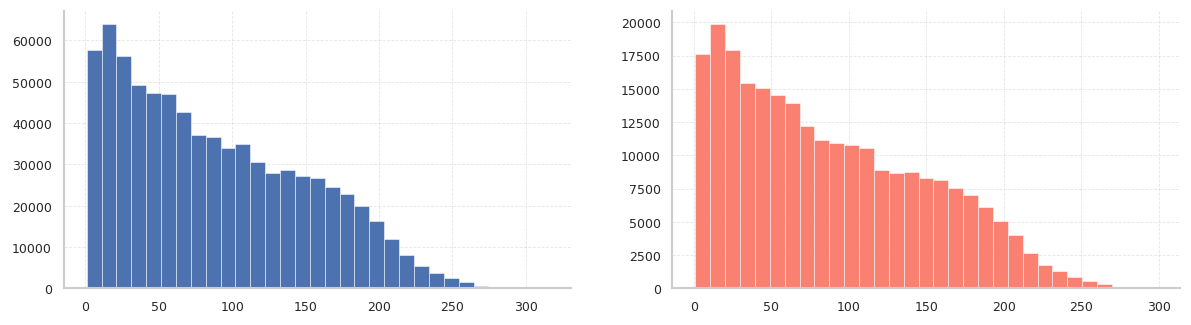

In [33]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [34]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

## **3.2.0 LGBMRegressor**

In [52]:
import lightgbm as lgb
lgbm_prob = {"objective":"regression","eval_metric":"rmse"}

In [53]:
X = data.X
y = np.log1p(data.y)
categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
categorical_features

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group']

### 3.2.1 Optuna Optimization:

In [57]:
def objective_lgbm(trial, X, y, n_splits=5, n_repeats=5, model=LGBMRegressor, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=lgbm_prob, categorical_features=categorical_features):

    model_class = model

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 121),
        'learning_rate': 0.02, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        #'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 80),
        'subsample': trial.suggest_float('subsample', 0.5, 0.975, step=0.01),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 3),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.01),
        "reg_alpha" :         trial.suggest_float("reg_alpha", 1e-3, 1.0, log=True),
        "reg_lambda" :        trial.suggest_float("reg_lambda", 1e-3, 1.0, log=True),
        "boosting_type":      'gbdt',
        'n_estimators': 2501,
        'objective': metrics["objective"],
        'device': 'gpu' if use_gpu else 'cpu',
        'verbose': -1,
#       'categorical_feature': [2,4,5,9],
        'random_state': rs,
    }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmse_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the datasets for LightGBM
        # d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
        # d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_features)

        # Create the model
        model = model_class(**params)

        # Create the early stopping callback
        early_stop = early_stopping(stopping_rounds=101)

        # Fit the model
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stop], eval_metric=metrics["eval_metric"], categorical_feature= categorical_features)

        # Make predictions on the validation set
        y_pred = model.predict(X_valid)

        # Calculate the RMSE for the current fold

        rmse_score = root_mean_squared_error(y_valid, y_pred)
        rmse_scores.append(rmse_score)

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmse_scores)

    return key_metric

In [58]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_lgbm(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [59]:
cat_study = tune_hyperparameters(X, y, model_class=LGBMRegressor, n_trials=37, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)
save_results(cat_study, LGBMRegressor, "LGBMBoost_ext")
cat_params = cat_study.best_params

[I 2025-05-21 11:15:13,201] A new study created in memory with name: no-name-8d9c29c3-2012-4b12-8d7a-5f37f95159dd


Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's rmse: 0.0604984	valid_0's l2: 0.00366006
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's rmse: 0.0606576	valid_0's l2: 0.00367935
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's rmse: 0.0598614	valid_0's l2: 0.00358339
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2501]	valid_0's rmse: 0.0605315	valid_0's l2: 0.00366406
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2501]	valid_0's rmse: 0.0600156	valid_0's l2: 0.00360187


[I 2025-05-21 11:20:10,909] Trial 0 finished with value: 0.060312908536955014 and parameters: {'num_leaves': 38, 'min_child_samples': 76, 'subsample': 0.91, 'subsample_freq': 2, 'colsample_bytree': 0.66, 'reg_alpha': 0.31877839310897077, 'reg_lambda': 0.5855853455762013}. Best is trial 0 with value: 0.060312908536955014.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1902]	valid_0's rmse: 0.0607117	valid_0's l2: 0.00368591
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1909]	valid_0's rmse: 0.0608795	valid_0's l2: 0.00370632
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2418]	valid_0's rmse: 0.0599542	valid_0's l2: 0.0035945
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2476]	valid_0's rmse: 0.0605996	valid_0's l2: 0.00367231
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's rmse: 0.0600927	valid_0's l2: 0.00361113


[I 2025-05-21 11:23:01,602] Trial 1 finished with value: 0.06044751980694126 and parameters: {'num_leaves': 42, 'min_child_samples': 79, 'subsample': 0.74, 'subsample_freq': 1, 'colsample_bytree': 0.7, 'reg_alpha': 0.004978483382189314, 'reg_lambda': 0.03163469201384263}. Best is trial 0 with value: 0.060312908536955014.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[937]	valid_0's rmse: 0.0605836	valid_0's l2: 0.00367038
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1224]	valid_0's rmse: 0.0609201	valid_0's l2: 0.00371126
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1194]	valid_0's rmse: 0.0597896	valid_0's l2: 0.00357479
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1340]	valid_0's rmse: 0.0606491	valid_0's l2: 0.00367832
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1367]	valid_0's rmse: 0.0600941	valid_0's l2: 0.0036113


[I 2025-05-21 11:26:14,253] Trial 2 finished with value: 0.060407316934952784 and parameters: {'num_leaves': 98, 'min_child_samples': 73, 'subsample': 0.59, 'subsample_freq': 3, 'colsample_bytree': 0.78, 'reg_alpha': 0.008275818443838638, 'reg_lambda': 0.05530002368207811}. Best is trial 0 with value: 0.060312908536955014.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1943]	valid_0's rmse: 0.0605125	valid_0's l2: 0.00366176
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2280]	valid_0's rmse: 0.0603818	valid_0's l2: 0.00364596
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2126]	valid_0's rmse: 0.0598333	valid_0's l2: 0.00358002
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2482]	valid_0's rmse: 0.0601722	valid_0's l2: 0.0036207
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1788]	valid_0's rmse: 0.0598665	valid_0's l2: 0.003584


[I 2025-05-21 11:30:46,132] Trial 3 finished with value: 0.0601532599676026 and parameters: {'num_leaves': 51, 'min_child_samples': 36, 'subsample': 0.8400000000000001, 'subsample_freq': 2, 'colsample_bytree': 0.9, 'reg_alpha': 0.9540215467586033, 'reg_lambda': 0.29425495689394876}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1337]	valid_0's rmse: 0.0606378	valid_0's l2: 0.00367694
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1547]	valid_0's rmse: 0.0609009	valid_0's l2: 0.00370892
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1420]	valid_0's rmse: 0.0598853	valid_0's l2: 0.00358625
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1813]	valid_0's rmse: 0.0606578	valid_0's l2: 0.00367937
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1649]	valid_0's rmse: 0.0600936	valid_0's l2: 0.00361125


[I 2025-05-21 11:33:29,270] Trial 4 finished with value: 0.06043506994368845 and parameters: {'num_leaves': 66, 'min_child_samples': 77, 'subsample': 0.54, 'subsample_freq': 1, 'colsample_bytree': 0.99, 'reg_alpha': 0.22002537102506792, 'reg_lambda': 0.04792277164580066}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1474]	valid_0's rmse: 0.0606173	valid_0's l2: 0.00367446
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1464]	valid_0's rmse: 0.0604181	valid_0's l2: 0.00365034
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1274]	valid_0's rmse: 0.0598157	valid_0's l2: 0.00357792
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2100]	valid_0's rmse: 0.0601609	valid_0's l2: 0.00361934
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1136]	valid_0's rmse: 0.0598893	valid_0's l2: 0.00358673


[I 2025-05-21 11:37:22,719] Trial 5 finished with value: 0.060180276715541936 and parameters: {'num_leaves': 105, 'min_child_samples': 24, 'subsample': 0.9, 'subsample_freq': 3, 'colsample_bytree': 0.5, 'reg_alpha': 0.002138690651217858, 'reg_lambda': 0.06283590585038785}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1369]	valid_0's rmse: 0.0605659	valid_0's l2: 0.00366823
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1606]	valid_0's rmse: 0.0608304	valid_0's l2: 0.00370034
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1275]	valid_0's rmse: 0.0597408	valid_0's l2: 0.00356896
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1666]	valid_0's rmse: 0.0604397	valid_0's l2: 0.00365296
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1336]	valid_0's rmse: 0.0600357	valid_0's l2: 0.00360428


[I 2025-05-21 11:41:32,482] Trial 6 finished with value: 0.060322485441259385 and parameters: {'num_leaves': 113, 'min_child_samples': 66, 'subsample': 0.64, 'subsample_freq': 3, 'colsample_bytree': 0.69, 'reg_alpha': 0.8627581563208432, 'reg_lambda': 0.1485329739968717}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1636]	valid_0's rmse: 0.0605159	valid_0's l2: 0.00366218
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2280]	valid_0's rmse: 0.0605185	valid_0's l2: 0.00366249
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2499]	valid_0's rmse: 0.0596932	valid_0's l2: 0.00356328
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2499]	valid_0's rmse: 0.0602231	valid_0's l2: 0.00362682
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2270]	valid_0's rmse: 0.0599851	valid_0's l2: 0.00359821


[I 2025-05-21 11:45:24,732] Trial 7 finished with value: 0.06018716414896482 and parameters: {'num_leaves': 94, 'min_child_samples': 55, 'subsample': 0.96, 'subsample_freq': 1, 'colsample_bytree': 0.58, 'reg_alpha': 0.06515966446536313, 'reg_lambda': 0.0010654340002674146}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[753]	valid_0's rmse: 0.0605139	valid_0's l2: 0.00366193
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1139]	valid_0's rmse: 0.0604643	valid_0's l2: 0.00365593
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[687]	valid_0's rmse: 0.0598338	valid_0's l2: 0.00358008
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1190]	valid_0's rmse: 0.060314	valid_0's l2: 0.00363778
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[738]	valid_0's rmse: 0.0598905	valid_0's l2: 0.00358687


[I 2025-05-21 11:47:26,849] Trial 8 finished with value: 0.060203314774109375 and parameters: {'num_leaves': 112, 'min_child_samples': 28, 'subsample': 0.67, 'subsample_freq': 1, 'colsample_bytree': 0.91, 'reg_alpha': 0.03812060658929169, 'reg_lambda': 0.006630798595687524}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1260]	valid_0's rmse: 0.0605982	valid_0's l2: 0.00367214
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1194]	valid_0's rmse: 0.0607155	valid_0's l2: 0.00368637
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1126]	valid_0's rmse: 0.0598973	valid_0's l2: 0.00358768
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1652]	valid_0's rmse: 0.0605258	valid_0's l2: 0.00366337
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1423]	valid_0's rmse: 0.0599746	valid_0's l2: 0.00359695


[I 2025-05-21 11:49:57,737] Trial 9 finished with value: 0.060342264159420345 and parameters: {'num_leaves': 83, 'min_child_samples': 49, 'subsample': 0.5700000000000001, 'subsample_freq': 1, 'colsample_bytree': 0.9, 'reg_alpha': 0.012056379644422612, 'reg_lambda': 0.0926725115394528}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1940]	valid_0's rmse: 0.0604622	valid_0's l2: 0.00365567
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1316]	valid_0's rmse: 0.0605783	valid_0's l2: 0.00366973
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1424]	valid_0's rmse: 0.0598418	valid_0's l2: 0.00358104
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2062]	valid_0's rmse: 0.0602365	valid_0's l2: 0.00362844
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2232]	valid_0's rmse: 0.0598549	valid_0's l2: 0.00358261


[I 2025-05-21 11:54:05,969] Trial 10 finished with value: 0.060194737621874814 and parameters: {'num_leaves': 59, 'min_child_samples': 37, 'subsample': 0.8, 'subsample_freq': 2, 'colsample_bytree': 0.8200000000000001, 'reg_alpha': 0.7899302359145522, 'reg_lambda': 0.8122694410944421}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2156]	valid_0's rmse: 0.0606547	valid_0's l2: 0.003679
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2498]	valid_0's rmse: 0.0604221	valid_0's l2: 0.00365083
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1598]	valid_0's rmse: 0.0599735	valid_0's l2: 0.00359683
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's rmse: 0.0602831	valid_0's l2: 0.00363405
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1852]	valid_0's rmse: 0.0598491	valid_0's l2: 0.00358192


[I 2025-05-21 11:58:36,917] Trial 11 finished with value: 0.06023652642697867 and parameters: {'num_leaves': 56, 'min_child_samples': 22, 'subsample': 0.87, 'subsample_freq': 2, 'colsample_bytree': 0.5, 'reg_alpha': 0.0010965995925201245, 'reg_lambda': 0.24856827273385568}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1101]	valid_0's rmse: 0.0604639	valid_0's l2: 0.00365589
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1695]	valid_0's rmse: 0.0604103	valid_0's l2: 0.0036494
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1006]	valid_0's rmse: 0.0599127	valid_0's l2: 0.00358953
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1504]	valid_0's rmse: 0.0603226	valid_0's l2: 0.00363882
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1335]	valid_0's rmse: 0.0598532	valid_0's l2: 0.00358241


[I 2025-05-21 12:01:46,725] Trial 12 finished with value: 0.060192549947783155 and parameters: {'num_leaves': 78, 'min_child_samples': 35, 'subsample': 0.8400000000000001, 'subsample_freq': 3, 'colsample_bytree': 0.8500000000000001, 'reg_alpha': 0.0016152642443395798, 'reg_lambda': 0.006517931242313726}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1807]	valid_0's rmse: 0.0607119	valid_0's l2: 0.00368594
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1967]	valid_0's rmse: 0.0606876	valid_0's l2: 0.00368298
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1829]	valid_0's rmse: 0.0600155	valid_0's l2: 0.00360186
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2436]	valid_0's rmse: 0.0605169	valid_0's l2: 0.0036623
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2494]	valid_0's rmse: 0.0601102	valid_0's l2: 0.00361324


[I 2025-05-21 12:05:44,135] Trial 13 finished with value: 0.06040841850697419 and parameters: {'num_leaves': 49, 'min_child_samples': 41, 'subsample': 0.77, 'subsample_freq': 3, 'colsample_bytree': 0.58, 'reg_alpha': 0.11761404440719492, 'reg_lambda': 0.30189120643991285}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2501]	valid_0's rmse: 0.0605562	valid_0's l2: 0.00366705
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2501]	valid_0's rmse: 0.0604156	valid_0's l2: 0.00365004
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2498]	valid_0's rmse: 0.0599553	valid_0's l2: 0.00359463
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2501]	valid_0's rmse: 0.0603269	valid_0's l2: 0.00363933
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's rmse: 0.0598858	valid_0's l2: 0.00358631


[I 2025-05-21 12:10:21,315] Trial 14 finished with value: 0.060227925734350055 and parameters: {'num_leaves': 32, 'min_child_samples': 23, 'subsample': 0.97, 'subsample_freq': 2, 'colsample_bytree': 0.99, 'reg_alpha': 0.019241976622734355, 'reg_lambda': 0.01164532050404593}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1338]	valid_0's rmse: 0.0605879	valid_0's l2: 0.0036709
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1943]	valid_0's rmse: 0.060536	valid_0's l2: 0.0036646
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1490]	valid_0's rmse: 0.0599351	valid_0's l2: 0.00359222
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2477]	valid_0's rmse: 0.0601144	valid_0's l2: 0.00361374
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1890]	valid_0's rmse: 0.0600784	valid_0's l2: 0.00360941


[I 2025-05-21 12:15:15,876] Trial 15 finished with value: 0.06025035428950052 and parameters: {'num_leaves': 94, 'min_child_samples': 31, 'subsample': 0.89, 'subsample_freq': 2, 'colsample_bytree': 0.53, 'reg_alpha': 0.0025165180656537616, 'reg_lambda': 0.014739187937390845}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1146]	valid_0's rmse: 0.0605359	valid_0's l2: 0.0036646
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1095]	valid_0's rmse: 0.0605513	valid_0's l2: 0.00366646
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1349]	valid_0's rmse: 0.0598233	valid_0's l2: 0.00357882
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1743]	valid_0's rmse: 0.0602731	valid_0's l2: 0.00363285
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1834]	valid_0's rmse: 0.0598447	valid_0's l2: 0.00358139


[I 2025-05-21 12:18:34,956] Trial 16 finished with value: 0.06020566364211364 and parameters: {'num_leaves': 71, 'min_child_samples': 46, 'subsample': 0.8300000000000001, 'subsample_freq': 3, 'colsample_bytree': 0.75, 'reg_alpha': 0.0032401247753890577, 'reg_lambda': 0.12221564427866086}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[822]	valid_0's rmse: 0.0605411	valid_0's l2: 0.00366522
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1034]	valid_0's rmse: 0.060681	valid_0's l2: 0.00368218
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[890]	valid_0's rmse: 0.0597381	valid_0's l2: 0.00356864
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1144]	valid_0's rmse: 0.0604703	valid_0's l2: 0.00365665
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1165]	valid_0's rmse: 0.0599319	valid_0's l2: 0.00359183


[I 2025-05-21 12:21:51,253] Trial 17 finished with value: 0.06027244614719712 and parameters: {'num_leaves': 118, 'min_child_samples': 57, 'subsample': 0.71, 'subsample_freq': 2, 'colsample_bytree': 0.9199999999999999, 'reg_alpha': 0.031073797352793302, 'reg_lambda': 0.35631834640059806}. Best is trial 3 with value: 0.0601532599676026.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1171]	valid_0's rmse: 0.0604698	valid_0's l2: 0.0036566
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1710]	valid_0's rmse: 0.0603744	valid_0's l2: 0.00364507
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1574]	valid_0's rmse: 0.0597244	valid_0's l2: 0.00356701
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1462]	valid_0's rmse: 0.060143	valid_0's l2: 0.00361719
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1414]	valid_0's rmse: 0.059974	valid_0's l2: 0.00359688


[I 2025-05-21 12:25:53,828] Trial 18 finished with value: 0.0601371412292613 and parameters: {'num_leaves': 105, 'min_child_samples': 28, 'subsample': 0.9199999999999999, 'subsample_freq': 3, 'colsample_bytree': 0.63, 'reg_alpha': 0.34641855823340606, 'reg_lambda': 0.0014682905608102597}. Best is trial 18 with value: 0.0601371412292613.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1571]	valid_0's rmse: 0.0603921	valid_0's l2: 0.00364721
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2111]	valid_0's rmse: 0.0603814	valid_0's l2: 0.00364591
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1717]	valid_0's rmse: 0.0597121	valid_0's l2: 0.00356554
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2496]	valid_0's rmse: 0.060113	valid_0's l2: 0.00361357
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1537]	valid_0's rmse: 0.059897	valid_0's l2: 0.00358765


[I 2025-05-21 12:30:54,359] Trial 19 finished with value: 0.06009911940576448 and parameters: {'num_leaves': 85, 'min_child_samples': 40, 'subsample': 0.9299999999999999, 'subsample_freq': 2, 'colsample_bytree': 0.63, 'reg_alpha': 0.37965324873153833, 'reg_lambda': 0.0011073090228296263}. Best is trial 19 with value: 0.06009911940576448.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1563]	valid_0's rmse: 0.0603791	valid_0's l2: 0.00364563
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1544]	valid_0's rmse: 0.0604492	valid_0's l2: 0.00365411
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1515]	valid_0's rmse: 0.0596478	valid_0's l2: 0.00355786
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2484]	valid_0's rmse: 0.0601344	valid_0's l2: 0.00361615
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2427]	valid_0's rmse: 0.0598274	valid_0's l2: 0.00357932


[I 2025-05-21 12:35:30,011] Trial 20 finished with value: 0.060087585918880436 and parameters: {'num_leaves': 83, 'min_child_samples': 43, 'subsample': 0.94, 'subsample_freq': 3, 'colsample_bytree': 0.63, 'reg_alpha': 0.3034307637828119, 'reg_lambda': 0.0010815180396117478}. Best is trial 20 with value: 0.060087585918880436.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1545]	valid_0's rmse: 0.0603454	valid_0's l2: 0.00364156
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1641]	valid_0's rmse: 0.060449	valid_0's l2: 0.00365408
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1821]	valid_0's rmse: 0.0597057	valid_0's l2: 0.00356477
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2461]	valid_0's rmse: 0.0601564	valid_0's l2: 0.0036188
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2212]	valid_0's rmse: 0.0598057	valid_0's l2: 0.00357672


[I 2025-05-21 12:40:11,533] Trial 21 finished with value: 0.06009243612285414 and parameters: {'num_leaves': 84, 'min_child_samples': 43, 'subsample': 0.94, 'subsample_freq': 3, 'colsample_bytree': 0.63, 'reg_alpha': 0.3150632201888339, 'reg_lambda': 0.0010156244086009824}. Best is trial 20 with value: 0.060087585918880436.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1562]	valid_0's rmse: 0.0604231	valid_0's l2: 0.00365095
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1596]	valid_0's rmse: 0.0605077	valid_0's l2: 0.00366118
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1452]	valid_0's rmse: 0.0597135	valid_0's l2: 0.00356571
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2433]	valid_0's rmse: 0.060166	valid_0's l2: 0.00361995
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2210]	valid_0's rmse: 0.0598364	valid_0's l2: 0.00358039


[I 2025-05-21 12:44:41,466] Trial 22 finished with value: 0.060129337155098585 and parameters: {'num_leaves': 83, 'min_child_samples': 44, 'subsample': 0.94, 'subsample_freq': 3, 'colsample_bytree': 0.61, 'reg_alpha': 0.14355819951145946, 'reg_lambda': 0.002291815061092331}. Best is trial 20 with value: 0.060087585918880436.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1943]	valid_0's rmse: 0.0603332	valid_0's l2: 0.0036401
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2448]	valid_0's rmse: 0.0604506	valid_0's l2: 0.00365427
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1982]	valid_0's rmse: 0.0596091	valid_0's l2: 0.00355325
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2498]	valid_0's rmse: 0.0601001	valid_0's l2: 0.00361202
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1667]	valid_0's rmse: 0.0598823	valid_0's l2: 0.00358588


[I 2025-05-21 12:49:56,772] Trial 23 finished with value: 0.060075047028168536 and parameters: {'num_leaves': 87, 'min_child_samples': 54, 'subsample': 0.97, 'subsample_freq': 3, 'colsample_bytree': 0.69, 'reg_alpha': 0.44366687134201144, 'reg_lambda': 0.0029443778811833535}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1822]	valid_0's rmse: 0.0604059	valid_0's l2: 0.00364887
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2472]	valid_0's rmse: 0.0604338	valid_0's l2: 0.00365225
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2265]	valid_0's rmse: 0.0596198	valid_0's l2: 0.00355453
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2501]	valid_0's rmse: 0.0601725	valid_0's l2: 0.00362073
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2368]	valid_0's rmse: 0.059851	valid_0's l2: 0.00358214


[I 2025-05-21 12:55:03,844] Trial 24 finished with value: 0.06009661533316065 and parameters: {'num_leaves': 72, 'min_child_samples': 55, 'subsample': 0.97, 'subsample_freq': 3, 'colsample_bytree': 0.71, 'reg_alpha': 0.07442601241077525, 'reg_lambda': 0.003145379417173977}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1353]	valid_0's rmse: 0.0604548	valid_0's l2: 0.00365479
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1840]	valid_0's rmse: 0.0605443	valid_0's l2: 0.00366561
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1632]	valid_0's rmse: 0.0597011	valid_0's l2: 0.00356423
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2089]	valid_0's rmse: 0.0602657	valid_0's l2: 0.00363195
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1995]	valid_0's rmse: 0.0599215	valid_0's l2: 0.00359059


[I 2025-05-21 12:59:37,588] Trial 25 finished with value: 0.06017749990000136 and parameters: {'num_leaves': 89, 'min_child_samples': 64, 'subsample': 0.86, 'subsample_freq': 3, 'colsample_bytree': 0.74, 'reg_alpha': 0.433044479168789, 'reg_lambda': 0.0028179674954663123}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1759]	valid_0's rmse: 0.060529	valid_0's l2: 0.00366376
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1605]	valid_0's rmse: 0.0607756	valid_0's l2: 0.00369368
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1828]	valid_0's rmse: 0.0598493	valid_0's l2: 0.00358194
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2484]	valid_0's rmse: 0.060439	valid_0's l2: 0.00365287
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2063]	valid_0's rmse: 0.0601093	valid_0's l2: 0.00361313


[I 2025-05-21 13:04:08,745] Trial 26 finished with value: 0.06034043947654936 and parameters: {'num_leaves': 77, 'min_child_samples': 61, 'subsample': 0.79, 'subsample_freq': 3, 'colsample_bytree': 0.5700000000000001, 'reg_alpha': 0.1741820186228898, 'reg_lambda': 0.004676661719081735}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1158]	valid_0's rmse: 0.0606184	valid_0's l2: 0.00367459
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1073]	valid_0's rmse: 0.060974	valid_0's l2: 0.00371783
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1218]	valid_0's rmse: 0.0598577	valid_0's l2: 0.00358295
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1670]	valid_0's rmse: 0.0605877	valid_0's l2: 0.00367087
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1524]	valid_0's rmse: 0.0601707	valid_0's l2: 0.00362051


[I 2025-05-21 13:07:37,579] Trial 27 finished with value: 0.06044170320279189 and parameters: {'num_leaves': 100, 'min_child_samples': 50, 'subsample': 0.5, 'subsample_freq': 3, 'colsample_bytree': 0.65, 'reg_alpha': 0.5900444456840043, 'reg_lambda': 0.0018384439637254008}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1706]	valid_0's rmse: 0.060508	valid_0's l2: 0.00366122
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2046]	valid_0's rmse: 0.0604241	valid_0's l2: 0.00365107
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1819]	valid_0's rmse: 0.0598274	valid_0's l2: 0.00357932
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2501]	valid_0's rmse: 0.0602817	valid_0's l2: 0.00363388
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2256]	valid_0's rmse: 0.0599018	valid_0's l2: 0.00358823


[I 2025-05-21 13:12:02,342] Trial 28 finished with value: 0.06018860619488686 and parameters: {'num_leaves': 65, 'min_child_samples': 46, 'subsample': 0.88, 'subsample_freq': 3, 'colsample_bytree': 0.67, 'reg_alpha': 0.07284139995513725, 'reg_lambda': 0.0041834884665749765}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1796]	valid_0's rmse: 0.0605302	valid_0's l2: 0.0036639
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2409]	valid_0's rmse: 0.0604959	valid_0's l2: 0.00365975
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1902]	valid_0's rmse: 0.059694	valid_0's l2: 0.00356338
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2501]	valid_0's rmse: 0.0601907	valid_0's l2: 0.00362292
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2260]	valid_0's rmse: 0.0599766	valid_0's l2: 0.00359719


[I 2025-05-21 13:17:29,648] Trial 29 finished with value: 0.06017747347789826 and parameters: {'num_leaves': 88, 'min_child_samples': 52, 'subsample': 0.9299999999999999, 'subsample_freq': 3, 'colsample_bytree': 0.55, 'reg_alpha': 0.22937270099093765, 'reg_lambda': 0.013501784591942793}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1581]	valid_0's rmse: 0.0603654	valid_0's l2: 0.00364398
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1824]	valid_0's rmse: 0.060372	valid_0's l2: 0.00364478
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1824]	valid_0's rmse: 0.0596986	valid_0's l2: 0.00356393
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2431]	valid_0's rmse: 0.0601432	valid_0's l2: 0.0036172
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1669]	valid_0's rmse: 0.0598247	valid_0's l2: 0.003579


[I 2025-05-21 13:21:56,129] Trial 30 finished with value: 0.06008077899809906 and parameters: {'num_leaves': 77, 'min_child_samples': 42, 'subsample': 0.9199999999999999, 'subsample_freq': 3, 'colsample_bytree': 0.79, 'reg_alpha': 0.5605757959545893, 'reg_lambda': 0.0015821180387974002}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1459]	valid_0's rmse: 0.0603695	valid_0's l2: 0.00364447
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1689]	valid_0's rmse: 0.0604455	valid_0's l2: 0.00365366
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1849]	valid_0's rmse: 0.0596545	valid_0's l2: 0.00355866
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2112]	valid_0's rmse: 0.0601536	valid_0's l2: 0.00361845
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1740]	valid_0's rmse: 0.0597559	valid_0's l2: 0.00357077


[I 2025-05-21 13:26:17,151] Trial 31 finished with value: 0.060075775846931745 and parameters: {'num_leaves': 81, 'min_child_samples': 42, 'subsample': 0.91, 'subsample_freq': 3, 'colsample_bytree': 0.8, 'reg_alpha': 0.5896953108809956, 'reg_lambda': 0.001652622390333842}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1613]	valid_0's rmse: 0.0603603	valid_0's l2: 0.00364337
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1977]	valid_0's rmse: 0.0603161	valid_0's l2: 0.00363803
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1924]	valid_0's rmse: 0.0597286	valid_0's l2: 0.0035675
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2499]	valid_0's rmse: 0.0601905	valid_0's l2: 0.0036229
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1857]	valid_0's rmse: 0.0597802	valid_0's l2: 0.00357367


[I 2025-05-21 13:30:48,029] Trial 32 finished with value: 0.06007514412846025 and parameters: {'num_leaves': 75, 'min_child_samples': 38, 'subsample': 0.9, 'subsample_freq': 3, 'colsample_bytree': 0.79, 'reg_alpha': 0.5724687054001825, 'reg_lambda': 0.0019738089684101677}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1543]	valid_0's rmse: 0.0603364	valid_0's l2: 0.00364048
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1985]	valid_0's rmse: 0.0603045	valid_0's l2: 0.00363663
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1830]	valid_0's rmse: 0.0598178	valid_0's l2: 0.00357817
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2100]	valid_0's rmse: 0.0601703	valid_0's l2: 0.00362046
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2065]	valid_0's rmse: 0.0598236	valid_0's l2: 0.00357886


[I 2025-05-21 13:35:05,673] Trial 33 finished with value: 0.06009051088232015 and parameters: {'num_leaves': 70, 'min_child_samples': 33, 'subsample': 0.9, 'subsample_freq': 3, 'colsample_bytree': 0.79, 'reg_alpha': 0.576149360598825, 'reg_lambda': 0.0019069031543445687}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1677]	valid_0's rmse: 0.0604678	valid_0's l2: 0.00365636
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1637]	valid_0's rmse: 0.0604092	valid_0's l2: 0.00364928
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1821]	valid_0's rmse: 0.0598415	valid_0's l2: 0.00358101
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2220]	valid_0's rmse: 0.0602955	valid_0's l2: 0.00363555
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1695]	valid_0's rmse: 0.0598815	valid_0's l2: 0.0035858


[I 2025-05-21 13:38:59,924] Trial 34 finished with value: 0.060179124098262426 and parameters: {'num_leaves': 63, 'min_child_samples': 39, 'subsample': 0.8200000000000001, 'subsample_freq': 3, 'colsample_bytree': 0.8400000000000001, 'reg_alpha': 0.6228532800122484, 'reg_lambda': 0.008171512146090855}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1256]	valid_0's rmse: 0.0604816	valid_0's l2: 0.00365802
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1953]	valid_0's rmse: 0.0604346	valid_0's l2: 0.00365234
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1525]	valid_0's rmse: 0.0598114	valid_0's l2: 0.00357741
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1829]	valid_0's rmse: 0.0602566	valid_0's l2: 0.00363085
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1651]	valid_0's rmse: 0.059841	valid_0's l2: 0.00358094


[I 2025-05-21 13:42:55,030] Trial 35 finished with value: 0.06016503584301399 and parameters: {'num_leaves': 77, 'min_child_samples': 47, 'subsample': 0.86, 'subsample_freq': 3, 'colsample_bytree': 0.79, 'reg_alpha': 0.10577663215894992, 'reg_lambda': 0.003966301769321919}. Best is trial 23 with value: 0.060075047028168536.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1257]	valid_0's rmse: 0.0604672	valid_0's l2: 0.00365628
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1625]	valid_0's rmse: 0.0606027	valid_0's l2: 0.00367269
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1344]	valid_0's rmse: 0.0596847	valid_0's l2: 0.00356227
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2199]	valid_0's rmse: 0.0603464	valid_0's l2: 0.00364169
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1526]	valid_0's rmse: 0.0599701	valid_0's l2: 0.00359641


[I 2025-05-21 13:47:13,284] Trial 36 finished with value: 0.06021422553301793 and parameters: {'num_leaves': 94, 'min_child_samples': 52, 'subsample': 0.74, 'subsample_freq': 3, 'colsample_bytree': 0.72, 'reg_alpha': 0.9615360504528819, 'reg_lambda': 0.0017757743214253784}. Best is trial 23 with value: 0.060075047028168536.


Best parameters for LGBMBoost_ext saved to LGBMBoost_ext_best_params.joblib
Optuna verbose for LGBMBoost_ext saved to LGBMBoost_ext_optuna_verbose.log


In [61]:
cat_params

{'num_leaves': 87,
 'min_child_samples': 54,
 'subsample': 0.97,
 'subsample_freq': 3,
 'colsample_bytree': 0.69,
 'reg_alpha': 0.44366687134201144,
 'reg_lambda': 0.0029443778811833535}

  1. Trial 20 finished with value: 0.060075047028168536 and parameters: {'num_leaves': 87,
 'min_child_samples': 54,
 'subsample': 0.97,
 'subsample_freq': 3,
 'colsample_bytree': 0.69,
 'reg_alpha': 0.44366687134201144,
 'reg_lambda': 0.0029443778811833535}

### 3.2.2 Train Model:

In [62]:
lgbm_prob = {"objective":"regression","eval_metric":"rmse"}
categorical_features = data.X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()

In [63]:
X = data.X
y = np.log1p(data.y)
categorical_features

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group']

In [64]:
X_test = data.X_test

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

**FIT THE MODEL**

In [66]:
# param = {
#         'num_leaves': 100,
#         'learning_rate': 0.02,
#         'min_child_samples': 53,
#         'subsample': 0.911,
#         'subsample_freq': 2,
#         'colsample_bytree': 0.84,
#         "reg_alpha" : 0.9644,
#         "reg_lambda" : 0.011222743073631622,
#         "boosting_type": 'gbdt',
#         'n_estimators': 2501,
#         'objective': lgbm_prob["objective"],
#         'device': 'gpu',
#         'verbose': -1,
#         'random_state': 42,
#         }

param = {
        'num_leaves': 87,
        'learning_rate': 0.02,
        'min_child_samples': 54,
        'subsample': 0.97,
        'subsample_freq': 3,
        'colsample_bytree': 0.69,
        "reg_alpha" : 0.4436668,
        "reg_lambda" : 0.0029443778811833535,
        "boosting_type": 'gbdt',
        'n_estimators': 2501,
        'objective': lgbm_prob["objective"],
        'device': 'gpu',
        'verbose': -1,
        'random_state': 42,
        }

models={'LGBMR1_v1':[LGBMRegressor(**param),True]}

TM = TrainModels(X=X, y=y, X_test=X_test, X_original=None, y_original=None, models=models)
TM.fit_models()

     Fitting LGBMR1_v1
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1634]	valid_0's l2: 0.00354562
Pred Min&Max Valid: 1.0339700230275632 and 293.83059655084435
Pred Min&Max Test: 0.8792084898839233 and 294.80907622365953
Pred Min&Max Valid Adj: 1.0339700230275632 and 293.83059655084435
Pred Min&Max Test Adj: 1.0 and 294.80907622365953
Fold 1 → Training set Score: 0.05573 | Validation set Score: 0.05955
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2501]	valid_0's l2: 0.0037482
Pred Min&Max Valid: 0.8462960977445632 and 302.6180266715778
Pred Min&Max Test: 0.8235808837719156 and 294.02757821323166
Pred Min&Max Valid Adj: 1.0 and 302.6180266715778
Pred Min&Max Test Adj: 1.0 and 294.02757821323166
Fold 2 → Training set Score: 0.05421 | Validation set Score: 0.06122
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1512]	vali

### 3.1.3 Store Results:

In [67]:
name_experiment = "LGBMR1_adj_values_v1"

test_pred = TM.OOF_test.mean(axis=1) #np.expm1(TM.OOF_test.mean(axis=1))
train_pred = TM.OOF_train.mean(axis=1) #np.expm1(TM.OOF_train.mean(axis=1))

In [68]:
test_pred.min(), test_pred.max()

(1.0000000000000002, 293.92211084165643)

In [69]:
test_pred.head()

,0
0,27.335869
1,107.655940
2,86.687914
3,126.450813
4,76.379999


In [70]:
sub["Calories"] =  test_pred.values

sub.head()

,Calories
id,
750000,27.335869
750001,107.655940
750002,86.687914
750003,126.450813
750004,76.379999


In [71]:
train_pred.head()

,0
0,146.852335
1,36.096230
2,29.635807
3,138.429784
4,145.930163


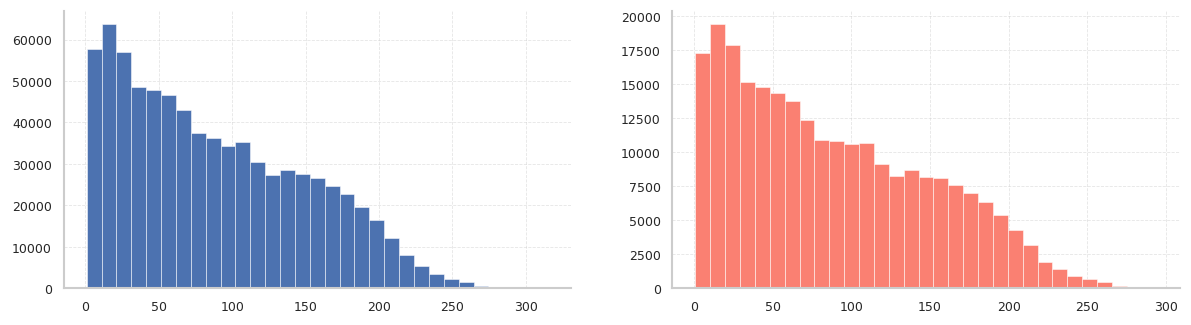

In [72]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [73]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

## **3.3.0 XGBRegressor**

In [35]:
import xgboost as xgb
xgb_prob = {'objective': "reg:squarederror",'eval_metric': "rmse"}

In [36]:
X = data.X
y = np.log1p(data.y)
categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
categorical_features

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group']

### 3.2.1 Optuna Optimization:

In [37]:
def objective_xgb(trial, X, y, n_splits=5, n_repeats=5, model=XGBRegressor, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=xgb_prob, categorical_features=categorical_features):

    model_class = model

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'n_estimators': 2000,
              'learning_rate': 0.02, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
              'max_depth': trial.suggest_int('max_depth', 7, 15),
              'max_bin': trial.suggest_int('max_bin', 301, 511),
              'min_child_weight': trial.suggest_int('min_child_weight', 6, 12),
              'subsample': trial.suggest_float('subsample', 0.7, 0.975, step=0.01),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.975, step=0.01),
              'gamma': trial.suggest_float('gamma', 0, 1),
              'reg_alpha': trial.suggest_float('reg_alpha', 0.00001, 10.0, log=True),
              'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0, log=True),
              'objective':  metrics["objective"],
              'eval_metric': metrics["eval_metric"],
              "early_stopping_rounds":101,
              'tree_method': 'gpu_hist' if use_gpu else 'hist',  # Use GPU if available
              'random_state': rs,
              'enable_categorical': True,
#              'scale_pos_weight': sample_pos_weight,
             }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmse_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the datasets for LightGBM
        # d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
        # d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_features)

        # Create the model
        model = model_class(**params)

        # Fit the model
        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  verbose=False)

        # Make predictions on the validation set
        y_pred = model.predict(X_valid)

        # Calculate the RMSE for the current fold

        rmse_score = root_mean_squared_error(y_valid, y_pred)
        rmse_scores.append(rmse_score)

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmse_scores)

    return key_metric

In [38]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_xgb(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [42]:
cat_study = tune_hyperparameters(X, y, model_class=XGBRegressor, n_trials=51, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)
save_results(cat_study, objective_xgb, "XGBoost_ext")
cat_params = cat_study.best_params

[I 2025-05-21 09:53:25,588] A new study created in memory with name: no-name-7c85b321-0d36-493b-a4e4-de624db7de8f
[I 2025-05-21 09:53:49,291] Trial 0 finished with value: 0.06110165105697048 and parameters: {'max_depth': 11, 'max_bin': 330, 'min_child_weight': 5, 'subsample': 0.525, 'colsample_bytree': 0.65, 'gamma': 0.3006516480627368, 'reg_alpha': 1.764364796420454e-05, 'reg_lambda': 0.896595154979287}. Best is trial 0 with value: 0.06110165105697048.
[I 2025-05-21 09:54:06,322] Trial 1 finished with value: 0.06134741487232644 and parameters: {'max_depth': 8, 'max_bin': 284, 'min_child_weight': 3, 'subsample': 0.55, 'colsample_bytree': 0.95, 'gamma': 0.7193034147290408, 'reg_alpha': 0.04362451136642456, 'reg_lambda': 0.012949954972695155}. Best is trial 0 with value: 0.06110165105697048.
[I 2025-05-21 09:54:27,994] Trial 2 finished with value: 0.06056424267746087 and parameters: {'max_depth': 9, 'max_bin': 462, 'min_child_weight': 11, 'subsample': 0.7, 'colsample_bytree': 0.65, 'gamm

Best parameters for XGBoost_ext saved to XGBoost_ext_best_params.joblib
Optuna verbose for XGBoost_ext saved to XGBoost_ext_optuna_verbose.log


  1. Trial 15 finished with value: 0.059863399077917635 and parameters: {'max_depth': 9, 'max_bin': 500, 'min_child_weight': 10, 'subsample': 0.725, 'colsample_bytree': 0.9, 'gamma': 0.008466292503223255, 'reg_alpha': 0.0002441942689378388, 'reg_lambda': 0.3541504204890747}. Best is trial 15 with value: 0.059863399077917635

In [43]:
cat_params

{'max_depth': 14,
 'max_bin': 365,
 'min_child_weight': 8,
 'subsample': 0.625,
 'colsample_bytree': 0.8,
 'gamma': 0.0743414702271907,
 'reg_alpha': 0.6266907925001929,
 'reg_lambda': 0.8112471374459642}

### 3.2.2 Train Model:

In [ ]:
xgb_prob = {'objective': "reg:squarederror",'eval_metric': "rmse"}
categorical_features = data.X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()

In [ ]:
X = data.X
y = np.log1p(data.y)
categorical_features

In [ ]:
X_test = data.X_test

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

**FIT THE MODEL**

{'max_depth': 9, 'max_bin': 500, 'min_child_weight': 10, 'subsample': 0.725, 'colsample_bytree': 0.9, 'gamma': 0.008466292503223255, 'reg_alpha': 0.0002441942689378388, 'reg_lambda': 0.3541504204890747}

In [44]:
param = {
              'n_estimators': 3000,
              'learning_rate': 0.02,
              'max_depth': 9,
              'max_bin': 500,
              'min_child_weight': 10,
              'subsample': 0.725,
              'colsample_bytree': 0.9,
              'gamma': 0.008466292503223255,
              'reg_alpha': 0.0002441942689378388,
              'reg_lambda':  0.3541504204890747,
              'objective':  xgb_prob["objective"],
              'eval_metric': xgb_prob["eval_metric"],
              "early_stopping_rounds":101,
              'tree_method': 'gpu_hist' ,
              'random_state': 42,
              'enable_categorical': True,
             }

models={'XGBR1':[XGBRegressor(**param),True]}

TM = TrainModels(X=X, y=y, X_test=X_test, X_original=None, y_original=None, models=models)
TM.fit_models()

     Fitting XGBR1
[0]	validation_0-rmse:0.94208
[250]	validation_0-rmse:0.06069
[500]	validation_0-rmse:0.05988
[750]	validation_0-rmse:0.05982
[1000]	validation_0-rmse:0.05975
[1145]	validation_0-rmse:0.05973
Pred Min&Max Valid: 1.025611400604248 and 298.11456298828125
Pred Min&Max Test: 0.8822776079177856 and 298.713623046875
Pred Min&Max Valid Adj: 1.025611400604248 and 298.11456298828125
Pred Min&Max Test Adj: 1.0 and 298.713623046875
Fold 1 → Training set Score: 0.05352 | Validation set Score: 0.05972
[0]	validation_0-rmse:0.94695
[250]	validation_0-rmse:0.06259
[500]	validation_0-rmse:0.06124
[750]	validation_0-rmse:0.06117
[804]	validation_0-rmse:0.06117
Pred Min&Max Valid: 1.0710870027542114 and 302.21923828125
Pred Min&Max Test: 0.9187712073326111 and 299.44696044921875
Pred Min&Max Valid Adj: 1.0710870027542114 and 302.21923828125
Pred Min&Max Test Adj: 1.0 and 299.44696044921875
Fold 2 → Training set Score: 0.05464 | Validation set Score: 0.06115
[0]	validation_0-rmse:0.939

### 3.1.3 Store Results:

In [45]:
name_experiment = "XGBR1_adj_values_v1"

test_pred = TM.OOF_test.mean(axis=1) #np.expm1(TM.OOF_test.mean(axis=1))
train_pred = TM.OOF_train.mean(axis=1) #np.expm1(TM.OOF_train.mean(axis=1))

In [46]:
test_pred.min(), test_pred.max()

(1.0000693127512932, 300.6382827758789)

In [47]:
test_pred.head()

,0
0,27.228246
1,107.519049
2,86.634685
3,128.024236
4,75.564346


In [48]:
sub["Calories"] =  test_pred.values

sub.head()

,Calories
id,
750000,27.228246
750001,107.519049
750002,86.634685
750003,128.024236
750004,75.564346


In [49]:
train_pred.head()

,0
0,145.235535
1,36.217987
2,29.109226
3,139.877106
4,145.521210


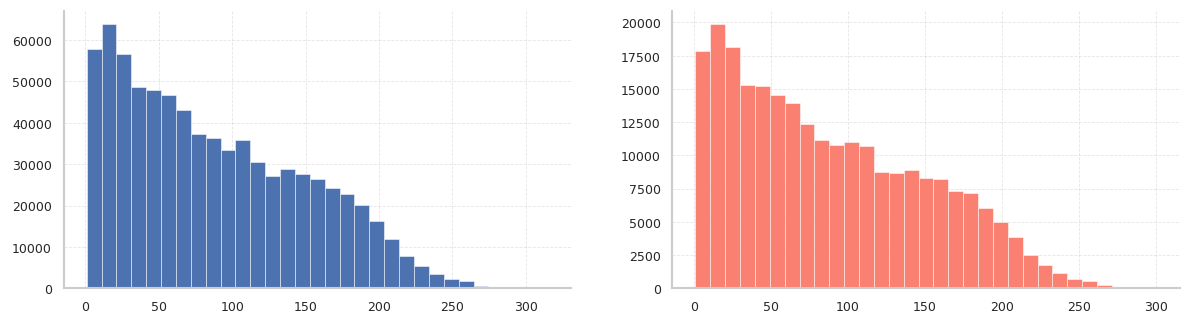

In [50]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [51]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")